---
# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

# ---

# In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

# > **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
#    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

# In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

# >**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

# The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



# ---
### Why We're Here 

# In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

# ![Sample Dog Output](images/sample_dog_output.png)

# In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

 ### The Road Ahead

# We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

# * [Step 0](#step0): Import Datasets
# * [Step 1](#step1): Detect Humans
# * [Step 2](#step2): Detect Dogs
# * [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
# * [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
# * [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
# * [Step 6](#step6): Write your Algorithm
# * [Step 7](#step7): Test Your Algorithm

# ---
# <a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

# In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
# - `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
# - `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
# - `dog_names` - list of string-valued dog breed names for translating labels



In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset("dogImages/train")
valid_files, valid_targets = load_dataset("dogImages/valid")
test_files, test_targets = load_dataset("dogImages/test")

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
# print("There are %d total dog categories." % len(dog_names))
print('There are %d total dog categories.' % len(dog_names))
print("There are %s total dog images.\n" % len(np.hstack([train_files, valid_files, test_files])))
print("There are %d training dog images." % len(train_files))
print("There are %d validation dog images." % len(valid_files))
print("There are %d test dog images." % len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


In [ ]:
---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


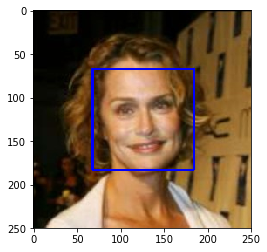

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:

As you can see, the face detector isn't perfect as it finds human faces in 12% of the dog photos.

Further, the technique we selected for face detection requires a clear view of a face (ie. doesn't perform well on occlusions). If we wanted better performance for a wider variety of photo conditions, we could build a CNN specifically for detecting human faces. The training data should include a diverse set of images from a wide variety of angles, lighting conditions, and partial obscurations (wearing a hat, hand in front of face, etc).
__ 

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
# Vectorize the face dectector function
faces_vfunc = np.vectorize(face_detector)

# Detect faces in both sets
human_faces = faces_vfunc(human_files_short)
dog_faces = faces_vfunc(dog_files_short)

# Calculate and print percentage of faces in each set
print('Faces detected in {:.2f}% of the sample human dataset.'.format((sum(human_faces)/len(human_faces))*100))
print('Faces detected in {:.2f}% of the sample dog dataset.'.format((sum(dog_faces)/len(dog_faces))*100))

Faces detected in 98.00% of the sample human dataset.
Faces detected in 12.00% of the sample dog dataset.


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [6]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

---
### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    # prediction = 270
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:As you can see, the dog detector performs better than the human face detector, only detecting dogs in 1% of the human photos. __ 

In [11]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

In [12]:
from PIL import Image
print(Image.__file__)

/Users/peterdarveau/Downloads/Ex_Files_TensorFlow/Exercise Files/venv/lib/python3.6/site-packages/PIL/Image.py


In [13]:
import Image
print(Image.__file__)

/Users/peterdarveau/Downloads/Ex_Files_TensorFlow/Exercise Files/venv/lib/python3.6/site-packages/PIL/Image.py


In [14]:

### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

# from PIL import Image
# import Pillow

# Files already loaded in previous cell 

# Vectorize the face dectector function
dog_vfunc = np.vectorize(dog_detector)

# Detect dogs in both sets
human_dogs = dog_vfunc(human_files_short)
dog_dogs = dog_vfunc(dog_files_short)

# Calculate and print percentage of faces in each set
print('Dogs detected in {:.2f}% of the sample human dataset.'.format((sum(human_dogs)/len(human_dogs))*100))
print('Dogs detected in {:.2f}% of the sample dog dataset.'.format((sum(dog_dogs)/len(dog_dogs))*100))


Dogs detected in 1.00% of the sample human dataset.
Dogs detected in 100.00% of the sample dog dataset.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [14]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
# valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
# test_tensors = paths_to_tensor(test_files).astype('float32')/255

  0%|          | 0/6680 [00:00<?, ?it/s]

  0%|          | 4/6680 [00:00<03:26, 32.37it/s]

  0%|          | 8/6680 [00:00<03:26, 32.33it/s]

  0%|          | 11/6680 [00:00<03:39, 30.35it/s]

  0%|          | 14/6680 [00:00<04:08, 26.78it/s]

  0%|          | 16/6680 [00:00<04:38, 23.95it/s]

  0%|          | 19/6680 [00:00<04:33, 24.36it/s]

  0%|          | 22/6680 [00:00<04:35, 24.18it/s]

  0%|          | 25/6680 [00:01<04:31, 24.49it/s]

  0%|          | 28/6680 [00:01<04:39, 23.77it/s]

  0%|          | 31/6680 [00:01<05:32, 20.02it/s]

  1%|          | 34/6680 [00:01<05:24, 20.50it/s]

  1%|          | 37/6680 [00:01<05:37, 19.67it/s]

  1%|          | 40/6680 [00:02<05:32, 19.98it/s]

  1%|          | 44/6680 [00:02<05:17, 20.88it/s]

  1%|          | 48/6680 [00:02<05:09, 21.40it/s]

  1%|          | 52/6680 [00:02<05:06, 21.61it/s]

  1%|          | 55/6680 [00:02<05:06, 21.64it/s]

  1%|          | 58/6680 [00:02<05:05, 21.65it/s]

  1%|          | 61/6680 [00:02<05:20, 20.63it/s]

  1%|          | 64/6680 [00:03<05:22, 20.50it/s]

  1%|          | 66/6680 [00:03<05:27, 20.18it/s]

  1%|          | 69/6680 [00:03<05:28, 20.11it/s]

  1%|          | 71/6680 [00:03<05:34, 19.77it/s]

  1%|          | 74/6680 [00:03<05:29, 20.03it/s]

  1%|          | 77/6680 [00:03<05:27, 20.17it/s]

  1%|          | 81/6680 [00:03<05:20, 20.61it/s]

  1%|▏         | 85/6680 [00:04<05:14, 20.98it/s]

  1%|▏         | 88/6680 [00:04<05:17, 20.77it/s]

  1%|▏         | 92/6680 [00:04<05:11, 21.16it/s]

  1%|▏         | 95/6680 [00:04<05:12, 21.10it/s]

  1%|▏         | 100/6680 [00:04<05:03, 21.70it/s]

  2%|▏         | 104/6680 [00:04<04:59, 21.97it/s]

  2%|▏         | 108/6680 [00:04<04:54, 22.32it/s]

  2%|▏         | 112/6680 [00:04<04:50, 22.63it/s]

  2%|▏         | 117/6680 [00:05<04:43, 23.15it/s]

  2%|▏         | 121/6680 [00:05<04:41, 23.31it/s]

  2%|▏         | 125/6680 [00:05<04:40, 23.39it/s]

  2%|▏         | 130/6680 [00:05<04:35, 23.75it/s]

  2%|▏         | 135/6680 [00:05<04:31, 24.11it/s]

  2%|▏         | 139/6680 [00:05<04:29, 24.29it/s]

  2%|▏         | 143/6680 [00:06<04:40, 23.32it/s]

  2%|▏         | 146/6680 [00:06<04:48, 22.64it/s]

  2%|▏         | 150/6680 [00:06<04:45, 22.90it/s]

  2%|▏         | 154/6680 [00:06<04:43, 23.06it/s]

  2%|▏         | 157/6680 [00:06<04:41, 23.14it/s]

  2%|▏         | 161/6680 [00:06<04:39, 23.31it/s]

  2%|▏         | 166/6680 [00:07<04:35, 23.65it/s]

  3%|▎         | 171/6680 [00:07<04:31, 23.98it/s]

  3%|▎         | 175/6680 [00:07<04:37, 23.48it/s]

  3%|▎         | 179/6680 [00:07<04:34, 23.67it/s]

  3%|▎         | 184/6680 [00:07<04:31, 23.92it/s]

  3%|▎         | 189/6680 [00:07<04:27, 24.24it/s]

  3%|▎         | 193/6680 [00:07<04:25, 24.42it/s]

  3%|▎         | 197/6680 [00:08<04:24, 24.48it/s]

  3%|▎         | 201/6680 [00:08<04:26, 24.35it/s]

  3%|▎         | 205/6680 [00:08<04:27, 24.22it/s]

  3%|▎         | 208/6680 [00:08<04:28, 24.10it/s]

  3%|▎         | 211/6680 [00:08<04:27, 24.15it/s]

  3%|▎         | 214/6680 [00:08<04:29, 24.00it/s]

  3%|▎         | 217/6680 [00:09<04:29, 24.01it/s]

  3%|▎         | 220/6680 [00:09<04:36, 23.40it/s]

  3%|▎         | 223/6680 [00:09<04:35, 23.44it/s]

  3%|▎         | 226/6680 [00:09<04:36, 23.38it/s]

  3%|▎         | 230/6680 [00:09<04:34, 23.53it/s]

  3%|▎         | 233/6680 [00:09<04:35, 23.40it/s]

  4%|▎         | 236/6680 [00:10<04:38, 23.11it/s]

  4%|▎         | 239/6680 [00:10<04:38, 23.16it/s]

  4%|▎         | 242/6680 [00:10<04:37, 23.22it/s]

  4%|▎         | 246/6680 [00:10<04:35, 23.37it/s]

  4%|▎         | 250/6680 [00:10<04:33, 23.50it/s]

  4%|▍         | 254/6680 [00:10<04:31, 23.64it/s]

  4%|▍         | 258/6680 [00:10<04:30, 23.77it/s]

  4%|▍         | 262/6680 [00:10<04:28, 23.90it/s]

  4%|▍         | 266/6680 [00:11<04:27, 23.99it/s]

  4%|▍         | 270/6680 [00:11<04:31, 23.58it/s]

  4%|▍         | 273/6680 [00:11<04:32, 23.50it/s]

  4%|▍         | 278/6680 [00:11<04:30, 23.71it/s]

  4%|▍         | 283/6680 [00:11<04:27, 23.90it/s]

  4%|▍         | 288/6680 [00:11<04:25, 24.08it/s]

  4%|▍         | 292/6680 [00:12<04:24, 24.20it/s]

  4%|▍         | 296/6680 [00:12<04:24, 24.17it/s]

  4%|▍         | 300/6680 [00:12<04:22, 24.27it/s]

  5%|▍         | 305/6680 [00:12<04:21, 24.39it/s]

  5%|▍         | 309/6680 [00:12<04:20, 24.47it/s]

  5%|▍         | 313/6680 [00:12<04:21, 24.37it/s]

  5%|▍         | 317/6680 [00:12<04:20, 24.47it/s]

  5%|▍         | 321/6680 [00:13<04:18, 24.56it/s]

  5%|▍         | 325/6680 [00:13<04:17, 24.67it/s]

  5%|▍         | 331/6680 [00:13<04:14, 24.90it/s]

  5%|▌         | 335/6680 [00:13<04:13, 24.98it/s]

  5%|▌         | 339/6680 [00:13<04:12, 25.09it/s]

  5%|▌         | 345/6680 [00:13<04:10, 25.31it/s]

  5%|▌         | 350/6680 [00:13<04:09, 25.40it/s]

  5%|▌         | 354/6680 [00:13<04:08, 25.49it/s]

  5%|▌         | 358/6680 [00:14<04:08, 25.49it/s]

  5%|▌         | 362/6680 [00:14<04:07, 25.50it/s]

  5%|▌         | 367/6680 [00:14<04:05, 25.67it/s]

  6%|▌         | 371/6680 [00:14<04:10, 25.16it/s]

  6%|▌         | 375/6680 [00:14<04:09, 25.24it/s]

  6%|▌         | 379/6680 [00:15<04:11, 25.05it/s]

  6%|▌         | 384/6680 [00:15<04:14, 24.77it/s]

  6%|▌         | 389/6680 [00:15<04:14, 24.73it/s]

  6%|▌         | 394/6680 [00:15<04:12, 24.86it/s]

  6%|▌         | 399/6680 [00:16<04:12, 24.86it/s]

  6%|▌         | 403/6680 [00:16<04:11, 24.92it/s]

  6%|▌         | 408/6680 [00:16<04:10, 25.02it/s]

  6%|▌         | 412/6680 [00:16<04:09, 25.11it/s]

  6%|▌         | 416/6680 [00:16<04:09, 25.13it/s]

  6%|▋         | 420/6680 [00:16<04:08, 25.16it/s]

  6%|▋         | 425/6680 [00:16<04:07, 25.23it/s]

  6%|▋         | 429/6680 [00:17<04:08, 25.20it/s]

  6%|▋         | 434/6680 [00:17<04:06, 25.31it/s]

  7%|▋         | 438/6680 [00:17<04:05, 25.38it/s]

  7%|▋         | 442/6680 [00:17<04:05, 25.40it/s]

  7%|▋         | 446/6680 [00:17<04:04, 25.47it/s]

  7%|▋         | 450/6680 [00:17<04:08, 25.06it/s]

  7%|▋         | 454/6680 [00:18<04:07, 25.13it/s]

  7%|▋         | 458/6680 [00:18<04:06, 25.20it/s]

  7%|▋         | 462/6680 [00:18<04:09, 24.96it/s]

  7%|▋         | 466/6680 [00:18<04:08, 25.03it/s]

  7%|▋         | 470/6680 [00:18<04:07, 25.10it/s]

  7%|▋         | 474/6680 [00:18<04:07, 25.11it/s]

  7%|▋         | 477/6680 [00:19<04:07, 25.10it/s]

  7%|▋         | 481/6680 [00:19<04:06, 25.18it/s]

  7%|▋         | 485/6680 [00:19<04:05, 25.23it/s]

  7%|▋         | 489/6680 [00:19<04:12, 24.54it/s]

  7%|▋         | 492/6680 [00:20<04:11, 24.57it/s]

  7%|▋         | 496/6680 [00:20<04:10, 24.64it/s]

  7%|▋         | 500/6680 [00:20<04:10, 24.71it/s]

  8%|▊         | 504/6680 [00:20<04:09, 24.77it/s]

  8%|▊         | 508/6680 [00:20<04:08, 24.80it/s]

  8%|▊         | 512/6680 [00:20<04:08, 24.81it/s]

  8%|▊         | 516/6680 [00:20<04:07, 24.87it/s]

  8%|▊         | 520/6680 [00:20<04:07, 24.92it/s]

  8%|▊         | 524/6680 [00:21<04:06, 24.93it/s]

  8%|▊         | 528/6680 [00:21<04:06, 24.94it/s]

  8%|▊         | 533/6680 [00:21<04:05, 25.03it/s]

  8%|▊         | 537/6680 [00:21<04:04, 25.08it/s]

  8%|▊         | 542/6680 [00:21<04:03, 25.18it/s]

  8%|▊         | 546/6680 [00:21<04:06, 24.93it/s]

  8%|▊         | 549/6680 [00:22<04:05, 24.94it/s]

  8%|▊         | 553/6680 [00:22<04:05, 25.00it/s]

  8%|▊         | 557/6680 [00:22<04:04, 25.04it/s]

  8%|▊         | 561/6680 [00:22<04:04, 25.07it/s]

  8%|▊         | 565/6680 [00:22<04:03, 25.12it/s]

  9%|▊         | 569/6680 [00:22<04:03, 25.12it/s]

  9%|▊         | 572/6680 [00:22<04:05, 24.91it/s]

  9%|▊         | 576/6680 [00:23<04:04, 24.95it/s]

  9%|▊         | 579/6680 [00:23<04:04, 24.92it/s]

  9%|▊         | 583/6680 [00:23<04:04, 24.97it/s]

  9%|▉         | 586/6680 [00:23<04:04, 24.91it/s]

  9%|▉         | 590/6680 [00:23<04:04, 24.96it/s]

  9%|▉         | 594/6680 [00:23<04:03, 25.00it/s]

  9%|▉         | 598/6680 [00:23<04:02, 25.04it/s]

  9%|▉         | 603/6680 [00:23<04:01, 25.14it/s]

  9%|▉         | 607/6680 [00:24<04:01, 25.19it/s]

  9%|▉         | 611/6680 [00:24<04:00, 25.23it/s]

  9%|▉         | 615/6680 [00:24<03:59, 25.27it/s]

  9%|▉         | 620/6680 [00:24<03:59, 25.35it/s]

  9%|▉         | 624/6680 [00:24<03:58, 25.37it/s]

  9%|▉         | 628/6680 [00:24<03:58, 25.37it/s]

  9%|▉         | 632/6680 [00:24<03:58, 25.36it/s]

 10%|▉         | 635/6680 [00:25<03:58, 25.37it/s]

 10%|▉         | 639/6680 [00:25<03:59, 25.27it/s]

 10%|▉         | 642/6680 [00:25<03:59, 25.24it/s]

 10%|▉         | 646/6680 [00:25<03:58, 25.28it/s]

 10%|▉         | 651/6680 [00:25<03:57, 25.35it/s]

 10%|▉         | 655/6680 [00:25<03:57, 25.40it/s]

 10%|▉         | 659/6680 [00:25<03:56, 25.43it/s]

 10%|▉         | 663/6680 [00:26<03:56, 25.44it/s]

 10%|█         | 668/6680 [00:26<03:55, 25.50it/s]

 10%|█         | 672/6680 [00:26<03:55, 25.53it/s]

 10%|█         | 677/6680 [00:26<03:54, 25.60it/s]

 10%|█         | 682/6680 [00:26<03:53, 25.68it/s]

 10%|█         | 687/6680 [00:26<03:52, 25.75it/s]

 10%|█         | 691/6680 [00:26<03:52, 25.73it/s]

 10%|█         | 696/6680 [00:26<03:51, 25.80it/s]

 10%|█         | 700/6680 [00:27<03:51, 25.85it/s]

 11%|█         | 705/6680 [00:27<03:50, 25.93it/s]

 11%|█         | 710/6680 [00:27<03:52, 25.69it/s]

 11%|█         | 714/6680 [00:27<03:52, 25.64it/s]

 11%|█         | 717/6680 [00:27<03:52, 25.63it/s]

 11%|█         | 721/6680 [00:28<03:52, 25.67it/s]

 11%|█         | 725/6680 [00:28<03:51, 25.72it/s]

 11%|█         | 729/6680 [00:28<03:51, 25.75it/s]

 11%|█         | 734/6680 [00:28<03:50, 25.81it/s]

 11%|█         | 738/6680 [00:28<03:49, 25.86it/s]

 11%|█         | 742/6680 [00:28<03:49, 25.86it/s]

 11%|█         | 746/6680 [00:28<03:49, 25.89it/s]

 11%|█         | 750/6680 [00:28<03:48, 25.92it/s]

 11%|█▏        | 754/6680 [00:29<03:49, 25.84it/s]

 11%|█▏        | 757/6680 [00:29<03:49, 25.83it/s]

 11%|█▏        | 761/6680 [00:29<03:48, 25.87it/s]

 11%|█▏        | 765/6680 [00:29<03:48, 25.91it/s]

 12%|█▏        | 769/6680 [00:29<03:47, 25.95it/s]

 12%|█▏        | 773/6680 [00:29<03:47, 25.99it/s]

 12%|█▏        | 777/6680 [00:29<03:47, 26.00it/s]

 12%|█▏        | 783/6680 [00:29<03:45, 26.10it/s]

 12%|█▏        | 787/6680 [00:30<03:45, 26.14it/s]

 12%|█▏        | 792/6680 [00:30<03:44, 26.21it/s]

 12%|█▏        | 797/6680 [00:30<03:43, 26.27it/s]

 12%|█▏        | 802/6680 [00:30<03:43, 26.34it/s]

 12%|█▏        | 807/6680 [00:30<03:43, 26.31it/s]

 12%|█▏        | 811/6680 [00:31<03:44, 26.13it/s]

 12%|█▏        | 815/6680 [00:31<03:44, 26.16it/s]

 12%|█▏        | 820/6680 [00:31<03:43, 26.22it/s]

 12%|█▏        | 824/6680 [00:31<03:43, 26.18it/s]

 12%|█▏        | 827/6680 [00:31<03:43, 26.17it/s]

 12%|█▏        | 832/6680 [00:31<03:42, 26.23it/s]

 13%|█▎        | 836/6680 [00:31<03:42, 26.23it/s]

 13%|█▎        | 840/6680 [00:31<03:42, 26.27it/s]

 13%|█▎        | 844/6680 [00:32<03:42, 26.25it/s]

 13%|█▎        | 848/6680 [00:32<03:41, 26.29it/s]

 13%|█▎        | 853/6680 [00:32<03:41, 26.35it/s]

 13%|█▎        | 857/6680 [00:32<03:40, 26.38it/s]

 13%|█▎        | 861/6680 [00:32<03:40, 26.40it/s]

 13%|█▎        | 865/6680 [00:33<03:43, 25.98it/s]

 13%|█▎        | 868/6680 [00:33<03:43, 25.96it/s]

 13%|█▎        | 871/6680 [00:33<03:44, 25.93it/s]

 13%|█▎        | 875/6680 [00:33<03:43, 25.96it/s]

 13%|█▎        | 879/6680 [00:33<03:43, 25.97it/s]

 13%|█▎        | 883/6680 [00:33<03:43, 25.97it/s]

 13%|█▎        | 886/6680 [00:34<03:43, 25.95it/s]

 13%|█▎        | 889/6680 [00:34<03:43, 25.91it/s]

 13%|█▎        | 892/6680 [00:34<03:43, 25.91it/s]

 13%|█▎        | 895/6680 [00:34<03:45, 25.66it/s]

 13%|█▎        | 897/6680 [00:35<03:45, 25.63it/s]

 13%|█▎        | 900/6680 [00:35<03:45, 25.62it/s]

 14%|█▎        | 903/6680 [00:35<03:45, 25.58it/s]

 14%|█▎        | 905/6680 [00:35<03:47, 25.35it/s]

 14%|█▎        | 907/6680 [00:35<03:47, 25.32it/s]

 14%|█▎        | 910/6680 [00:35<03:48, 25.30it/s]

 14%|█▎        | 913/6680 [00:36<03:47, 25.31it/s]

 14%|█▎        | 916/6680 [00:36<03:48, 25.24it/s]

 14%|█▎        | 918/6680 [00:36<03:48, 25.21it/s]

 14%|█▍        | 921/6680 [00:36<03:48, 25.18it/s]

 14%|█▍        | 923/6680 [00:37<03:51, 24.92it/s]

 14%|█▍        | 925/6680 [00:37<03:51, 24.88it/s]

 14%|█▍        | 928/6680 [00:37<03:51, 24.86it/s]

 14%|█▍        | 931/6680 [00:37<03:51, 24.82it/s]

 14%|█▍        | 934/6680 [00:37<03:51, 24.83it/s]

 14%|█▍        | 937/6680 [00:37<03:51, 24.77it/s]

 14%|█▍        | 940/6680 [00:38<03:52, 24.69it/s]

 14%|█▍        | 943/6680 [00:38<03:52, 24.67it/s]

 14%|█▍        | 946/6680 [00:38<03:52, 24.67it/s]

 14%|█▍        | 948/6680 [00:38<03:52, 24.61it/s]

 14%|█▍        | 950/6680 [00:38<03:52, 24.59it/s]

 14%|█▍        | 953/6680 [00:38<03:52, 24.60it/s]

 14%|█▍        | 956/6680 [00:38<03:53, 24.54it/s]

 14%|█▍        | 959/6680 [00:39<03:53, 24.55it/s]

 14%|█▍        | 962/6680 [00:39<03:53, 24.47it/s]

 14%|█▍        | 964/6680 [00:39<03:54, 24.41it/s]

 14%|█▍        | 967/6680 [00:39<03:54, 24.38it/s]

 15%|█▍        | 970/6680 [00:40<03:57, 24.03it/s]

 15%|█▍        | 973/6680 [00:40<03:57, 23.98it/s]

 15%|█▍        | 975/6680 [00:40<03:58, 23.92it/s]

 15%|█▍        | 977/6680 [00:40<03:58, 23.87it/s]

 15%|█▍        | 979/6680 [00:41<03:59, 23.83it/s]

 15%|█▍        | 982/6680 [00:41<03:59, 23.82it/s]

 15%|█▍        | 984/6680 [00:41<03:59, 23.79it/s]

 15%|█▍        | 986/6680 [00:41<03:59, 23.76it/s]

 15%|█▍        | 988/6680 [00:41<03:59, 23.72it/s]

 15%|█▍        | 990/6680 [00:41<04:00, 23.70it/s]

 15%|█▍        | 993/6680 [00:41<03:59, 23.70it/s]

 15%|█▍        | 995/6680 [00:42<04:02, 23.45it/s]

 15%|█▍        | 997/6680 [00:42<04:02, 23.43it/s]

 15%|█▍        | 1000/6680 [00:42<04:03, 23.36it/s]

 15%|█▌        | 1002/6680 [00:42<04:03, 23.34it/s]

 15%|█▌        | 1004/6680 [00:43<04:03, 23.33it/s]

 15%|█▌        | 1006/6680 [00:43<04:03, 23.27it/s]

 15%|█▌        | 1008/6680 [00:43<04:04, 23.21it/s]

 15%|█▌        | 1010/6680 [00:43<04:05, 23.13it/s]

 15%|█▌        | 1014/6680 [00:43<04:05, 23.12it/s]

 15%|█▌        | 1016/6680 [00:44<04:06, 22.94it/s]

 15%|█▌        | 1018/6680 [00:44<04:07, 22.88it/s]

 15%|█▌        | 1020/6680 [00:44<04:07, 22.87it/s]

 15%|█▌        | 1024/6680 [00:44<04:07, 22.88it/s]

 15%|█▌        | 1026/6680 [00:44<04:07, 22.85it/s]

 15%|█▌        | 1028/6680 [00:45<04:07, 22.83it/s]

 15%|█▌        | 1031/6680 [00:45<04:07, 22.80it/s]

 15%|█▌        | 1034/6680 [00:45<04:07, 22.82it/s]

 16%|█▌        | 1036/6680 [00:45<04:09, 22.64it/s]

 16%|█▌        | 1039/6680 [00:45<04:09, 22.63it/s]

 16%|█▌        | 1042/6680 [00:46<04:09, 22.63it/s]

 16%|█▌        | 1046/6680 [00:46<04:08, 22.67it/s]

 16%|█▌        | 1050/6680 [00:46<04:08, 22.69it/s]

 16%|█▌        | 1054/6680 [00:46<04:07, 22.72it/s]

 16%|█▌        | 1058/6680 [00:46<04:07, 22.76it/s]

 16%|█▌        | 1062/6680 [00:46<04:06, 22.76it/s]

 16%|█▌        | 1065/6680 [00:46<04:06, 22.77it/s]

 16%|█▌        | 1068/6680 [00:46<04:06, 22.78it/s]

 16%|█▌        | 1072/6680 [00:46<04:05, 22.81it/s]

 16%|█▌        | 1076/6680 [00:47<04:05, 22.83it/s]

 16%|█▌        | 1080/6680 [00:47<04:05, 22.83it/s]

 16%|█▌        | 1083/6680 [00:47<04:05, 22.84it/s]

 16%|█▋        | 1086/6680 [00:47<04:04, 22.85it/s]

 16%|█▋        | 1090/6680 [00:47<04:04, 22.88it/s]

 16%|█▋        | 1094/6680 [00:47<04:04, 22.89it/s]

 16%|█▋        | 1097/6680 [00:47<04:03, 22.90it/s]

 16%|█▋        | 1100/6680 [00:48<04:03, 22.91it/s]

 17%|█▋        | 1103/6680 [00:48<04:03, 22.89it/s]

 17%|█▋        | 1107/6680 [00:48<04:03, 22.91it/s]

 17%|█▋        | 1110/6680 [00:48<04:03, 22.92it/s]

 17%|█▋        | 1113/6680 [00:48<04:03, 22.91it/s]

 17%|█▋        | 1116/6680 [00:48<04:03, 22.89it/s]

 17%|█▋        | 1121/6680 [00:48<04:02, 22.93it/s]

 17%|█▋        | 1125/6680 [00:49<04:04, 22.72it/s]

 17%|█▋        | 1128/6680 [00:49<04:04, 22.70it/s]

 17%|█▋        | 1132/6680 [00:49<04:04, 22.72it/s]

 17%|█▋        | 1136/6680 [00:49<04:03, 22.75it/s]

 17%|█▋        | 1139/6680 [00:50<04:03, 22.76it/s]

 17%|█▋        | 1143/6680 [00:50<04:02, 22.79it/s]

 17%|█▋        | 1146/6680 [00:50<04:02, 22.80it/s]

 17%|█▋        | 1149/6680 [00:50<04:02, 22.80it/s]

 17%|█▋        | 1152/6680 [00:50<04:02, 22.80it/s]

 17%|█▋        | 1155/6680 [00:50<04:02, 22.82it/s]

 17%|█▋        | 1158/6680 [00:50<04:02, 22.77it/s]

 17%|█▋        | 1162/6680 [00:50<04:02, 22.80it/s]

 17%|█▋        | 1166/6680 [00:51<04:02, 22.77it/s]

 18%|█▊        | 1169/6680 [00:51<04:02, 22.76it/s]

 18%|█▊        | 1173/6680 [00:51<04:01, 22.79it/s]

 18%|█▊        | 1177/6680 [00:51<04:01, 22.82it/s]

 18%|█▊        | 1181/6680 [00:51<04:00, 22.85it/s]

 18%|█▊        | 1185/6680 [00:51<04:00, 22.88it/s]

 18%|█▊        | 1189/6680 [00:51<03:59, 22.89it/s]

 18%|█▊        | 1193/6680 [00:52<03:59, 22.89it/s]

 18%|█▊        | 1197/6680 [00:52<03:59, 22.88it/s]

 18%|█▊        | 1202/6680 [00:52<03:59, 22.92it/s]

 18%|█▊        | 1206/6680 [00:52<03:58, 22.94it/s]

 18%|█▊        | 1210/6680 [00:52<03:58, 22.95it/s]

 18%|█▊        | 1213/6680 [00:53<03:59, 22.87it/s]

 18%|█▊        | 1216/6680 [00:53<03:58, 22.88it/s]

 18%|█▊        | 1219/6680 [00:53<03:58, 22.89it/s]

 18%|█▊        | 1223/6680 [00:53<03:58, 22.92it/s]

 18%|█▊        | 1226/6680 [00:53<03:58, 22.91it/s]

 18%|█▊        | 1229/6680 [00:53<03:57, 22.92it/s]

 18%|█▊        | 1233/6680 [00:53<03:57, 22.94it/s]

 19%|█▊        | 1236/6680 [00:53<03:57, 22.95it/s]

 19%|█▊        | 1239/6680 [00:53<03:56, 22.96it/s]

 19%|█▊        | 1243/6680 [00:54<03:56, 22.97it/s]

 19%|█▊        | 1247/6680 [00:54<03:56, 22.99it/s]

 19%|█▊        | 1250/6680 [00:54<03:56, 22.91it/s]

 19%|█▉        | 1253/6680 [00:54<03:56, 22.91it/s]

 19%|█▉        | 1257/6680 [00:54<03:56, 22.93it/s]

 19%|█▉        | 1261/6680 [00:54<03:56, 22.96it/s]

 19%|█▉        | 1264/6680 [00:55<03:55, 22.95it/s]

 19%|█▉        | 1267/6680 [00:55<03:55, 22.95it/s]

 19%|█▉        | 1271/6680 [00:55<03:55, 22.97it/s]

 19%|█▉        | 1274/6680 [00:55<03:55, 22.98it/s]

 19%|█▉        | 1278/6680 [00:55<03:54, 23.00it/s]

 19%|█▉        | 1283/6680 [00:55<03:54, 23.04it/s]

 19%|█▉        | 1288/6680 [00:55<03:53, 23.08it/s]

 19%|█▉        | 1292/6680 [00:55<03:53, 23.10it/s]

 19%|█▉        | 1296/6680 [00:56<03:52, 23.12it/s]

 19%|█▉        | 1300/6680 [00:56<03:52, 23.13it/s]

 20%|█▉        | 1304/6680 [00:56<03:52, 23.16it/s]

 20%|█▉        | 1308/6680 [00:56<03:51, 23.18it/s]

 20%|█▉        | 1312/6680 [00:56<03:51, 23.20it/s]

 20%|█▉        | 1316/6680 [00:56<03:50, 23.23it/s]

 20%|█▉        | 1320/6680 [00:56<03:50, 23.25it/s]

 20%|█▉        | 1324/6680 [00:56<03:50, 23.27it/s]

 20%|█▉        | 1328/6680 [00:57<03:50, 23.25it/s]

 20%|█▉        | 1332/6680 [00:57<03:49, 23.27it/s]

 20%|██        | 1336/6680 [00:57<03:49, 23.29it/s]

 20%|██        | 1340/6680 [00:57<03:50, 23.19it/s]

 20%|██        | 1343/6680 [00:57<03:50, 23.18it/s]

 20%|██        | 1347/6680 [00:58<03:49, 23.20it/s]

 20%|██        | 1350/6680 [00:58<03:50, 23.16it/s]

 20%|██        | 1354/6680 [00:58<03:50, 23.13it/s]

 20%|██        | 1358/6680 [00:58<03:49, 23.15it/s]

 20%|██        | 1361/6680 [00:58<03:49, 23.15it/s]

 20%|██        | 1365/6680 [00:58<03:49, 23.15it/s]

 20%|██        | 1369/6680 [00:59<03:49, 23.17it/s]

 21%|██        | 1373/6680 [00:59<03:48, 23.19it/s]

 21%|██        | 1377/6680 [00:59<03:48, 23.20it/s]

 21%|██        | 1380/6680 [00:59<03:48, 23.20it/s]

 21%|██        | 1384/6680 [00:59<03:48, 23.21it/s]

 21%|██        | 1388/6680 [00:59<03:47, 23.23it/s]

 21%|██        | 1391/6680 [01:00<03:48, 23.15it/s]

 21%|██        | 1394/6680 [01:00<03:48, 23.16it/s]

 21%|██        | 1397/6680 [01:00<03:48, 23.15it/s]

 21%|██        | 1401/6680 [01:00<03:47, 23.16it/s]

 21%|██        | 1404/6680 [01:00<03:48, 23.10it/s]

 21%|██        | 1407/6680 [01:00<03:48, 23.11it/s]

 21%|██        | 1411/6680 [01:01<03:47, 23.13it/s]

 21%|██        | 1414/6680 [01:01<03:47, 23.14it/s]

 21%|██        | 1418/6680 [01:01<03:47, 23.16it/s]

 21%|██▏       | 1421/6680 [01:01<03:47, 23.16it/s]

 21%|██▏       | 1424/6680 [01:01<03:47, 23.14it/s]

 21%|██▏       | 1427/6680 [01:01<03:47, 23.13it/s]

 21%|██▏       | 1431/6680 [01:01<03:46, 23.15it/s]

 21%|██▏       | 1436/6680 [01:01<03:46, 23.19it/s]

 22%|██▏       | 1440/6680 [01:02<03:45, 23.20it/s]

 22%|██▏       | 1444/6680 [01:02<03:45, 23.23it/s]

 22%|██▏       | 1448/6680 [01:02<03:45, 23.23it/s]

 22%|██▏       | 1452/6680 [01:02<03:45, 23.22it/s]

 22%|██▏       | 1455/6680 [01:02<03:45, 23.16it/s]

 22%|██▏       | 1458/6680 [01:02<03:45, 23.15it/s]

 22%|██▏       | 1463/6680 [01:03<03:45, 23.18it/s]

 22%|██▏       | 1466/6680 [01:03<03:44, 23.18it/s]

 22%|██▏       | 1471/6680 [01:03<03:44, 23.22it/s]

 22%|██▏       | 1475/6680 [01:03<03:43, 23.24it/s]

 22%|██▏       | 1479/6680 [01:03<03:43, 23.26it/s]

 22%|██▏       | 1483/6680 [01:03<03:43, 23.25it/s]

 22%|██▏       | 1488/6680 [01:03<03:42, 23.29it/s]

 22%|██▏       | 1492/6680 [01:04<03:42, 23.31it/s]

 22%|██▏       | 1496/6680 [01:04<03:42, 23.31it/s]

 22%|██▏       | 1500/6680 [01:04<03:42, 23.33it/s]

 23%|██▎       | 1504/6680 [01:04<03:41, 23.34it/s]

 23%|██▎       | 1508/6680 [01:04<03:41, 23.35it/s]

 23%|██▎       | 1512/6680 [01:04<03:41, 23.37it/s]

 23%|██▎       | 1516/6680 [01:04<03:40, 23.39it/s]

 23%|██▎       | 1520/6680 [01:04<03:40, 23.40it/s]

 23%|██▎       | 1524/6680 [01:05<03:40, 23.41it/s]

 23%|██▎       | 1527/6680 [01:05<03:40, 23.41it/s]

 23%|██▎       | 1530/6680 [01:05<03:40, 23.40it/s]

 23%|██▎       | 1534/6680 [01:05<03:39, 23.43it/s]

 23%|██▎       | 1537/6680 [01:05<03:39, 23.42it/s]

 23%|██▎       | 1542/6680 [01:05<03:39, 23.44it/s]

 23%|██▎       | 1546/6680 [01:05<03:38, 23.47it/s]

 23%|██▎       | 1550/6680 [01:06<03:38, 23.44it/s]

 23%|██▎       | 1553/6680 [01:06<03:39, 23.40it/s]

 23%|██▎       | 1556/6680 [01:06<03:38, 23.41it/s]

 23%|██▎       | 1559/6680 [01:06<03:38, 23.41it/s]

 23%|██▎       | 1562/6680 [01:06<03:38, 23.42it/s]

 23%|██▎       | 1565/6680 [01:07<03:39, 23.33it/s]

 23%|██▎       | 1568/6680 [01:07<03:39, 23.34it/s]

 24%|██▎       | 1571/6680 [01:07<03:38, 23.34it/s]

 24%|██▎       | 1574/6680 [01:07<03:38, 23.34it/s]

 24%|██▎       | 1580/6680 [01:07<03:38, 23.38it/s]

 24%|██▎       | 1584/6680 [01:07<03:37, 23.38it/s]

 24%|██▍       | 1587/6680 [01:07<03:37, 23.39it/s]

 24%|██▍       | 1590/6680 [01:08<03:38, 23.34it/s]

 24%|██▍       | 1593/6680 [01:08<03:38, 23.33it/s]

 24%|██▍       | 1597/6680 [01:08<03:37, 23.32it/s]

 24%|██▍       | 1600/6680 [01:08<03:38, 23.28it/s]

 24%|██▍       | 1602/6680 [01:08<03:38, 23.23it/s]

 24%|██▍       | 1604/6680 [01:09<03:38, 23.21it/s]

 24%|██▍       | 1606/6680 [01:09<03:38, 23.18it/s]

 24%|██▍       | 1608/6680 [01:09<03:39, 23.10it/s]

 24%|██▍       | 1611/6680 [01:09<03:40, 23.03it/s]

 24%|██▍       | 1613/6680 [01:10<03:40, 23.02it/s]

 24%|██▍       | 1615/6680 [01:10<03:40, 23.00it/s]

 24%|██▍       | 1617/6680 [01:10<03:40, 22.99it/s]

 24%|██▍       | 1620/6680 [01:10<03:40, 22.96it/s]

 24%|██▍       | 1623/6680 [01:10<03:40, 22.96it/s]

 24%|██▍       | 1626/6680 [01:10<03:40, 22.96it/s]

 24%|██▍       | 1628/6680 [01:10<03:40, 22.95it/s]

 24%|██▍       | 1630/6680 [01:11<03:40, 22.93it/s]

 24%|██▍       | 1632/6680 [01:11<03:40, 22.91it/s]

 24%|██▍       | 1634/6680 [01:11<03:40, 22.90it/s]

 24%|██▍       | 1636/6680 [01:11<03:40, 22.89it/s]

 25%|██▍       | 1638/6680 [01:11<03:40, 22.88it/s]

 25%|██▍       | 1640/6680 [01:11<03:40, 22.86it/s]

 25%|██▍       | 1642/6680 [01:11<03:40, 22.85it/s]

 25%|██▍       | 1645/6680 [01:11<03:40, 22.86it/s]

 25%|██▍       | 1647/6680 [01:12<03:40, 22.80it/s]

 25%|██▍       | 1649/6680 [01:12<03:40, 22.77it/s]

 25%|██▍       | 1652/6680 [01:12<03:40, 22.77it/s]

 25%|██▍       | 1656/6680 [01:12<03:40, 22.79it/s]

 25%|██▍       | 1659/6680 [01:12<03:40, 22.78it/s]

 25%|██▍       | 1662/6680 [01:13<03:41, 22.66it/s]

 25%|██▍       | 1664/6680 [01:13<03:41, 22.65it/s]

 25%|██▍       | 1668/6680 [01:13<03:41, 22.66it/s]

 25%|██▌       | 1672/6680 [01:13<03:40, 22.67it/s]

 25%|██▌       | 1675/6680 [01:13<03:40, 22.67it/s]

 25%|██▌       | 1679/6680 [01:13<03:40, 22.69it/s]

 25%|██▌       | 1682/6680 [01:14<03:41, 22.55it/s]

 25%|██▌       | 1685/6680 [01:14<03:41, 22.54it/s]

 25%|██▌       | 1689/6680 [01:14<03:41, 22.56it/s]

 25%|██▌       | 1692/6680 [01:15<03:41, 22.56it/s]

 25%|██▌       | 1695/6680 [01:15<03:40, 22.56it/s]

 25%|██▌       | 1699/6680 [01:15<03:40, 22.58it/s]

 25%|██▌       | 1702/6680 [01:15<03:40, 22.56it/s]

 26%|██▌       | 1705/6680 [01:15<03:40, 22.56it/s]

 26%|██▌       | 1708/6680 [01:15<03:40, 22.57it/s]

 26%|██▌       | 1711/6680 [01:15<03:40, 22.57it/s]

 26%|██▌       | 1715/6680 [01:15<03:39, 22.59it/s]

 26%|██▌       | 1718/6680 [01:16<03:39, 22.59it/s]

 26%|██▌       | 1722/6680 [01:16<03:39, 22.57it/s]

 26%|██▌       | 1725/6680 [01:16<03:39, 22.53it/s]

 26%|██▌       | 1727/6680 [01:16<03:40, 22.50it/s]

 26%|██▌       | 1729/6680 [01:16<03:40, 22.49it/s]

 26%|██▌       | 1731/6680 [01:17<03:40, 22.48it/s]

 26%|██▌       | 1733/6680 [01:17<03:41, 22.38it/s]

 26%|██▌       | 1735/6680 [01:17<03:41, 22.37it/s]

 26%|██▌       | 1738/6680 [01:17<03:40, 22.37it/s]

 26%|██▌       | 1741/6680 [01:17<03:40, 22.38it/s]

 26%|██▌       | 1743/6680 [01:17<03:40, 22.37it/s]

 26%|██▌       | 1746/6680 [01:18<03:40, 22.37it/s]

 26%|██▌       | 1749/6680 [01:18<03:40, 22.37it/s]

 26%|██▌       | 1752/6680 [01:18<03:40, 22.33it/s]

 26%|██▋       | 1754/6680 [01:18<03:40, 22.32it/s]

 26%|██▋       | 1756/6680 [01:18<03:40, 22.28it/s]

 26%|██▋       | 1758/6680 [01:18<03:41, 22.25it/s]

 26%|██▋       | 1760/6680 [01:19<03:41, 22.22it/s]

 26%|██▋       | 1763/6680 [01:19<03:41, 22.20it/s]

 26%|██▋       | 1765/6680 [01:19<03:41, 22.20it/s]

 26%|██▋       | 1768/6680 [01:19<03:41, 22.18it/s]

 27%|██▋       | 1771/6680 [01:19<03:41, 22.18it/s]

 27%|██▋       | 1774/6680 [01:19<03:41, 22.18it/s]

 27%|██▋       | 1776/6680 [01:20<03:41, 22.17it/s]

 27%|██▋       | 1778/6680 [01:20<03:41, 22.14it/s]

 27%|██▋       | 1780/6680 [01:20<03:41, 22.11it/s]

 27%|██▋       | 1782/6680 [01:20<03:41, 22.06it/s]

 27%|██▋       | 1784/6680 [01:21<03:42, 22.02it/s]

 27%|██▋       | 1786/6680 [01:21<03:43, 21.94it/s]

 27%|██▋       | 1788/6680 [01:21<03:43, 21.92it/s]

 27%|██▋       | 1790/6680 [01:21<03:43, 21.91it/s]

 27%|██▋       | 1792/6680 [01:21<03:43, 21.90it/s]

 27%|██▋       | 1794/6680 [01:22<03:43, 21.87it/s]

 27%|██▋       | 1796/6680 [01:22<03:43, 21.87it/s]

 27%|██▋       | 1799/6680 [01:22<03:43, 21.86it/s]

 27%|██▋       | 1801/6680 [01:22<03:43, 21.85it/s]

 27%|██▋       | 1804/6680 [01:22<03:43, 21.84it/s]

 27%|██▋       | 1806/6680 [01:22<03:43, 21.83it/s]

 27%|██▋       | 1808/6680 [01:22<03:43, 21.83it/s]

 27%|██▋       | 1811/6680 [01:22<03:43, 21.83it/s]

 27%|██▋       | 1813/6680 [01:23<03:43, 21.82it/s]

 27%|██▋       | 1815/6680 [01:23<03:43, 21.81it/s]

 27%|██▋       | 1817/6680 [01:23<03:43, 21.78it/s]

 27%|██▋       | 1821/6680 [01:23<03:42, 21.80it/s]

 27%|██▋       | 1825/6680 [01:23<03:42, 21.81it/s]

 27%|██▋       | 1828/6680 [01:23<03:42, 21.78it/s]

 27%|██▋       | 1831/6680 [01:24<03:42, 21.79it/s]

 27%|██▋       | 1834/6680 [01:24<03:42, 21.80it/s]

 28%|██▊       | 1837/6680 [01:24<03:42, 21.79it/s]

 28%|██▊       | 1841/6680 [01:24<03:41, 21.80it/s]

 28%|██▊       | 1844/6680 [01:24<03:41, 21.80it/s]

 28%|██▊       | 1849/6680 [01:24<03:41, 21.83it/s]

 28%|██▊       | 1853/6680 [01:24<03:40, 21.84it/s]

 28%|██▊       | 1856/6680 [01:25<03:41, 21.80it/s]

 28%|██▊       | 1859/6680 [01:25<03:41, 21.75it/s]

 28%|██▊       | 1861/6680 [01:25<03:42, 21.70it/s]

 28%|██▊       | 1863/6680 [01:25<03:42, 21.70it/s]

 28%|██▊       | 1865/6680 [01:25<03:42, 21.69it/s]

 28%|██▊       | 1867/6680 [01:26<03:42, 21.60it/s]

 28%|██▊       | 1870/6680 [01:26<03:42, 21.59it/s]

 28%|██▊       | 1872/6680 [01:26<03:42, 21.57it/s]

 28%|██▊       | 1875/6680 [01:26<03:42, 21.57it/s]

 28%|██▊       | 1877/6680 [01:27<03:42, 21.55it/s]

 28%|██▊       | 1879/6680 [01:27<03:43, 21.52it/s]

 28%|██▊       | 1881/6680 [01:27<03:43, 21.51it/s]

 28%|██▊       | 1883/6680 [01:27<03:43, 21.51it/s]

 28%|██▊       | 1885/6680 [01:27<03:42, 21.50it/s]

 28%|██▊       | 1887/6680 [01:27<03:43, 21.47it/s]

 28%|██▊       | 1890/6680 [01:28<03:43, 21.44it/s]

 28%|██▊       | 1893/6680 [01:28<03:43, 21.43it/s]

 28%|██▊       | 1895/6680 [01:28<03:43, 21.41it/s]

 28%|██▊       | 1897/6680 [01:28<03:44, 21.32it/s]

 28%|██▊       | 1899/6680 [01:29<03:44, 21.31it/s]

 28%|██▊       | 1901/6680 [01:29<03:44, 21.27it/s]

 28%|██▊       | 1903/6680 [01:29<03:44, 21.24it/s]

 29%|██▊       | 1905/6680 [01:29<03:45, 21.21it/s]

 29%|██▊       | 1906/6680 [01:29<03:45, 21.18it/s]

 29%|██▊       | 1907/6680 [01:30<03:45, 21.15it/s]

 29%|██▊       | 1908/6680 [01:30<03:46, 21.08it/s]

 29%|██▊       | 1909/6680 [01:30<03:46, 21.06it/s]

 29%|██▊       | 1910/6680 [01:30<03:46, 21.04it/s]

 29%|██▊       | 1913/6680 [01:31<03:47, 21.00it/s]

 29%|██▊       | 1915/6680 [01:31<03:46, 20.99it/s]

 29%|██▊       | 1917/6680 [01:31<03:47, 20.96it/s]

 29%|██▊       | 1919/6680 [01:31<03:47, 20.90it/s]

 29%|██▉       | 1921/6680 [01:31<03:47, 20.90it/s]

 29%|██▉       | 1923/6680 [01:32<03:47, 20.88it/s]

 29%|██▉       | 1925/6680 [01:32<03:48, 20.83it/s]

 29%|██▉       | 1927/6680 [01:32<03:48, 20.83it/s]

 29%|██▉       | 1929/6680 [01:32<03:48, 20.76it/s]

 29%|██▉       | 1931/6680 [01:33<03:48, 20.75it/s]

 29%|██▉       | 1933/6680 [01:33<03:48, 20.74it/s]

 29%|██▉       | 1935/6680 [01:33<03:48, 20.72it/s]

 29%|██▉       | 1937/6680 [01:33<03:49, 20.69it/s]

 29%|██▉       | 1939/6680 [01:33<03:49, 20.64it/s]

 29%|██▉       | 1941/6680 [01:34<03:49, 20.64it/s]

 29%|██▉       | 1943/6680 [01:34<03:49, 20.62it/s]

 29%|██▉       | 1946/6680 [01:34<03:49, 20.61it/s]

 29%|██▉       | 1948/6680 [01:34<03:49, 20.60it/s]

 29%|██▉       | 1950/6680 [01:34<03:49, 20.57it/s]

 29%|██▉       | 1952/6680 [01:34<03:49, 20.56it/s]

 29%|██▉       | 1954/6680 [01:35<03:50, 20.52it/s]

 29%|██▉       | 1956/6680 [01:35<03:50, 20.48it/s]

 29%|██▉       | 1958/6680 [01:35<03:50, 20.46it/s]

 29%|██▉       | 1960/6680 [01:35<03:50, 20.45it/s]

 29%|██▉       | 1962/6680 [01:36<03:50, 20.43it/s]

 29%|██▉       | 1964/6680 [01:36<03:50, 20.43it/s]

 29%|██▉       | 1966/6680 [01:36<03:50, 20.42it/s]

 29%|██▉       | 1968/6680 [01:36<03:51, 20.39it/s]

 29%|██▉       | 1970/6680 [01:36<03:51, 20.39it/s]

 30%|██▉       | 1972/6680 [01:36<03:50, 20.38it/s]

 30%|██▉       | 1974/6680 [01:36<03:50, 20.38it/s]

 30%|██▉       | 1976/6680 [01:37<03:51, 20.36it/s]

 30%|██▉       | 1978/6680 [01:37<03:51, 20.35it/s]

 30%|██▉       | 1980/6680 [01:37<03:51, 20.32it/s]

 30%|██▉       | 1982/6680 [01:37<03:51, 20.28it/s]

 30%|██▉       | 1984/6680 [01:37<03:51, 20.26it/s]

 30%|██▉       | 1987/6680 [01:38<03:51, 20.24it/s]

 30%|██▉       | 1989/6680 [01:38<03:51, 20.24it/s]

 30%|██▉       | 1991/6680 [01:38<03:51, 20.24it/s]

 30%|██▉       | 1993/6680 [01:38<03:51, 20.22it/s]

 30%|██▉       | 1995/6680 [01:38<03:51, 20.21it/s]

 30%|██▉       | 1997/6680 [01:38<03:51, 20.20it/s]

 30%|██▉       | 1999/6680 [01:38<03:51, 20.20it/s]

 30%|██▉       | 2001/6680 [01:39<03:51, 20.20it/s]

 30%|██▉       | 2003/6680 [01:39<03:52, 20.15it/s]

 30%|███       | 2005/6680 [01:40<03:53, 20.04it/s]

 30%|███       | 2007/6680 [01:40<03:53, 19.99it/s]

 30%|███       | 2010/6680 [01:40<03:53, 19.98it/s]

 30%|███       | 2012/6680 [01:41<03:56, 19.76it/s]

 30%|███       | 2014/6680 [01:41<03:56, 19.76it/s]

 30%|███       | 2016/6680 [01:42<03:56, 19.75it/s]

 30%|███       | 2018/6680 [01:42<03:56, 19.72it/s]

 30%|███       | 2020/6680 [01:42<03:56, 19.71it/s]

 30%|███       | 2022/6680 [01:42<03:56, 19.70it/s]

 30%|███       | 2024/6680 [01:42<03:56, 19.69it/s]

 30%|███       | 2026/6680 [01:42<03:56, 19.68it/s]

 30%|███       | 2028/6680 [01:43<03:56, 19.64it/s]

 30%|███       | 2030/6680 [01:43<03:56, 19.62it/s]

 30%|███       | 2032/6680 [01:43<03:57, 19.59it/s]

 30%|███       | 2033/6680 [01:43<03:57, 19.57it/s]

 30%|███       | 2035/6680 [01:43<03:57, 19.57it/s]

 30%|███       | 2037/6680 [01:44<03:57, 19.57it/s]

 31%|███       | 2039/6680 [01:44<03:57, 19.56it/s]

 31%|███       | 2041/6680 [01:44<03:57, 19.51it/s]

 31%|███       | 2044/6680 [01:44<03:57, 19.51it/s]

 31%|███       | 2046/6680 [01:44<03:57, 19.50it/s]

 31%|███       | 2048/6680 [01:45<03:57, 19.50it/s]

 31%|███       | 2050/6680 [01:45<03:57, 19.49it/s]

 31%|███       | 2052/6680 [01:45<03:57, 19.47it/s]

 31%|███       | 2055/6680 [01:45<03:57, 19.46it/s]

 31%|███       | 2057/6680 [01:45<03:57, 19.45it/s]

 31%|███       | 2059/6680 [01:45<03:57, 19.45it/s]

 31%|███       | 2061/6680 [01:46<03:57, 19.42it/s]

 31%|███       | 2063/6680 [01:46<03:57, 19.42it/s]

 31%|███       | 2065/6680 [01:46<03:57, 19.41it/s]

 31%|███       | 2067/6680 [01:46<03:57, 19.40it/s]

 31%|███       | 2069/6680 [01:46<03:57, 19.38it/s]

 31%|███       | 2071/6680 [01:46<03:58, 19.36it/s]

 31%|███       | 2073/6680 [01:47<03:58, 19.32it/s]

 31%|███       | 2075/6680 [01:47<03:58, 19.30it/s]

 31%|███       | 2077/6680 [01:47<03:58, 19.30it/s]

 31%|███       | 2080/6680 [01:47<03:58, 19.30it/s]

 31%|███       | 2082/6680 [01:47<03:58, 19.29it/s]

 31%|███       | 2085/6680 [01:48<03:58, 19.29it/s]

 31%|███       | 2087/6680 [01:48<03:58, 19.29it/s]

 31%|███▏      | 2089/6680 [01:48<03:58, 19.27it/s]

 31%|███▏      | 2091/6680 [01:48<03:58, 19.27it/s]

 31%|███▏      | 2093/6680 [01:48<03:58, 19.24it/s]

 31%|███▏      | 2095/6680 [01:48<03:58, 19.24it/s]

 31%|███▏      | 2097/6680 [01:49<03:58, 19.24it/s]

 31%|███▏      | 2099/6680 [01:49<03:58, 19.22it/s]

 31%|███▏      | 2102/6680 [01:49<03:58, 19.21it/s]

 31%|███▏      | 2104/6680 [01:49<03:59, 19.15it/s]

 32%|███▏      | 2106/6680 [01:50<03:59, 19.14it/s]

 32%|███▏      | 2108/6680 [01:50<03:59, 19.11it/s]

 32%|███▏      | 2110/6680 [01:50<03:59, 19.10it/s]

 32%|███▏      | 2113/6680 [01:50<03:59, 19.10it/s]

 32%|███▏      | 2115/6680 [01:50<03:58, 19.10it/s]

 32%|███▏      | 2117/6680 [01:50<03:58, 19.09it/s]

 32%|███▏      | 2119/6680 [01:51<03:59, 19.06it/s]

 32%|███▏      | 2121/6680 [01:51<03:59, 19.05it/s]

 32%|███▏      | 2123/6680 [01:51<04:00, 18.98it/s]

 32%|███▏      | 2125/6680 [01:52<04:00, 18.94it/s]

 32%|███▏      | 2126/6680 [01:52<04:00, 18.93it/s]

 32%|███▏      | 2127/6680 [01:52<04:00, 18.92it/s]

 32%|███▏      | 2128/6680 [01:52<04:01, 18.85it/s]

 32%|███▏      | 2129/6680 [01:53<04:01, 18.83it/s]

 32%|███▏      | 2130/6680 [01:53<04:01, 18.82it/s]

 32%|███▏      | 2132/6680 [01:53<04:01, 18.81it/s]

 32%|███▏      | 2133/6680 [01:53<04:02, 18.77it/s]

 32%|███▏      | 2135/6680 [01:53<04:02, 18.77it/s]

 32%|███▏      | 2137/6680 [01:53<04:02, 18.76it/s]

 32%|███▏      | 2139/6680 [01:54<04:02, 18.75it/s]

 32%|███▏      | 2141/6680 [01:54<04:02, 18.70it/s]

 32%|███▏      | 2143/6680 [01:54<04:02, 18.70it/s]

 32%|███▏      | 2145/6680 [01:54<04:02, 18.69it/s]

 32%|███▏      | 2147/6680 [01:54<04:02, 18.69it/s]

 32%|███▏      | 2149/6680 [01:55<04:03, 18.58it/s]

 32%|███▏      | 2151/6680 [01:55<04:03, 18.57it/s]

 32%|███▏      | 2153/6680 [01:55<04:03, 18.57it/s]

 32%|███▏      | 2155/6680 [01:56<04:04, 18.54it/s]

 32%|███▏      | 2157/6680 [01:56<04:04, 18.51it/s]

 32%|███▏      | 2159/6680 [01:56<04:04, 18.51it/s]

 32%|███▏      | 2161/6680 [01:56<04:04, 18.50it/s]

 32%|███▏      | 2163/6680 [01:56<04:04, 18.49it/s]

 32%|███▏      | 2166/6680 [01:57<04:04, 18.49it/s]

 32%|███▏      | 2168/6680 [01:57<04:04, 18.46it/s]

 32%|███▏      | 2170/6680 [01:57<04:04, 18.44it/s]

 33%|███▎      | 2172/6680 [01:58<04:05, 18.36it/s]

 33%|███▎      | 2173/6680 [01:58<04:05, 18.34it/s]

 33%|███▎      | 2174/6680 [01:58<04:05, 18.34it/s]

 33%|███▎      | 2175/6680 [01:58<04:05, 18.33it/s]

 33%|███▎      | 2177/6680 [01:58<04:05, 18.32it/s]

 33%|███▎      | 2178/6680 [01:59<04:06, 18.23it/s]

 33%|███▎      | 2179/6680 [01:59<04:07, 18.20it/s]

 33%|███▎      | 2180/6680 [01:59<04:07, 18.19it/s]

 33%|███▎      | 2181/6680 [01:59<04:07, 18.18it/s]

 33%|███▎      | 2183/6680 [02:00<04:07, 18.17it/s]

 33%|███▎      | 2184/6680 [02:00<04:08, 18.11it/s]

 33%|███▎      | 2186/6680 [02:01<04:08, 18.06it/s]

 33%|███▎      | 2187/6680 [02:01<04:08, 18.05it/s]

 33%|███▎      | 2188/6680 [02:01<04:09, 18.04it/s]

 33%|███▎      | 2189/6680 [02:01<04:09, 18.02it/s]

 33%|███▎      | 2190/6680 [02:01<04:09, 18.01it/s]

 33%|███▎      | 2191/6680 [02:01<04:09, 17.98it/s]

 33%|███▎      | 2192/6680 [02:01<04:09, 17.97it/s]

 33%|███▎      | 2194/6680 [02:02<04:09, 17.95it/s]

 33%|███▎      | 2195/6680 [02:02<04:10, 17.92it/s]

 33%|███▎      | 2197/6680 [02:02<04:10, 17.92it/s]

 33%|███▎      | 2198/6680 [02:02<04:10, 17.91it/s]

 33%|███▎      | 2199/6680 [02:02<04:10, 17.89it/s]

 33%|███▎      | 2200/6680 [02:03<04:10, 17.86it/s]

 33%|███▎      | 2201/6680 [02:03<04:11, 17.83it/s]

 33%|███▎      | 2202/6680 [02:03<04:11, 17.80it/s]

 33%|███▎      | 2203/6680 [02:03<04:11, 17.78it/s]

 33%|███▎      | 2205/6680 [02:04<04:12, 17.76it/s]

 33%|███▎      | 2206/6680 [02:04<04:12, 17.74it/s]

 33%|███▎      | 2208/6680 [02:04<04:12, 17.73it/s]

 33%|███▎      | 2209/6680 [02:04<04:12, 17.70it/s]

 33%|███▎      | 2211/6680 [02:04<04:12, 17.69it/s]

 33%|███▎      | 2212/6680 [02:05<04:13, 17.60it/s]

 33%|███▎      | 2213/6680 [02:05<04:13, 17.59it/s]

 33%|███▎      | 2214/6680 [02:06<04:14, 17.57it/s]

 33%|███▎      | 2217/6680 [02:06<04:13, 17.57it/s]

 33%|███▎      | 2219/6680 [02:06<04:13, 17.57it/s]

 33%|███▎      | 2221/6680 [02:06<04:14, 17.54it/s]

 33%|███▎      | 2222/6680 [02:06<04:14, 17.53it/s]

 33%|███▎      | 2223/6680 [02:06<04:14, 17.52it/s]

 33%|███▎      | 2225/6680 [02:07<04:14, 17.50it/s]

 33%|███▎      | 2227/6680 [02:07<04:14, 17.50it/s]

 33%|███▎      | 2229/6680 [02:07<04:14, 17.50it/s]

 33%|███▎      | 2231/6680 [02:07<04:14, 17.50it/s]

 33%|███▎      | 2234/6680 [02:07<04:14, 17.50it/s]

 33%|███▎      | 2236/6680 [02:07<04:14, 17.49it/s]

 34%|███▎      | 2238/6680 [02:07<04:14, 17.49it/s]

 34%|███▎      | 2240/6680 [02:08<04:13, 17.48it/s]

 34%|███▎      | 2242/6680 [02:08<04:13, 17.49it/s]

 34%|███▎      | 2245/6680 [02:08<04:13, 17.48it/s]

 34%|███▎      | 2247/6680 [02:08<04:13, 17.48it/s]

 34%|███▎      | 2250/6680 [02:08<04:13, 17.47it/s]

 34%|███▎      | 2252/6680 [02:08<04:13, 17.46it/s]

 34%|███▍      | 2255/6680 [02:09<04:13, 17.47it/s]

 34%|███▍      | 2257/6680 [02:09<04:14, 17.41it/s]

 34%|███▍      | 2259/6680 [02:09<04:13, 17.41it/s]

 34%|███▍      | 2261/6680 [02:09<04:14, 17.40it/s]

 34%|███▍      | 2263/6680 [02:10<04:15, 17.28it/s]

 34%|███▍      | 2264/6680 [02:11<04:15, 17.27it/s]

 34%|███▍      | 2265/6680 [02:11<04:15, 17.26it/s]

 34%|███▍      | 2267/6680 [02:11<04:15, 17.27it/s]

 34%|███▍      | 2269/6680 [02:11<04:15, 17.26it/s]

 34%|███▍      | 2271/6680 [02:11<04:15, 17.24it/s]

 34%|███▍      | 2273/6680 [02:11<04:15, 17.24it/s]

 34%|███▍      | 2276/6680 [02:12<04:15, 17.23it/s]

 34%|███▍      | 2278/6680 [02:12<04:15, 17.22it/s]

 34%|███▍      | 2281/6680 [02:12<04:15, 17.22it/s]

 34%|███▍      | 2284/6680 [02:12<04:15, 17.22it/s]

 34%|███▍      | 2286/6680 [02:12<04:15, 17.21it/s]

 34%|███▍      | 2288/6680 [02:12<04:15, 17.21it/s]

 34%|███▍      | 2291/6680 [02:13<04:15, 17.19it/s]

 34%|███▍      | 2293/6680 [02:13<04:15, 17.18it/s]

 34%|███▍      | 2295/6680 [02:13<04:15, 17.17it/s]

 34%|███▍      | 2297/6680 [02:13<04:15, 17.16it/s]

 34%|███▍      | 2299/6680 [02:13<04:15, 17.16it/s]

 34%|███▍      | 2301/6680 [02:14<04:15, 17.14it/s]

 34%|███▍      | 2303/6680 [02:14<04:15, 17.14it/s]

 35%|███▍      | 2305/6680 [02:14<04:15, 17.12it/s]

 35%|███▍      | 2307/6680 [02:14<04:15, 17.10it/s]

 35%|███▍      | 2309/6680 [02:15<04:15, 17.10it/s]

 35%|███▍      | 2311/6680 [02:15<04:15, 17.10it/s]

 35%|███▍      | 2313/6680 [02:15<04:15, 17.10it/s]

 35%|███▍      | 2315/6680 [02:20<04:25, 16.47it/s]

 35%|███▍      | 2316/6680 [02:21<04:26, 16.35it/s]

 35%|███▍      | 2317/6680 [02:21<04:27, 16.32it/s]

 35%|███▍      | 2319/6680 [02:22<04:27, 16.29it/s]

 35%|███▍      | 2320/6680 [02:22<04:28, 16.26it/s]

 35%|███▍      | 2322/6680 [02:22<04:28, 16.25it/s]

 35%|███▍      | 2323/6680 [02:23<04:28, 16.24it/s]

 35%|███▍      | 2324/6680 [02:23<04:28, 16.23it/s]

 35%|███▍      | 2325/6680 [02:23<04:28, 16.22it/s]

 35%|███▍      | 2327/6680 [02:23<04:28, 16.22it/s]

 35%|███▍      | 2329/6680 [02:23<04:28, 16.21it/s]

 35%|███▍      | 2331/6680 [02:23<04:28, 16.21it/s]

 35%|███▍      | 2333/6680 [02:24<04:28, 16.18it/s]

 35%|███▍      | 2334/6680 [02:24<04:29, 16.12it/s]

 35%|███▍      | 2336/6680 [02:24<04:29, 16.12it/s]

 35%|███▍      | 2337/6680 [02:25<04:29, 16.11it/s]

 35%|███▌      | 2339/6680 [02:25<04:29, 16.11it/s]

 35%|███▌      | 2341/6680 [02:25<04:29, 16.10it/s]

 35%|███▌      | 2343/6680 [02:25<04:29, 16.10it/s]

 35%|███▌      | 2345/6680 [02:25<04:29, 16.10it/s]

 35%|███▌      | 2347/6680 [02:25<04:29, 16.08it/s]

 35%|███▌      | 2349/6680 [02:26<04:29, 16.07it/s]

 35%|███▌      | 2351/6680 [02:26<04:29, 16.07it/s]

 35%|███▌      | 2353/6680 [02:26<04:29, 16.07it/s]

 35%|███▌      | 2355/6680 [02:26<04:29, 16.05it/s]

 35%|███▌      | 2357/6680 [02:26<04:29, 16.05it/s]

 35%|███▌      | 2359/6680 [02:27<04:29, 16.03it/s]

 35%|███▌      | 2361/6680 [02:27<04:29, 16.02it/s]

 35%|███▌      | 2363/6680 [02:27<04:29, 16.02it/s]

 35%|███▌      | 2365/6680 [02:27<04:29, 16.01it/s]

 35%|███▌      | 2367/6680 [02:27<04:29, 16.02it/s]

 35%|███▌      | 2369/6680 [02:27<04:29, 16.01it/s]

 35%|███▌      | 2371/6680 [02:28<04:29, 16.00it/s]

 36%|███▌      | 2374/6680 [02:28<04:29, 16.01it/s]

 36%|███▌      | 2376/6680 [02:28<04:28, 16.01it/s]

 36%|███▌      | 2378/6680 [02:28<04:28, 16.00it/s]

 36%|███▌      | 2381/6680 [02:28<04:28, 16.00it/s]

 36%|███▌      | 2383/6680 [02:28<04:28, 16.00it/s]

 36%|███▌      | 2385/6680 [02:29<04:28, 16.00it/s]

 36%|███▌      | 2388/6680 [02:29<04:28, 16.01it/s]

 36%|███▌      | 2390/6680 [02:29<04:27, 16.01it/s]

 36%|███▌      | 2392/6680 [02:29<04:27, 16.01it/s]

 36%|███▌      | 2395/6680 [02:29<04:27, 16.02it/s]

 36%|███▌      | 2398/6680 [02:29<04:27, 16.01it/s]

 36%|███▌      | 2402/6680 [02:29<04:26, 16.02it/s]

 36%|███▌      | 2405/6680 [02:30<04:26, 16.02it/s]

 36%|███▌      | 2408/6680 [02:30<04:26, 16.02it/s]

 36%|███▌      | 2411/6680 [02:30<04:26, 16.03it/s]

 36%|███▌      | 2413/6680 [02:30<04:26, 16.02it/s]

 36%|███▌      | 2415/6680 [02:30<04:26, 16.01it/s]

 36%|███▌      | 2417/6680 [02:31<04:26, 15.97it/s]

 36%|███▌      | 2419/6680 [02:31<04:26, 15.97it/s]

 36%|███▌      | 2421/6680 [02:31<04:26, 15.96it/s]

 36%|███▋      | 2424/6680 [02:31<04:26, 15.97it/s]

 36%|███▋      | 2427/6680 [02:31<04:26, 15.97it/s]

 36%|███▋      | 2429/6680 [02:32<04:26, 15.96it/s]

 36%|███▋      | 2431/6680 [02:32<04:26, 15.97it/s]

 36%|███▋      | 2433/6680 [02:32<04:26, 15.96it/s]

 36%|███▋      | 2435/6680 [02:32<04:25, 15.96it/s]

 36%|███▋      | 2437/6680 [02:32<04:25, 15.96it/s]

 37%|███▋      | 2439/6680 [02:32<04:25, 15.95it/s]

 37%|███▋      | 2442/6680 [02:33<04:25, 15.95it/s]

 37%|███▋      | 2444/6680 [02:33<04:25, 15.95it/s]

 37%|███▋      | 2446/6680 [02:33<04:25, 15.95it/s]

 37%|███▋      | 2448/6680 [02:33<04:25, 15.95it/s]

 37%|███▋      | 2450/6680 [02:33<04:25, 15.95it/s]

 37%|███▋      | 2452/6680 [02:33<04:25, 15.94it/s]

 37%|███▋      | 2454/6680 [02:34<04:25, 15.91it/s]

 37%|███▋      | 2457/6680 [02:34<04:25, 15.91it/s]

 37%|███▋      | 2459/6680 [02:34<04:25, 15.89it/s]

 37%|███▋      | 2461/6680 [02:34<04:25, 15.89it/s]

 37%|███▋      | 2463/6680 [02:35<04:25, 15.89it/s]

 37%|███▋      | 2465/6680 [02:35<04:25, 15.88it/s]

 37%|███▋      | 2467/6680 [02:35<04:25, 15.87it/s]

 37%|███▋      | 2469/6680 [02:35<04:25, 15.87it/s]

 37%|███▋      | 2471/6680 [02:35<04:25, 15.87it/s]

 37%|███▋      | 2473/6680 [02:35<04:25, 15.87it/s]

 37%|███▋      | 2475/6680 [02:36<04:25, 15.86it/s]

 37%|███▋      | 2477/6680 [02:36<04:25, 15.86it/s]

 37%|███▋      | 2479/6680 [02:36<04:24, 15.86it/s]

 37%|███▋      | 2481/6680 [02:36<04:24, 15.85it/s]

 37%|███▋      | 2483/6680 [02:36<04:24, 15.85it/s]

 37%|███▋      | 2485/6680 [02:36<04:24, 15.85it/s]

 37%|███▋      | 2487/6680 [02:36<04:24, 15.85it/s]

 37%|███▋      | 2489/6680 [02:37<04:24, 15.85it/s]

 37%|███▋      | 2491/6680 [02:37<04:24, 15.84it/s]

 37%|███▋      | 2494/6680 [02:37<04:24, 15.85it/s]

 37%|███▋      | 2496/6680 [02:37<04:24, 15.84it/s]

 37%|███▋      | 2498/6680 [02:37<04:23, 15.84it/s]

 37%|███▋      | 2500/6680 [02:37<04:23, 15.84it/s]

 37%|███▋      | 2502/6680 [02:37<04:23, 15.84it/s]

 38%|███▊      | 2505/6680 [02:38<04:23, 15.84it/s]

 38%|███▊      | 2507/6680 [02:38<04:23, 15.84it/s]

 38%|███▊      | 2509/6680 [02:38<04:23, 15.84it/s]

 38%|███▊      | 2511/6680 [02:38<04:23, 15.83it/s]

 38%|███▊      | 2513/6680 [02:38<04:23, 15.83it/s]

 38%|███▊      | 2515/6680 [02:38<04:23, 15.82it/s]

 38%|███▊      | 2517/6680 [02:39<04:23, 15.82it/s]

 38%|███▊      | 2519/6680 [02:39<04:23, 15.82it/s]

 38%|███▊      | 2521/6680 [02:39<04:23, 15.81it/s]

 38%|███▊      | 2523/6680 [02:39<04:23, 15.80it/s]

 38%|███▊      | 2525/6680 [02:39<04:23, 15.79it/s]

 38%|███▊      | 2527/6680 [02:40<04:23, 15.79it/s]

 38%|███▊      | 2529/6680 [02:40<04:22, 15.78it/s]

 38%|███▊      | 2531/6680 [02:40<04:22, 15.78it/s]

 38%|███▊      | 2533/6680 [02:40<04:22, 15.78it/s]

 38%|███▊      | 2535/6680 [02:40<04:23, 15.76it/s]

 38%|███▊      | 2537/6680 [02:41<04:22, 15.75it/s]

 38%|███▊      | 2539/6680 [02:41<04:22, 15.75it/s]

 38%|███▊      | 2541/6680 [02:41<04:23, 15.73it/s]

 38%|███▊      | 2544/6680 [02:41<04:22, 15.73it/s]

 38%|███▊      | 2546/6680 [02:41<04:22, 15.73it/s]

 38%|███▊      | 2548/6680 [02:42<04:22, 15.72it/s]

 38%|███▊      | 2550/6680 [02:42<04:22, 15.71it/s]

 38%|███▊      | 2552/6680 [02:42<04:22, 15.71it/s]

 38%|███▊      | 2554/6680 [02:42<04:22, 15.70it/s]

 38%|███▊      | 2556/6680 [02:43<04:23, 15.67it/s]

 38%|███▊      | 2558/6680 [02:43<04:23, 15.65it/s]

 38%|███▊      | 2560/6680 [02:43<04:23, 15.65it/s]

 38%|███▊      | 2563/6680 [02:43<04:22, 15.66it/s]

 38%|███▊      | 2565/6680 [02:43<04:23, 15.64it/s]

 38%|███▊      | 2567/6680 [02:44<04:23, 15.62it/s]

 38%|███▊      | 2570/6680 [02:44<04:23, 15.62it/s]

 39%|███▊      | 2572/6680 [02:44<04:23, 15.61it/s]

 39%|███▊      | 2574/6680 [02:44<04:22, 15.61it/s]

 39%|███▊      | 2576/6680 [02:44<04:22, 15.61it/s]

 39%|███▊      | 2578/6680 [02:45<04:22, 15.62it/s]

 39%|███▊      | 2580/6680 [02:45<04:22, 15.61it/s]

 39%|███▊      | 2583/6680 [02:45<04:22, 15.62it/s]

 39%|███▊      | 2587/6680 [02:45<04:21, 15.63it/s]

 39%|███▉      | 2591/6680 [02:45<04:21, 15.65it/s]

 39%|███▉      | 2595/6680 [02:45<04:20, 15.66it/s]

 39%|███▉      | 2598/6680 [02:45<04:20, 15.67it/s]

 39%|███▉      | 2602/6680 [02:45<04:20, 15.68it/s]

 39%|███▉      | 2606/6680 [02:46<04:19, 15.69it/s]

 39%|███▉      | 2609/6680 [02:46<04:19, 15.69it/s]

 39%|███▉      | 2613/6680 [02:46<04:19, 15.70it/s]

 39%|███▉      | 2616/6680 [02:46<04:18, 15.71it/s]

 39%|███▉      | 2619/6680 [02:46<04:18, 15.71it/s]

 39%|███▉      | 2623/6680 [02:46<04:17, 15.73it/s]

 39%|███▉      | 2626/6680 [02:46<04:17, 15.73it/s]

 39%|███▉      | 2629/6680 [02:47<04:17, 15.73it/s]

 39%|███▉      | 2632/6680 [02:47<04:17, 15.74it/s]

 39%|███▉      | 2636/6680 [02:47<04:16, 15.75it/s]

 40%|███▉      | 2639/6680 [02:47<04:16, 15.74it/s]

 40%|███▉      | 2642/6680 [02:47<04:16, 15.75it/s]

 40%|███▉      | 2645/6680 [02:47<04:16, 15.76it/s]

 40%|███▉      | 2648/6680 [02:47<04:15, 15.76it/s]

 40%|███▉      | 2651/6680 [02:48<04:15, 15.77it/s]

 40%|███▉      | 2655/6680 [02:48<04:15, 15.78it/s]

 40%|███▉      | 2658/6680 [02:48<04:14, 15.78it/s]

 40%|███▉      | 2661/6680 [02:48<04:14, 15.79it/s]

 40%|███▉      | 2664/6680 [02:48<04:14, 15.79it/s]

 40%|███▉      | 2667/6680 [02:48<04:14, 15.78it/s]

 40%|███▉      | 2669/6680 [02:49<04:14, 15.79it/s]

 40%|████      | 2672/6680 [02:49<04:13, 15.80it/s]

 40%|████      | 2675/6680 [02:49<04:13, 15.80it/s]

 40%|████      | 2678/6680 [02:49<04:13, 15.81it/s]

 40%|████      | 2681/6680 [02:49<04:12, 15.82it/s]

 40%|████      | 2684/6680 [02:49<04:12, 15.82it/s]

 40%|████      | 2687/6680 [02:49<04:12, 15.82it/s]

 40%|████      | 2691/6680 [02:49<04:11, 15.84it/s]

 40%|████      | 2694/6680 [02:50<04:11, 15.84it/s]

 40%|████      | 2698/6680 [02:50<04:11, 15.86it/s]

 40%|████      | 2701/6680 [02:50<04:10, 15.85it/s]

 40%|████      | 2705/6680 [02:50<04:10, 15.87it/s]

 41%|████      | 2708/6680 [02:50<04:10, 15.84it/s]

 41%|████      | 2711/6680 [02:51<04:10, 15.84it/s]

 41%|████      | 2714/6680 [02:51<04:10, 15.85it/s]

 41%|████      | 2717/6680 [02:51<04:09, 15.85it/s]

 41%|████      | 2720/6680 [02:51<04:09, 15.85it/s]

 41%|████      | 2722/6680 [02:51<04:09, 15.86it/s]

 41%|████      | 2726/6680 [02:51<04:09, 15.87it/s]

 41%|████      | 2729/6680 [02:51<04:08, 15.88it/s]

 41%|████      | 2732/6680 [02:52<04:08, 15.88it/s]

 41%|████      | 2735/6680 [02:52<04:08, 15.89it/s]

 41%|████      | 2738/6680 [02:52<04:08, 15.89it/s]

 41%|████      | 2741/6680 [02:52<04:07, 15.90it/s]

 41%|████      | 2745/6680 [02:52<04:07, 15.91it/s]

 41%|████      | 2748/6680 [02:52<04:06, 15.92it/s]

 41%|████      | 2751/6680 [02:52<04:06, 15.92it/s]

 41%|████▏     | 2757/6680 [02:52<04:06, 15.95it/s]

 41%|████▏     | 2761/6680 [02:53<04:05, 15.95it/s]

 41%|████▏     | 2764/6680 [02:53<04:05, 15.96it/s]

 41%|████▏     | 2767/6680 [02:53<04:05, 15.96it/s]

 41%|████▏     | 2770/6680 [02:53<04:04, 15.97it/s]

 42%|████▏     | 2773/6680 [02:53<04:04, 15.97it/s]

 42%|████▏     | 2776/6680 [02:53<04:04, 15.97it/s]

 42%|████▏     | 2780/6680 [02:54<04:04, 15.96it/s]

 42%|████▏     | 2782/6680 [02:54<04:04, 15.96it/s]

 42%|████▏     | 2785/6680 [02:54<04:03, 15.97it/s]

 42%|████▏     | 2788/6680 [02:54<04:03, 15.97it/s]

 42%|████▏     | 2792/6680 [02:55<04:03, 15.94it/s]

 42%|████▏     | 2795/6680 [02:55<04:03, 15.95it/s]

 42%|████▏     | 2798/6680 [02:55<04:03, 15.96it/s]

 42%|████▏     | 2801/6680 [02:55<04:03, 15.92it/s]

 42%|████▏     | 2804/6680 [02:56<04:03, 15.93it/s]

 42%|████▏     | 2807/6680 [02:56<04:03, 15.94it/s]

 42%|████▏     | 2810/6680 [02:56<04:02, 15.94it/s]

 42%|████▏     | 2813/6680 [02:56<04:02, 15.94it/s]

 42%|████▏     | 2816/6680 [02:56<04:02, 15.95it/s]

 42%|████▏     | 2819/6680 [02:56<04:02, 15.95it/s]

 42%|████▏     | 2822/6680 [02:56<04:01, 15.96it/s]

 42%|████▏     | 2826/6680 [02:56<04:01, 15.97it/s]

 42%|████▏     | 2829/6680 [02:57<04:01, 15.98it/s]

 42%|████▏     | 2832/6680 [02:57<04:00, 15.98it/s]

 42%|████▏     | 2836/6680 [02:57<04:00, 15.99it/s]

 43%|████▎     | 2840/6680 [02:57<03:59, 16.01it/s]

 43%|████▎     | 2843/6680 [02:57<03:59, 16.01it/s]

 43%|████▎     | 2846/6680 [02:57<03:59, 16.01it/s]

 43%|████▎     | 2849/6680 [02:57<03:59, 16.02it/s]

 43%|████▎     | 2852/6680 [02:57<03:58, 16.02it/s]

 43%|████▎     | 2855/6680 [02:58<03:58, 16.03it/s]

 43%|████▎     | 2858/6680 [02:58<03:58, 16.01it/s]

 43%|████▎     | 2861/6680 [02:58<03:58, 16.02it/s]

 43%|████▎     | 2864/6680 [02:59<03:58, 16.00it/s]

 43%|████▎     | 2868/6680 [02:59<03:58, 16.00it/s]

 43%|████▎     | 2870/6680 [02:59<03:58, 16.00it/s]

 43%|████▎     | 2872/6680 [02:59<03:58, 15.99it/s]

 43%|████▎     | 2874/6680 [02:59<03:57, 15.99it/s]

 43%|████▎     | 2876/6680 [02:59<03:57, 15.99it/s]

 43%|████▎     | 2878/6680 [03:00<03:57, 15.98it/s]

 43%|████▎     | 2880/6680 [03:00<03:57, 15.98it/s]

 43%|████▎     | 2882/6680 [03:00<03:57, 15.97it/s]

 43%|████▎     | 2885/6680 [03:00<03:57, 15.97it/s]

 43%|████▎     | 2887/6680 [03:00<03:57, 15.96it/s]

 43%|████▎     | 2889/6680 [03:01<03:57, 15.96it/s]

 43%|████▎     | 2891/6680 [03:01<03:57, 15.96it/s]

 43%|████▎     | 2893/6680 [03:01<03:57, 15.95it/s]

 43%|████▎     | 2895/6680 [03:01<03:57, 15.92it/s]

 43%|████▎     | 2897/6680 [03:02<03:57, 15.92it/s]

 43%|████▎     | 2900/6680 [03:02<03:57, 15.92it/s]

 43%|████▎     | 2902/6680 [03:02<03:57, 15.92it/s]

 43%|████▎     | 2904/6680 [03:02<03:57, 15.92it/s]

 44%|████▎     | 2906/6680 [03:02<03:57, 15.91it/s]

 44%|████▎     | 2908/6680 [03:02<03:57, 15.91it/s]

 44%|████▎     | 2911/6680 [03:02<03:56, 15.92it/s]

 44%|████▎     | 2913/6680 [03:03<03:56, 15.92it/s]

 44%|████▎     | 2915/6680 [03:03<03:56, 15.91it/s]

 44%|████▎     | 2917/6680 [03:03<03:56, 15.91it/s]

 44%|████▎     | 2920/6680 [03:03<03:56, 15.91it/s]

 44%|████▎     | 2922/6680 [03:03<03:56, 15.90it/s]

 44%|████▍     | 2925/6680 [03:03<03:56, 15.90it/s]

 44%|████▍     | 2928/6680 [03:04<03:55, 15.90it/s]

 44%|████▍     | 2930/6680 [03:04<03:55, 15.90it/s]

 44%|████▍     | 2932/6680 [03:04<03:55, 15.90it/s]

 44%|████▍     | 2934/6680 [03:04<03:55, 15.90it/s]

 44%|████▍     | 2937/6680 [03:04<03:55, 15.90it/s]

 44%|████▍     | 2940/6680 [03:04<03:55, 15.91it/s]

 44%|████▍     | 2942/6680 [03:04<03:55, 15.91it/s]

 44%|████▍     | 2944/6680 [03:05<03:54, 15.91it/s]

 44%|████▍     | 2946/6680 [03:05<03:54, 15.90it/s]

 44%|████▍     | 2948/6680 [03:05<03:54, 15.90it/s]

 44%|████▍     | 2950/6680 [03:05<03:54, 15.90it/s]

 44%|████▍     | 2952/6680 [03:05<03:54, 15.89it/s]

 44%|████▍     | 2954/6680 [03:05<03:54, 15.90it/s]

 44%|████▍     | 2956/6680 [03:06<03:54, 15.89it/s]

 44%|████▍     | 2959/6680 [03:06<03:54, 15.88it/s]

 44%|████▍     | 2962/6680 [03:06<03:53, 15.89it/s]

 44%|████▍     | 2964/6680 [03:06<03:53, 15.89it/s]

 44%|████▍     | 2966/6680 [03:06<03:53, 15.88it/s]

 44%|████▍     | 2969/6680 [03:06<03:53, 15.89it/s]

 44%|████▍     | 2971/6680 [03:07<03:53, 15.89it/s]

 45%|████▍     | 2973/6680 [03:07<03:53, 15.89it/s]

 45%|████▍     | 2975/6680 [03:07<03:53, 15.87it/s]

 45%|████▍     | 2978/6680 [03:07<03:53, 15.87it/s]

 45%|████▍     | 2980/6680 [03:07<03:53, 15.87it/s]

 45%|████▍     | 2982/6680 [03:07<03:53, 15.86it/s]

 45%|████▍     | 2984/6680 [03:08<03:53, 15.84it/s]

 45%|████▍     | 2986/6680 [03:08<03:53, 15.82it/s]

 45%|████▍     | 2987/6680 [03:08<03:53, 15.82it/s]

 45%|████▍     | 2989/6680 [03:09<03:53, 15.81it/s]

 45%|████▍     | 2990/6680 [03:09<03:53, 15.81it/s]

 45%|████▍     | 2991/6680 [03:09<03:53, 15.81it/s]

 45%|████▍     | 2992/6680 [03:09<03:53, 15.80it/s]

 45%|████▍     | 2994/6680 [03:09<03:53, 15.79it/s]

 45%|████▍     | 2996/6680 [03:09<03:53, 15.79it/s]

 45%|████▍     | 2998/6680 [03:09<03:53, 15.78it/s]

 45%|████▍     | 3000/6680 [03:10<03:53, 15.78it/s]

 45%|████▍     | 3002/6680 [03:10<03:53, 15.78it/s]

 45%|████▍     | 3004/6680 [03:10<03:53, 15.77it/s]

 45%|████▌     | 3006/6680 [03:10<03:52, 15.77it/s]

 45%|████▌     | 3008/6680 [03:10<03:52, 15.76it/s]

 45%|████▌     | 3010/6680 [03:11<03:52, 15.76it/s]

 45%|████▌     | 3012/6680 [03:11<03:52, 15.75it/s]

 45%|████▌     | 3014/6680 [03:11<03:52, 15.74it/s]

 45%|████▌     | 3015/6680 [03:11<03:52, 15.73it/s]

 45%|████▌     | 3017/6680 [03:11<03:52, 15.73it/s]

 45%|████▌     | 3019/6680 [03:11<03:52, 15.73it/s]

 45%|████▌     | 3021/6680 [03:12<03:52, 15.73it/s]

 45%|████▌     | 3023/6680 [03:12<03:52, 15.72it/s]

 45%|████▌     | 3025/6680 [03:12<03:52, 15.73it/s]

 45%|████▌     | 3027/6680 [03:12<03:52, 15.72it/s]

 45%|████▌     | 3029/6680 [03:12<03:52, 15.72it/s]

 45%|████▌     | 3031/6680 [03:12<03:52, 15.71it/s]

 45%|████▌     | 3033/6680 [03:13<03:52, 15.71it/s]

 45%|████▌     | 3035/6680 [03:13<03:52, 15.70it/s]

 45%|████▌     | 3037/6680 [03:13<03:52, 15.70it/s]

 45%|████▌     | 3039/6680 [03:13<03:52, 15.69it/s]

 46%|████▌     | 3041/6680 [03:13<03:51, 15.69it/s]

 46%|████▌     | 3043/6680 [03:14<03:51, 15.68it/s]

 46%|████▌     | 3045/6680 [03:14<03:51, 15.68it/s]

 46%|████▌     | 3047/6680 [03:14<03:51, 15.67it/s]

 46%|████▌     | 3049/6680 [03:14<03:51, 15.67it/s]

 46%|████▌     | 3051/6680 [03:14<03:51, 15.66it/s]

 46%|████▌     | 3053/6680 [03:15<03:51, 15.66it/s]

 46%|████▌     | 3055/6680 [03:15<03:51, 15.65it/s]

 46%|████▌     | 3057/6680 [03:15<03:51, 15.63it/s]

 46%|████▌     | 3058/6680 [03:15<03:51, 15.62it/s]

 46%|████▌     | 3060/6680 [03:15<03:51, 15.62it/s]

 46%|████▌     | 3063/6680 [03:16<03:51, 15.62it/s]

 46%|████▌     | 3065/6680 [03:16<03:51, 15.60it/s]

 46%|████▌     | 3068/6680 [03:16<03:51, 15.60it/s]

 46%|████▌     | 3070/6680 [03:16<03:51, 15.59it/s]

 46%|████▌     | 3072/6680 [03:17<03:51, 15.57it/s]

 46%|████▌     | 3073/6680 [03:17<03:51, 15.56it/s]

 46%|████▌     | 3076/6680 [03:17<03:51, 15.56it/s]

 46%|████▌     | 3078/6680 [03:17<03:51, 15.55it/s]

 46%|████▌     | 3080/6680 [03:18<03:51, 15.55it/s]

 46%|████▌     | 3082/6680 [03:18<03:51, 15.55it/s]

 46%|████▌     | 3084/6680 [03:18<03:51, 15.54it/s]

 46%|████▌     | 3086/6680 [03:18<03:51, 15.52it/s]

 46%|████▌     | 3087/6680 [03:18<03:51, 15.52it/s]

 46%|████▌     | 3088/6680 [03:19<03:51, 15.51it/s]

 46%|████▋     | 3090/6680 [03:19<03:51, 15.51it/s]

 46%|████▋     | 3092/6680 [03:19<03:51, 15.51it/s]

 46%|████▋     | 3094/6680 [03:19<03:51, 15.49it/s]

 46%|████▋     | 3096/6680 [03:20<03:51, 15.48it/s]

 46%|████▋     | 3098/6680 [03:20<03:51, 15.48it/s]

 46%|████▋     | 3101/6680 [03:20<03:51, 15.49it/s]

 46%|████▋     | 3104/6680 [03:20<03:51, 15.46it/s]

 46%|████▋     | 3106/6680 [03:20<03:51, 15.45it/s]

 47%|████▋     | 3108/6680 [03:21<03:51, 15.46it/s]

 47%|████▋     | 3112/6680 [03:21<03:50, 15.47it/s]

 47%|████▋     | 3114/6680 [03:21<03:50, 15.46it/s]

 47%|████▋     | 3116/6680 [03:21<03:50, 15.46it/s]

 47%|████▋     | 3119/6680 [03:21<03:50, 15.47it/s]

 47%|████▋     | 3122/6680 [03:21<03:49, 15.47it/s]

 47%|████▋     | 3125/6680 [03:21<03:49, 15.48it/s]

 47%|████▋     | 3128/6680 [03:21<03:49, 15.49it/s]

 47%|████▋     | 3131/6680 [03:22<03:49, 15.49it/s]

 47%|████▋     | 3134/6680 [03:22<03:48, 15.50it/s]

 47%|████▋     | 3138/6680 [03:22<03:48, 15.51it/s]

 47%|████▋     | 3141/6680 [03:22<03:48, 15.51it/s]

 47%|████▋     | 3144/6680 [03:22<03:47, 15.52it/s]

 47%|████▋     | 3147/6680 [03:22<03:47, 15.52it/s]

 47%|████▋     | 3151/6680 [03:22<03:47, 15.53it/s]

 47%|████▋     | 3155/6680 [03:23<03:46, 15.53it/s]

 47%|████▋     | 3158/6680 [03:23<03:46, 15.53it/s]

 47%|████▋     | 3161/6680 [03:23<03:46, 15.53it/s]

 47%|████▋     | 3164/6680 [03:23<03:46, 15.53it/s]

 47%|████▋     | 3166/6680 [03:23<03:46, 15.53it/s]

 47%|████▋     | 3169/6680 [03:23<03:45, 15.54it/s]

 47%|████▋     | 3172/6680 [03:24<03:45, 15.54it/s]

 48%|████▊     | 3175/6680 [03:24<03:45, 15.55it/s]

 48%|████▊     | 3180/6680 [03:24<03:44, 15.56it/s]

 48%|████▊     | 3183/6680 [03:24<03:44, 15.56it/s]

 48%|████▊     | 3186/6680 [03:24<03:44, 15.55it/s]

 48%|████▊     | 3188/6680 [03:25<03:44, 15.55it/s]

 48%|████▊     | 3192/6680 [03:25<03:44, 15.56it/s]

 48%|████▊     | 3195/6680 [03:25<03:44, 15.55it/s]

 48%|████▊     | 3198/6680 [03:25<03:43, 15.56it/s]

 48%|████▊     | 3201/6680 [03:25<03:43, 15.56it/s]

 48%|████▊     | 3205/6680 [03:25<03:43, 15.57it/s]

 48%|████▊     | 3209/6680 [03:25<03:42, 15.58it/s]

 48%|████▊     | 3212/6680 [03:26<03:42, 15.59it/s]

 48%|████▊     | 3215/6680 [03:26<03:42, 15.59it/s]

 48%|████▊     | 3218/6680 [03:26<03:42, 15.59it/s]

 48%|████▊     | 3221/6680 [03:26<03:41, 15.60it/s]

 48%|████▊     | 3224/6680 [03:26<03:41, 15.60it/s]

 48%|████▊     | 3227/6680 [03:27<03:41, 15.58it/s]

 48%|████▊     | 3232/6680 [03:27<03:41, 15.59it/s]

 48%|████▊     | 3235/6680 [03:27<03:40, 15.59it/s]

 48%|████▊     | 3238/6680 [03:27<03:40, 15.60it/s]

 49%|████▊     | 3242/6680 [03:27<03:40, 15.61it/s]

 49%|████▊     | 3245/6680 [03:27<03:40, 15.61it/s]

 49%|████▊     | 3248/6680 [03:27<03:39, 15.62it/s]

 49%|████▊     | 3251/6680 [03:28<03:39, 15.62it/s]

 49%|████▊     | 3254/6680 [03:28<03:39, 15.63it/s]

 49%|████▉     | 3257/6680 [03:28<03:38, 15.63it/s]

 49%|████▉     | 3260/6680 [03:28<03:38, 15.63it/s]

 49%|████▉     | 3263/6680 [03:28<03:38, 15.64it/s]

 49%|████▉     | 3266/6680 [03:28<03:38, 15.64it/s]

 49%|████▉     | 3269/6680 [03:28<03:37, 15.65it/s]

 49%|████▉     | 3272/6680 [03:29<03:37, 15.64it/s]

 49%|████▉     | 3274/6680 [03:29<03:37, 15.63it/s]

 49%|████▉     | 3278/6680 [03:29<03:37, 15.64it/s]

 49%|████▉     | 3282/6680 [03:29<03:37, 15.66it/s]

 49%|████▉     | 3285/6680 [03:29<03:36, 15.66it/s]

 49%|████▉     | 3288/6680 [03:29<03:36, 15.66it/s]

 49%|████▉     | 3291/6680 [03:30<03:36, 15.66it/s]

 49%|████▉     | 3294/6680 [03:30<03:36, 15.66it/s]

 49%|████▉     | 3300/6680 [03:30<03:35, 15.68it/s]

 49%|████▉     | 3304/6680 [03:30<03:35, 15.69it/s]

 50%|████▉     | 3308/6680 [03:30<03:34, 15.70it/s]

 50%|████▉     | 3311/6680 [03:30<03:34, 15.70it/s]

 50%|████▉     | 3315/6680 [03:30<03:34, 15.71it/s]

 50%|████▉     | 3318/6680 [03:31<03:34, 15.71it/s]

 50%|████▉     | 3321/6680 [03:31<03:33, 15.71it/s]

 50%|████▉     | 3325/6680 [03:31<03:33, 15.72it/s]

 50%|████▉     | 3328/6680 [03:31<03:33, 15.72it/s]

 50%|████▉     | 3331/6680 [03:31<03:33, 15.72it/s]

 50%|████▉     | 3335/6680 [03:31<03:32, 15.73it/s]

 50%|████▉     | 3338/6680 [03:32<03:32, 15.73it/s]

 50%|█████     | 3341/6680 [03:32<03:32, 15.73it/s]

 50%|█████     | 3344/6680 [03:32<03:31, 15.74it/s]

 50%|█████     | 3347/6680 [03:32<03:31, 15.74it/s]

 50%|█████     | 3351/6680 [03:32<03:31, 15.75it/s]

 50%|█████     | 3355/6680 [03:32<03:30, 15.76it/s]

 50%|█████     | 3358/6680 [03:32<03:30, 15.77it/s]

 50%|█████     | 3362/6680 [03:33<03:30, 15.78it/s]

 50%|█████     | 3365/6680 [03:33<03:30, 15.78it/s]

 50%|█████     | 3368/6680 [03:33<03:29, 15.78it/s]

 50%|█████     | 3371/6680 [03:33<03:29, 15.79it/s]

 51%|█████     | 3374/6680 [03:33<03:29, 15.79it/s]

 51%|█████     | 3377/6680 [03:33<03:29, 15.80it/s]

 51%|█████     | 3381/6680 [03:33<03:28, 15.81it/s]

 51%|█████     | 3384/6680 [03:34<03:28, 15.81it/s]

 51%|█████     | 3387/6680 [03:34<03:28, 15.82it/s]

 51%|█████     | 3391/6680 [03:34<03:27, 15.83it/s]

 51%|█████     | 3394/6680 [03:34<03:27, 15.83it/s]

 51%|█████     | 3397/6680 [03:34<03:27, 15.81it/s]

 51%|█████     | 3400/6680 [03:35<03:27, 15.80it/s]

 51%|█████     | 3403/6680 [03:35<03:27, 15.81it/s]

 51%|█████     | 3406/6680 [03:35<03:27, 15.81it/s]

 51%|█████     | 3410/6680 [03:35<03:26, 15.82it/s]

 51%|█████     | 3414/6680 [03:35<03:26, 15.83it/s]

 51%|█████     | 3417/6680 [03:35<03:26, 15.83it/s]

 51%|█████     | 3420/6680 [03:35<03:25, 15.84it/s]

 51%|█████     | 3423/6680 [03:36<03:25, 15.84it/s]

 51%|█████▏    | 3426/6680 [03:36<03:25, 15.85it/s]

 51%|█████▏    | 3429/6680 [03:36<03:25, 15.85it/s]

 51%|█████▏    | 3432/6680 [03:36<03:24, 15.86it/s]

 51%|█████▏    | 3435/6680 [03:36<03:24, 15.86it/s]

 51%|█████▏    | 3438/6680 [03:36<03:24, 15.87it/s]

 52%|█████▏    | 3441/6680 [03:36<03:24, 15.87it/s]

 52%|█████▏    | 3444/6680 [03:36<03:23, 15.87it/s]

 52%|█████▏    | 3447/6680 [03:37<03:23, 15.87it/s]

 52%|█████▏    | 3450/6680 [03:37<03:23, 15.87it/s]

 52%|█████▏    | 3454/6680 [03:37<03:23, 15.88it/s]

 52%|█████▏    | 3457/6680 [03:37<03:22, 15.88it/s]

 52%|█████▏    | 3460/6680 [03:37<03:22, 15.89it/s]

 52%|█████▏    | 3463/6680 [03:37<03:22, 15.89it/s]

 52%|█████▏    | 3467/6680 [03:37<03:22, 15.90it/s]

 52%|█████▏    | 3470/6680 [03:38<03:21, 15.91it/s]

 52%|█████▏    | 3473/6680 [03:38<03:21, 15.91it/s]

 52%|█████▏    | 3476/6680 [03:38<03:21, 15.91it/s]

 52%|█████▏    | 3479/6680 [03:38<03:21, 15.91it/s]

 52%|█████▏    | 3482/6680 [03:38<03:20, 15.91it/s]

 52%|█████▏    | 3484/6680 [03:38<03:20, 15.91it/s]

 52%|█████▏    | 3486/6680 [03:39<03:20, 15.90it/s]

 52%|█████▏    | 3488/6680 [03:39<03:20, 15.90it/s]

 52%|█████▏    | 3490/6680 [03:39<03:20, 15.90it/s]

 52%|█████▏    | 3492/6680 [03:39<03:20, 15.90it/s]

 52%|█████▏    | 3495/6680 [03:39<03:20, 15.90it/s]

 52%|█████▏    | 3497/6680 [03:40<03:20, 15.89it/s]

 52%|█████▏    | 3501/6680 [03:40<03:19, 15.90it/s]

 52%|█████▏    | 3503/6680 [03:40<03:19, 15.89it/s]

 52%|█████▏    | 3506/6680 [03:40<03:19, 15.89it/s]

 53%|█████▎    | 3508/6680 [03:40<03:19, 15.89it/s]

 53%|█████▎    | 3510/6680 [03:40<03:19, 15.89it/s]

 53%|█████▎    | 3512/6680 [03:41<03:19, 15.89it/s]

 53%|█████▎    | 3514/6680 [03:41<03:19, 15.88it/s]

 53%|█████▎    | 3516/6680 [03:41<03:19, 15.87it/s]

 53%|█████▎    | 3518/6680 [03:41<03:19, 15.87it/s]

 53%|█████▎    | 3520/6680 [03:42<03:19, 15.85it/s]

 53%|█████▎    | 3521/6680 [03:42<03:19, 15.84it/s]

 53%|█████▎    | 3523/6680 [03:42<03:19, 15.84it/s]

 53%|█████▎    | 3525/6680 [03:42<03:19, 15.84it/s]

 53%|█████▎    | 3527/6680 [03:42<03:19, 15.82it/s]

 53%|█████▎    | 3531/6680 [03:43<03:19, 15.80it/s]

 53%|█████▎    | 3534/6680 [03:43<03:19, 15.81it/s]

 53%|█████▎    | 3536/6680 [03:43<03:18, 15.81it/s]

 53%|█████▎    | 3539/6680 [03:43<03:18, 15.80it/s]

 53%|█████▎    | 3541/6680 [03:44<03:18, 15.80it/s]

 53%|█████▎    | 3543/6680 [03:44<03:18, 15.80it/s]

 53%|█████▎    | 3545/6680 [03:44<03:18, 15.80it/s]

 53%|█████▎    | 3547/6680 [03:44<03:18, 15.80it/s]

 53%|█████▎    | 3549/6680 [03:44<03:18, 15.80it/s]

 53%|█████▎    | 3551/6680 [03:44<03:18, 15.79it/s]

 53%|█████▎    | 3553/6680 [03:44<03:18, 15.79it/s]

 53%|█████▎    | 3556/6680 [03:45<03:17, 15.79it/s]

 53%|█████▎    | 3559/6680 [03:45<03:17, 15.79it/s]

 53%|█████▎    | 3563/6680 [03:45<03:17, 15.80it/s]

 53%|█████▎    | 3565/6680 [03:45<03:17, 15.80it/s]

 53%|█████▎    | 3567/6680 [03:45<03:17, 15.79it/s]

 53%|█████▎    | 3569/6680 [03:46<03:17, 15.79it/s]

 53%|█████▎    | 3571/6680 [03:46<03:17, 15.77it/s]

 54%|█████▎    | 3574/6680 [03:46<03:16, 15.78it/s]

 54%|█████▎    | 3576/6680 [03:46<03:16, 15.77it/s]

 54%|█████▎    | 3578/6680 [03:46<03:16, 15.77it/s]

 54%|█████▎    | 3580/6680 [03:47<03:16, 15.77it/s]

 54%|█████▎    | 3582/6680 [03:47<03:16, 15.77it/s]

 54%|█████▎    | 3585/6680 [03:47<03:16, 15.77it/s]

 54%|█████▎    | 3588/6680 [03:47<03:15, 15.78it/s]

 54%|█████▎    | 3590/6680 [03:47<03:15, 15.78it/s]

 54%|█████▍    | 3592/6680 [03:47<03:15, 15.78it/s]

 54%|█████▍    | 3594/6680 [03:47<03:15, 15.77it/s]

 54%|█████▍    | 3598/6680 [03:48<03:15, 15.78it/s]

 54%|█████▍    | 3601/6680 [03:48<03:15, 15.78it/s]

 54%|█████▍    | 3604/6680 [03:48<03:14, 15.79it/s]

 54%|█████▍    | 3606/6680 [03:48<03:14, 15.79it/s]

 54%|█████▍    | 3608/6680 [03:48<03:14, 15.78it/s]

 54%|█████▍    | 3610/6680 [03:48<03:14, 15.78it/s]

 54%|█████▍    | 3612/6680 [03:48<03:14, 15.78it/s]

 54%|█████▍    | 3614/6680 [03:49<03:14, 15.77it/s]

 54%|█████▍    | 3617/6680 [03:49<03:14, 15.78it/s]

 54%|█████▍    | 3619/6680 [03:49<03:14, 15.77it/s]

 54%|█████▍    | 3622/6680 [03:49<03:13, 15.78it/s]

 54%|█████▍    | 3624/6680 [03:49<03:13, 15.78it/s]

 54%|█████▍    | 3626/6680 [03:49<03:13, 15.77it/s]

 54%|█████▍    | 3629/6680 [03:50<03:13, 15.78it/s]

 54%|█████▍    | 3632/6680 [03:50<03:13, 15.78it/s]

 54%|█████▍    | 3634/6680 [03:50<03:13, 15.78it/s]

 54%|█████▍    | 3637/6680 [03:50<03:12, 15.78it/s]

 54%|█████▍    | 3640/6680 [03:50<03:12, 15.78it/s]

 55%|█████▍    | 3642/6680 [03:50<03:12, 15.78it/s]

 55%|█████▍    | 3644/6680 [03:50<03:12, 15.78it/s]

 55%|█████▍    | 3647/6680 [03:51<03:12, 15.78it/s]

 55%|█████▍    | 3650/6680 [03:51<03:12, 15.78it/s]

 55%|█████▍    | 3652/6680 [03:51<03:11, 15.78it/s]

 55%|█████▍    | 3654/6680 [03:51<03:11, 15.78it/s]

 55%|█████▍    | 3657/6680 [03:51<03:11, 15.78it/s]

 55%|█████▍    | 3659/6680 [03:51<03:11, 15.78it/s]

 55%|█████▍    | 3661/6680 [03:51<03:11, 15.79it/s]

 55%|█████▍    | 3663/6680 [03:52<03:11, 15.78it/s]

 55%|█████▍    | 3665/6680 [03:52<03:11, 15.78it/s]

 55%|█████▍    | 3667/6680 [03:52<03:10, 15.78it/s]

 55%|█████▍    | 3669/6680 [03:52<03:10, 15.78it/s]

 55%|█████▍    | 3671/6680 [03:52<03:10, 15.78it/s]

 55%|█████▍    | 3673/6680 [03:52<03:10, 15.77it/s]

 55%|█████▌    | 3675/6680 [03:53<03:10, 15.77it/s]

 55%|█████▌    | 3677/6680 [03:53<03:10, 15.77it/s]

 55%|█████▌    | 3679/6680 [03:53<03:10, 15.77it/s]

 55%|█████▌    | 3681/6680 [03:53<03:10, 15.76it/s]

 55%|█████▌    | 3683/6680 [03:53<03:10, 15.76it/s]

 55%|█████▌    | 3685/6680 [03:53<03:10, 15.76it/s]

 55%|█████▌    | 3687/6680 [03:54<03:10, 15.75it/s]

 55%|█████▌    | 3689/6680 [03:54<03:09, 15.75it/s]

 55%|█████▌    | 3692/6680 [03:54<03:09, 15.76it/s]

 55%|█████▌    | 3695/6680 [03:54<03:09, 15.76it/s]

 55%|█████▌    | 3697/6680 [03:54<03:09, 15.75it/s]

 55%|█████▌    | 3699/6680 [03:54<03:09, 15.75it/s]

 55%|█████▌    | 3702/6680 [03:54<03:08, 15.76it/s]

 55%|█████▌    | 3704/6680 [03:55<03:08, 15.75it/s]

 55%|█████▌    | 3707/6680 [03:55<03:08, 15.76it/s]

 56%|█████▌    | 3709/6680 [03:55<03:08, 15.76it/s]

 56%|█████▌    | 3711/6680 [03:55<03:08, 15.76it/s]

 56%|█████▌    | 3713/6680 [03:55<03:08, 15.73it/s]

 56%|█████▌    | 3715/6680 [03:56<03:08, 15.73it/s]

 56%|█████▌    | 3717/6680 [03:56<03:08, 15.72it/s]

 56%|█████▌    | 3719/6680 [03:56<03:08, 15.72it/s]

 56%|█████▌    | 3722/6680 [03:56<03:08, 15.73it/s]

 56%|█████▌    | 3725/6680 [03:56<03:07, 15.73it/s]

 56%|█████▌    | 3727/6680 [03:56<03:07, 15.73it/s]

 56%|█████▌    | 3730/6680 [03:57<03:07, 15.73it/s]

 56%|█████▌    | 3732/6680 [03:57<03:07, 15.73it/s]

 56%|█████▌    | 3735/6680 [03:57<03:07, 15.73it/s]

 56%|█████▌    | 3738/6680 [03:57<03:06, 15.73it/s]

 56%|█████▌    | 3740/6680 [03:57<03:06, 15.73it/s]

 56%|█████▌    | 3742/6680 [03:57<03:06, 15.72it/s]

 56%|█████▌    | 3745/6680 [03:58<03:06, 15.73it/s]

 56%|█████▌    | 3747/6680 [03:58<03:06, 15.72it/s]

 56%|█████▌    | 3750/6680 [03:58<03:06, 15.72it/s]

 56%|█████▌    | 3752/6680 [03:58<03:06, 15.72it/s]

 56%|█████▌    | 3754/6680 [03:58<03:06, 15.72it/s]

 56%|█████▌    | 3756/6680 [03:58<03:06, 15.72it/s]

 56%|█████▋    | 3758/6680 [03:59<03:05, 15.72it/s]

 56%|█████▋    | 3760/6680 [03:59<03:05, 15.72it/s]

 56%|█████▋    | 3762/6680 [03:59<03:05, 15.71it/s]

 56%|█████▋    | 3765/6680 [03:59<03:05, 15.70it/s]

 56%|█████▋    | 3767/6680 [04:00<03:05, 15.69it/s]

 56%|█████▋    | 3770/6680 [04:00<03:05, 15.70it/s]

 56%|█████▋    | 3772/6680 [04:00<03:05, 15.70it/s]

 56%|█████▋    | 3774/6680 [04:00<03:05, 15.70it/s]

 57%|█████▋    | 3776/6680 [04:00<03:05, 15.70it/s]

 57%|█████▋    | 3779/6680 [04:00<03:04, 15.70it/s]

 57%|█████▋    | 3781/6680 [04:00<03:04, 15.70it/s]

 57%|█████▋    | 3783/6680 [04:00<03:04, 15.70it/s]

 57%|█████▋    | 3785/6680 [04:01<03:04, 15.69it/s]

 57%|█████▋    | 3787/6680 [04:01<03:04, 15.69it/s]

 57%|█████▋    | 3789/6680 [04:01<03:04, 15.69it/s]

 57%|█████▋    | 3791/6680 [04:01<03:04, 15.68it/s]

 57%|█████▋    | 3793/6680 [04:01<03:04, 15.68it/s]

 57%|█████▋    | 3795/6680 [04:02<03:04, 15.67it/s]

 57%|█████▋    | 3797/6680 [04:02<03:03, 15.67it/s]

 57%|█████▋    | 3800/6680 [04:02<03:03, 15.67it/s]

 57%|█████▋    | 3802/6680 [04:02<03:03, 15.67it/s]

 57%|█████▋    | 3805/6680 [04:02<03:03, 15.66it/s]

 57%|█████▋    | 3807/6680 [04:03<03:03, 15.65it/s]

 57%|█████▋    | 3810/6680 [04:03<03:03, 15.65it/s]

 57%|█████▋    | 3814/6680 [04:03<03:02, 15.66it/s]

 57%|█████▋    | 3817/6680 [04:03<03:02, 15.67it/s]

 57%|█████▋    | 3820/6680 [04:03<03:02, 15.67it/s]

 57%|█████▋    | 3823/6680 [04:03<03:02, 15.67it/s]

 57%|█████▋    | 3826/6680 [04:04<03:02, 15.67it/s]

 57%|█████▋    | 3829/6680 [04:04<03:01, 15.67it/s]

 57%|█████▋    | 3833/6680 [04:04<03:01, 15.68it/s]

 57%|█████▋    | 3836/6680 [04:04<03:01, 15.68it/s]

 57%|█████▋    | 3840/6680 [04:04<03:00, 15.69it/s]

 58%|█████▊    | 3844/6680 [04:04<03:00, 15.70it/s]

 58%|█████▊    | 3847/6680 [04:04<03:00, 15.71it/s]

 58%|█████▊    | 3850/6680 [04:05<03:00, 15.71it/s]

 58%|█████▊    | 3853/6680 [04:05<03:00, 15.70it/s]

 58%|█████▊    | 3856/6680 [04:05<02:59, 15.71it/s]

 58%|█████▊    | 3859/6680 [04:05<02:59, 15.70it/s]

 58%|█████▊    | 3862/6680 [04:05<02:59, 15.70it/s]

 58%|█████▊    | 3864/6680 [04:06<02:59, 15.70it/s]

 58%|█████▊    | 3867/6680 [04:06<02:59, 15.71it/s]

 58%|█████▊    | 3870/6680 [04:06<02:59, 15.70it/s]

 58%|█████▊    | 3872/6680 [04:06<02:58, 15.70it/s]

 58%|█████▊    | 3876/6680 [04:06<02:58, 15.71it/s]

 58%|█████▊    | 3880/6680 [04:06<02:58, 15.71it/s]

 58%|█████▊    | 3883/6680 [04:07<02:57, 15.72it/s]

 58%|█████▊    | 3886/6680 [04:07<02:57, 15.72it/s]

 58%|█████▊    | 3890/6680 [04:07<02:57, 15.73it/s]

 58%|█████▊    | 3893/6680 [04:07<02:57, 15.74it/s]

 58%|█████▊    | 3896/6680 [04:07<02:56, 15.74it/s]

 58%|█████▊    | 3899/6680 [04:07<02:56, 15.74it/s]

 58%|█████▊    | 3902/6680 [04:07<02:56, 15.75it/s]

 58%|█████▊    | 3905/6680 [04:08<02:56, 15.70it/s]

 58%|█████▊    | 3907/6680 [04:08<02:56, 15.70it/s]

 59%|█████▊    | 3910/6680 [04:09<02:56, 15.70it/s]

 59%|█████▊    | 3912/6680 [04:09<02:56, 15.70it/s]

 59%|█████▊    | 3914/6680 [04:09<02:56, 15.69it/s]

 59%|█████▊    | 3916/6680 [04:09<02:56, 15.69it/s]

 59%|█████▊    | 3919/6680 [04:09<02:55, 15.69it/s]

 59%|█████▊    | 3921/6680 [04:09<02:55, 15.69it/s]

 59%|█████▊    | 3923/6680 [04:10<02:55, 15.68it/s]

 59%|█████▉    | 3925/6680 [04:10<02:55, 15.68it/s]

 59%|█████▉    | 3927/6680 [04:10<02:55, 15.67it/s]

 59%|█████▉    | 3929/6680 [04:10<02:55, 15.66it/s]

 59%|█████▉    | 3931/6680 [04:11<02:55, 15.66it/s]

 59%|█████▉    | 3933/6680 [04:11<02:55, 15.66it/s]

 59%|█████▉    | 3936/6680 [04:11<02:55, 15.66it/s]

 59%|█████▉    | 3938/6680 [04:13<02:56, 15.51it/s]

 59%|█████▉    | 3940/6680 [04:14<02:57, 15.47it/s]

 59%|█████▉    | 3942/6680 [04:14<02:57, 15.47it/s]

 59%|█████▉    | 3944/6680 [04:15<02:56, 15.46it/s]

 59%|█████▉    | 3946/6680 [04:15<02:56, 15.46it/s]

 59%|█████▉    | 3948/6680 [04:15<02:56, 15.46it/s]

 59%|█████▉    | 3950/6680 [04:15<02:56, 15.46it/s]

 59%|█████▉    | 3952/6680 [04:15<02:56, 15.46it/s]

 59%|█████▉    | 3954/6680 [04:15<02:56, 15.46it/s]

 59%|█████▉    | 3956/6680 [04:15<02:56, 15.46it/s]

 59%|█████▉    | 3958/6680 [04:16<02:56, 15.46it/s]

 59%|█████▉    | 3960/6680 [04:16<02:56, 15.45it/s]

 59%|█████▉    | 3962/6680 [04:16<02:55, 15.45it/s]

 59%|█████▉    | 3964/6680 [04:16<02:55, 15.44it/s]

 59%|█████▉    | 3966/6680 [04:16<02:55, 15.44it/s]

 59%|█████▉    | 3968/6680 [04:17<02:55, 15.44it/s]

 59%|█████▉    | 3970/6680 [04:17<02:55, 15.44it/s]

 59%|█████▉    | 3972/6680 [04:17<02:55, 15.43it/s]

 59%|█████▉    | 3974/6680 [04:17<02:55, 15.43it/s]

 60%|█████▉    | 3976/6680 [04:17<02:55, 15.41it/s]

 60%|█████▉    | 3978/6680 [04:18<02:55, 15.41it/s]

 60%|█████▉    | 3980/6680 [04:18<02:55, 15.40it/s]

 60%|█████▉    | 3981/6680 [04:18<02:55, 15.39it/s]

 60%|█████▉    | 3983/6680 [04:18<02:55, 15.39it/s]

 60%|█████▉    | 3985/6680 [04:18<02:55, 15.39it/s]

 60%|█████▉    | 3987/6680 [04:19<02:54, 15.39it/s]

 60%|█████▉    | 3989/6680 [04:19<02:54, 15.39it/s]

 60%|█████▉    | 3992/6680 [04:19<02:54, 15.39it/s]

 60%|█████▉    | 3994/6680 [04:19<02:54, 15.38it/s]

 60%|█████▉    | 3996/6680 [04:19<02:54, 15.38it/s]

 60%|█████▉    | 3998/6680 [04:20<02:54, 15.37it/s]

 60%|█████▉    | 4000/6680 [04:20<02:54, 15.37it/s]

 60%|█████▉    | 4002/6680 [04:20<02:54, 15.36it/s]

 60%|█████▉    | 4005/6680 [04:20<02:54, 15.37it/s]

 60%|█████▉    | 4007/6680 [04:20<02:53, 15.37it/s]

 60%|██████    | 4010/6680 [04:20<02:53, 15.37it/s]

 60%|██████    | 4012/6680 [04:21<02:53, 15.37it/s]

 60%|██████    | 4014/6680 [04:21<02:53, 15.36it/s]

 60%|██████    | 4016/6680 [04:21<02:53, 15.36it/s]

 60%|██████    | 4018/6680 [04:21<02:53, 15.36it/s]

 60%|██████    | 4020/6680 [04:21<02:53, 15.36it/s]

 60%|██████    | 4023/6680 [04:21<02:52, 15.36it/s]

 60%|██████    | 4025/6680 [04:21<02:52, 15.36it/s]

 60%|██████    | 4027/6680 [04:22<02:52, 15.36it/s]

 60%|██████    | 4029/6680 [04:22<02:52, 15.36it/s]

 60%|██████    | 4031/6680 [04:22<02:52, 15.36it/s]

 60%|██████    | 4033/6680 [04:22<02:52, 15.35it/s]

 60%|██████    | 4036/6680 [04:22<02:52, 15.36it/s]

 60%|██████    | 4039/6680 [04:22<02:51, 15.36it/s]

 60%|██████    | 4041/6680 [04:23<02:51, 15.36it/s]

 61%|██████    | 4043/6680 [04:23<02:51, 15.35it/s]

 61%|██████    | 4045/6680 [04:23<02:51, 15.34it/s]

 61%|██████    | 4047/6680 [04:23<02:51, 15.34it/s]

 61%|██████    | 4049/6680 [04:24<02:51, 15.33it/s]

 61%|██████    | 4051/6680 [04:24<02:51, 15.33it/s]

 61%|██████    | 4053/6680 [04:24<02:51, 15.33it/s]

 61%|██████    | 4056/6680 [04:24<02:51, 15.33it/s]

 61%|██████    | 4058/6680 [04:24<02:51, 15.33it/s]

 61%|██████    | 4060/6680 [04:24<02:50, 15.33it/s]

 61%|██████    | 4062/6680 [04:24<02:50, 15.33it/s]

 61%|██████    | 4065/6680 [04:25<02:50, 15.33it/s]

 61%|██████    | 4067/6680 [04:25<02:50, 15.32it/s]

 61%|██████    | 4069/6680 [04:25<02:50, 15.32it/s]

 61%|██████    | 4071/6680 [04:25<02:50, 15.32it/s]

 61%|██████    | 4073/6680 [04:25<02:50, 15.31it/s]

 61%|██████    | 4075/6680 [04:26<02:50, 15.31it/s]

 61%|██████    | 4077/6680 [04:26<02:50, 15.31it/s]

 61%|██████    | 4079/6680 [04:26<02:49, 15.31it/s]

 61%|██████    | 4081/6680 [04:26<02:49, 15.31it/s]

 61%|██████    | 4083/6680 [04:26<02:49, 15.30it/s]

 61%|██████    | 4085/6680 [04:27<02:49, 15.29it/s]

 61%|██████    | 4087/6680 [04:27<02:49, 15.29it/s]

 61%|██████    | 4089/6680 [04:27<02:49, 15.29it/s]

 61%|██████    | 4091/6680 [04:27<02:49, 15.29it/s]

 61%|██████▏   | 4093/6680 [04:28<02:49, 15.27it/s]

 61%|██████▏   | 4095/6680 [04:28<02:49, 15.27it/s]

 61%|██████▏   | 4097/6680 [04:28<02:49, 15.27it/s]

 61%|██████▏   | 4099/6680 [04:28<02:49, 15.26it/s]

 61%|██████▏   | 4101/6680 [04:28<02:49, 15.25it/s]

 61%|██████▏   | 4103/6680 [04:29<02:48, 15.25it/s]

 61%|██████▏   | 4105/6680 [04:29<02:48, 15.25it/s]

 61%|██████▏   | 4107/6680 [04:29<02:48, 15.24it/s]

 62%|██████▏   | 4109/6680 [04:29<02:48, 15.24it/s]

 62%|██████▏   | 4111/6680 [04:29<02:48, 15.24it/s]

 62%|██████▏   | 4113/6680 [04:29<02:48, 15.24it/s]

 62%|██████▏   | 4117/6680 [04:30<02:48, 15.25it/s]

 62%|██████▏   | 4119/6680 [04:30<02:48, 15.23it/s]

 62%|██████▏   | 4121/6680 [04:30<02:48, 15.23it/s]

 62%|██████▏   | 4125/6680 [04:30<02:47, 15.23it/s]

 62%|██████▏   | 4127/6680 [04:30<02:47, 15.23it/s]

 62%|██████▏   | 4129/6680 [04:31<02:47, 15.23it/s]

 62%|██████▏   | 4131/6680 [04:31<02:47, 15.23it/s]

 62%|██████▏   | 4133/6680 [04:31<02:47, 15.23it/s]

 62%|██████▏   | 4135/6680 [04:31<02:47, 15.23it/s]

 62%|██████▏   | 4137/6680 [04:31<02:47, 15.22it/s]

 62%|██████▏   | 4139/6680 [04:31<02:46, 15.22it/s]

 62%|██████▏   | 4141/6680 [04:32<02:46, 15.21it/s]

 62%|██████▏   | 4143/6680 [04:32<02:46, 15.20it/s]

 62%|██████▏   | 4144/6680 [04:32<02:46, 15.20it/s]

 62%|██████▏   | 4145/6680 [04:32<02:46, 15.20it/s]

 62%|██████▏   | 4147/6680 [04:32<02:46, 15.20it/s]

 62%|██████▏   | 4148/6680 [04:33<02:46, 15.18it/s]

 62%|██████▏   | 4150/6680 [04:33<02:46, 15.17it/s]

 62%|██████▏   | 4151/6680 [04:33<02:46, 15.17it/s]

 62%|██████▏   | 4153/6680 [04:33<02:46, 15.16it/s]

 62%|██████▏   | 4154/6680 [04:34<02:46, 15.16it/s]

 62%|██████▏   | 4156/6680 [04:34<02:46, 15.16it/s]

 62%|██████▏   | 4158/6680 [04:34<02:46, 15.16it/s]

 62%|██████▏   | 4160/6680 [04:34<02:46, 15.15it/s]

 62%|██████▏   | 4162/6680 [04:34<02:46, 15.15it/s]

 62%|██████▏   | 4164/6680 [04:35<02:46, 15.12it/s]

 62%|██████▏   | 4166/6680 [04:35<02:46, 15.12it/s]

 62%|██████▏   | 4168/6680 [04:35<02:46, 15.12it/s]

 62%|██████▏   | 4170/6680 [04:35<02:46, 15.12it/s]

 62%|██████▏   | 4172/6680 [04:36<02:46, 15.10it/s]

 62%|██████▏   | 4174/6680 [04:36<02:45, 15.10it/s]

 63%|██████▎   | 4176/6680 [04:36<02:45, 15.10it/s]

 63%|██████▎   | 4178/6680 [04:36<02:45, 15.10it/s]

 63%|██████▎   | 4181/6680 [04:36<02:45, 15.10it/s]

 63%|██████▎   | 4183/6680 [04:37<02:45, 15.10it/s]

 63%|██████▎   | 4185/6680 [04:37<02:45, 15.10it/s]

 63%|██████▎   | 4187/6680 [04:37<02:45, 15.10it/s]

 63%|██████▎   | 4190/6680 [04:37<02:44, 15.10it/s]

 63%|██████▎   | 4192/6680 [04:37<02:44, 15.09it/s]

 63%|██████▎   | 4194/6680 [04:37<02:44, 15.09it/s]

 63%|██████▎   | 4196/6680 [04:37<02:44, 15.10it/s]

 63%|██████▎   | 4198/6680 [04:38<02:44, 15.09it/s]

 63%|██████▎   | 4200/6680 [04:38<02:44, 15.09it/s]

 63%|██████▎   | 4202/6680 [04:38<02:44, 15.08it/s]

 63%|██████▎   | 4204/6680 [04:38<02:44, 15.08it/s]

 63%|██████▎   | 4206/6680 [04:39<02:44, 15.05it/s]

 63%|██████▎   | 4207/6680 [04:39<02:44, 15.05it/s]

 63%|██████▎   | 4209/6680 [04:39<02:44, 15.04it/s]

 63%|██████▎   | 4211/6680 [04:40<02:44, 15.04it/s]

 63%|██████▎   | 4213/6680 [04:40<02:44, 15.04it/s]

 63%|██████▎   | 4215/6680 [04:40<02:43, 15.03it/s]

 63%|██████▎   | 4217/6680 [04:40<02:43, 15.03it/s]

 63%|██████▎   | 4219/6680 [04:40<02:43, 15.02it/s]

 63%|██████▎   | 4221/6680 [04:40<02:43, 15.02it/s]

 63%|██████▎   | 4223/6680 [04:41<02:43, 15.02it/s]

 63%|██████▎   | 4224/6680 [04:41<02:43, 15.01it/s]

 63%|██████▎   | 4225/6680 [04:41<02:43, 15.01it/s]

 63%|██████▎   | 4226/6680 [04:41<02:43, 15.01it/s]

 63%|██████▎   | 4228/6680 [04:41<02:43, 15.01it/s]

 63%|██████▎   | 4230/6680 [04:41<02:43, 15.01it/s]

 63%|██████▎   | 4232/6680 [04:42<02:43, 15.00it/s]

 63%|██████▎   | 4234/6680 [04:42<02:43, 14.99it/s]

 63%|██████▎   | 4236/6680 [04:42<02:42, 14.99it/s]

 63%|██████▎   | 4238/6680 [04:42<02:42, 14.99it/s]

 63%|██████▎   | 4240/6680 [04:42<02:42, 14.99it/s]

 64%|██████▎   | 4242/6680 [04:43<02:42, 14.98it/s]

 64%|██████▎   | 4244/6680 [04:43<02:42, 14.98it/s]

 64%|██████▎   | 4246/6680 [04:43<02:42, 14.96it/s]

 64%|██████▎   | 4248/6680 [04:44<02:42, 14.96it/s]

 64%|██████▎   | 4249/6680 [04:44<02:42, 14.93it/s]

 64%|██████▎   | 4251/6680 [04:44<02:42, 14.93it/s]

 64%|██████▎   | 4253/6680 [04:44<02:42, 14.93it/s]

 64%|██████▎   | 4255/6680 [04:45<02:42, 14.92it/s]

 64%|██████▎   | 4257/6680 [04:45<02:42, 14.92it/s]

 64%|██████▍   | 4259/6680 [04:45<02:42, 14.91it/s]

 64%|██████▍   | 4260/6680 [04:45<02:42, 14.91it/s]

 64%|██████▍   | 4262/6680 [04:45<02:42, 14.91it/s]

 64%|██████▍   | 4264/6680 [04:46<02:42, 14.91it/s]

 64%|██████▍   | 4267/6680 [04:46<02:41, 14.91it/s]

 64%|██████▍   | 4269/6680 [04:46<02:41, 14.90it/s]

 64%|██████▍   | 4271/6680 [04:46<02:41, 14.90it/s]

 64%|██████▍   | 4273/6680 [04:46<02:41, 14.90it/s]

 64%|██████▍   | 4275/6680 [04:47<02:41, 14.89it/s]

 64%|██████▍   | 4277/6680 [04:47<02:41, 14.89it/s]

 64%|██████▍   | 4279/6680 [04:47<02:41, 14.89it/s]

 64%|██████▍   | 4282/6680 [04:47<02:41, 14.89it/s]

 64%|██████▍   | 4284/6680 [04:47<02:40, 14.88it/s]

 64%|██████▍   | 4286/6680 [04:48<02:40, 14.88it/s]

 64%|██████▍   | 4288/6680 [04:48<02:40, 14.88it/s]

 64%|██████▍   | 4290/6680 [04:48<02:40, 14.88it/s]

 64%|██████▍   | 4292/6680 [04:48<02:40, 14.88it/s]

 64%|██████▍   | 4294/6680 [04:48<02:40, 14.86it/s]

 64%|██████▍   | 4296/6680 [04:49<02:40, 14.82it/s]

 64%|██████▍   | 4298/6680 [04:50<02:40, 14.82it/s]

 64%|██████▍   | 4300/6680 [04:50<02:40, 14.81it/s]

 64%|██████▍   | 4301/6680 [04:50<02:40, 14.81it/s]

 64%|██████▍   | 4302/6680 [04:50<02:40, 14.81it/s]

 64%|██████▍   | 4303/6680 [04:50<02:40, 14.80it/s]

 64%|██████▍   | 4305/6680 [04:50<02:40, 14.80it/s]

 64%|██████▍   | 4306/6680 [04:51<02:40, 14.79it/s]

 64%|██████▍   | 4307/6680 [04:51<02:40, 14.79it/s]

 65%|██████▍   | 4309/6680 [04:51<02:40, 14.78it/s]

 65%|██████▍   | 4310/6680 [04:52<02:40, 14.76it/s]

 65%|██████▍   | 4311/6680 [04:52<02:40, 14.75it/s]

 65%|██████▍   | 4312/6680 [04:52<02:40, 14.72it/s]

 65%|██████▍   | 4313/6680 [04:53<02:40, 14.72it/s]

 65%|██████▍   | 4314/6680 [04:53<02:40, 14.72it/s]

 65%|██████▍   | 4315/6680 [04:53<02:40, 14.71it/s]

 65%|██████▍   | 4317/6680 [04:53<02:40, 14.71it/s]

 65%|██████▍   | 4318/6680 [04:53<02:40, 14.71it/s]

 65%|██████▍   | 4319/6680 [04:53<02:40, 14.70it/s]

 65%|██████▍   | 4321/6680 [04:53<02:40, 14.70it/s]

 65%|██████▍   | 4322/6680 [04:54<02:40, 14.70it/s]

 65%|██████▍   | 4323/6680 [04:54<02:40, 14.69it/s]

 65%|██████▍   | 4324/6680 [04:54<02:40, 14.67it/s]

 65%|██████▍   | 4325/6680 [04:54<02:40, 14.66it/s]

 65%|██████▍   | 4326/6680 [04:55<02:40, 14.65it/s]

 65%|██████▍   | 4327/6680 [04:55<02:40, 14.63it/s]

 65%|██████▍   | 4328/6680 [04:55<02:40, 14.63it/s]

 65%|██████▍   | 4329/6680 [04:56<02:40, 14.62it/s]

 65%|██████▍   | 4330/6680 [04:56<02:40, 14.61it/s]

 65%|██████▍   | 4331/6680 [04:56<02:40, 14.60it/s]

 65%|██████▍   | 4332/6680 [04:56<02:40, 14.60it/s]

 65%|██████▍   | 4334/6680 [04:57<02:40, 14.58it/s]

 65%|██████▍   | 4335/6680 [04:57<02:41, 14.56it/s]

 65%|██████▍   | 4338/6680 [04:58<02:41, 14.52it/s]

 65%|██████▍   | 4339/6680 [04:58<02:41, 14.52it/s]

 65%|██████▍   | 4340/6680 [04:59<02:41, 14.51it/s]

 65%|██████▍   | 4341/6680 [04:59<02:41, 14.50it/s]

 65%|██████▌   | 4342/6680 [04:59<02:41, 14.48it/s]

 65%|██████▌   | 4343/6680 [05:00<02:41, 14.46it/s]

 65%|██████▌   | 4344/6680 [05:00<02:41, 14.43it/s]

 65%|██████▌   | 4346/6680 [05:01<02:41, 14.42it/s]

 65%|██████▌   | 4347/6680 [05:02<02:42, 14.38it/s]

 65%|██████▌   | 4348/6680 [05:03<02:43, 14.31it/s]

 65%|██████▌   | 4349/6680 [05:04<02:43, 14.29it/s]

 65%|██████▌   | 4350/6680 [05:04<02:43, 14.27it/s]

 65%|██████▌   | 4351/6680 [05:05<02:43, 14.24it/s]

 65%|██████▌   | 4352/6680 [05:06<02:44, 14.19it/s]

 65%|██████▌   | 4353/6680 [05:06<02:44, 14.18it/s]

 65%|██████▌   | 4354/6680 [05:11<02:46, 13.99it/s]

 65%|██████▌   | 4355/6680 [05:11<02:46, 13.99it/s]

 65%|██████▌   | 4356/6680 [05:12<02:46, 13.96it/s]

 65%|██████▌   | 4357/6680 [05:12<02:46, 13.95it/s]

 65%|██████▌   | 4358/6680 [05:12<02:46, 13.94it/s]

 65%|██████▌   | 4359/6680 [05:12<02:46, 13.93it/s]

 65%|██████▌   | 4360/6680 [05:13<02:46, 13.92it/s]

 65%|██████▌   | 4361/6680 [05:13<02:46, 13.89it/s]

 65%|██████▌   | 4362/6680 [05:14<02:46, 13.89it/s]

 65%|██████▌   | 4363/6680 [05:14<02:46, 13.88it/s]

 65%|██████▌   | 4364/6680 [05:15<02:47, 13.83it/s]

 65%|██████▌   | 4365/6680 [05:16<02:47, 13.80it/s]

 65%|██████▌   | 4366/6680 [05:16<02:47, 13.78it/s]

 65%|██████▌   | 4367/6680 [05:18<02:48, 13.70it/s]

 65%|██████▌   | 4369/6680 [05:19<02:48, 13.68it/s]

 65%|██████▌   | 4370/6680 [05:19<02:49, 13.67it/s]

 65%|██████▌   | 4371/6680 [05:20<02:49, 13.65it/s]

 65%|██████▌   | 4372/6680 [05:20<02:49, 13.65it/s]

 65%|██████▌   | 4373/6680 [05:21<02:49, 13.61it/s]

 65%|██████▌   | 4374/6680 [05:21<02:49, 13.60it/s]

 65%|██████▌   | 4375/6680 [05:21<02:49, 13.59it/s]

 66%|██████▌   | 4376/6680 [05:22<02:49, 13.57it/s]

 66%|██████▌   | 4377/6680 [05:22<02:49, 13.56it/s]

 66%|██████▌   | 4378/6680 [05:23<02:49, 13.55it/s]

 66%|██████▌   | 4379/6680 [05:23<02:49, 13.54it/s]

 66%|██████▌   | 4381/6680 [05:23<02:49, 13.53it/s]

 66%|██████▌   | 4383/6680 [05:23<02:49, 13.54it/s]

 66%|██████▌   | 4385/6680 [05:23<02:49, 13.53it/s]

 66%|██████▌   | 4388/6680 [05:24<02:49, 13.54it/s]

 66%|██████▌   | 4390/6680 [05:24<02:49, 13.54it/s]

 66%|██████▌   | 4392/6680 [05:25<02:49, 13.49it/s]

 66%|██████▌   | 4393/6680 [05:26<02:49, 13.46it/s]

 66%|██████▌   | 4394/6680 [05:26<02:50, 13.44it/s]

 66%|██████▌   | 4395/6680 [05:27<02:50, 13.42it/s]

 66%|██████▌   | 4396/6680 [05:27<02:50, 13.41it/s]

 66%|██████▌   | 4397/6680 [05:28<02:50, 13.38it/s]

 66%|██████▌   | 4398/6680 [05:29<02:51, 13.34it/s]

 66%|██████▌   | 4399/6680 [05:31<02:51, 13.27it/s]

 66%|██████▌   | 4400/6680 [05:31<02:51, 13.27it/s]

 66%|██████▌   | 4401/6680 [05:31<02:51, 13.26it/s]

 66%|██████▌   | 4402/6680 [05:32<02:51, 13.26it/s]

 66%|██████▌   | 4404/6680 [05:32<02:51, 13.26it/s]

 66%|██████▌   | 4405/6680 [05:32<02:51, 13.26it/s]

 66%|██████▌   | 4406/6680 [05:32<02:51, 13.26it/s]

 66%|██████▌   | 4407/6680 [05:32<02:51, 13.24it/s]

 66%|██████▌   | 4408/6680 [05:34<02:52, 13.17it/s]

 66%|██████▌   | 4409/6680 [05:34<02:52, 13.17it/s]

 66%|██████▌   | 4410/6680 [05:35<02:52, 13.16it/s]

 66%|██████▌   | 4411/6680 [05:35<02:52, 13.14it/s]

 66%|██████▌   | 4412/6680 [05:36<02:52, 13.11it/s]

 66%|██████▌   | 4415/6680 [05:36<02:52, 13.11it/s]

 66%|██████▌   | 4416/6680 [05:36<02:52, 13.11it/s]

 66%|██████▌   | 4418/6680 [05:36<02:52, 13.11it/s]

 66%|██████▌   | 4421/6680 [05:37<02:52, 13.11it/s]

 66%|██████▌   | 4423/6680 [05:37<02:52, 13.11it/s]

 66%|██████▌   | 4425/6680 [05:37<02:52, 13.10it/s]

 66%|██████▋   | 4427/6680 [05:38<02:52, 13.06it/s]

 66%|██████▋   | 4429/6680 [05:39<02:52, 13.06it/s]

 66%|██████▋   | 4431/6680 [05:39<02:52, 13.07it/s]

 66%|██████▋   | 4433/6680 [05:39<02:51, 13.07it/s]

 66%|██████▋   | 4435/6680 [05:39<02:51, 13.07it/s]

 66%|██████▋   | 4437/6680 [05:39<02:51, 13.07it/s]

 66%|██████▋   | 4439/6680 [05:39<02:51, 13.07it/s]

 66%|██████▋   | 4441/6680 [05:39<02:51, 13.06it/s]

 67%|██████▋   | 4443/6680 [05:40<02:51, 13.06it/s]

 67%|██████▋   | 4445/6680 [05:40<02:51, 13.06it/s]

 67%|██████▋   | 4447/6680 [05:40<02:50, 13.06it/s]

 67%|██████▋   | 4449/6680 [05:40<02:50, 13.06it/s]

 67%|██████▋   | 4451/6680 [05:40<02:50, 13.06it/s]

 67%|██████▋   | 4453/6680 [05:40<02:50, 13.06it/s]

 67%|██████▋   | 4455/6680 [05:41<02:50, 13.05it/s]

 67%|██████▋   | 4457/6680 [05:41<02:50, 13.05it/s]

 67%|██████▋   | 4459/6680 [05:41<02:50, 13.05it/s]

 67%|██████▋   | 4461/6680 [05:41<02:50, 13.05it/s]

 67%|██████▋   | 4464/6680 [05:42<02:49, 13.05it/s]

 67%|██████▋   | 4466/6680 [05:42<02:49, 13.05it/s]

 67%|██████▋   | 4468/6680 [05:42<02:49, 13.05it/s]

 67%|██████▋   | 4470/6680 [05:42<02:49, 13.04it/s]

 67%|██████▋   | 4472/6680 [05:42<02:49, 13.04it/s]

 67%|██████▋   | 4474/6680 [05:43<02:49, 13.03it/s]

 67%|██████▋   | 4476/6680 [05:43<02:49, 13.02it/s]

 67%|██████▋   | 4479/6680 [05:44<02:49, 13.02it/s]

 67%|██████▋   | 4481/6680 [05:44<02:48, 13.02it/s]

 67%|██████▋   | 4483/6680 [05:44<02:48, 13.02it/s]

 67%|██████▋   | 4485/6680 [05:44<02:48, 13.02it/s]

 67%|██████▋   | 4487/6680 [05:44<02:48, 13.02it/s]

 67%|██████▋   | 4489/6680 [05:44<02:48, 13.02it/s]

 67%|██████▋   | 4491/6680 [05:45<02:48, 13.02it/s]

 67%|██████▋   | 4493/6680 [05:45<02:48, 13.01it/s]

 67%|██████▋   | 4495/6680 [05:45<02:47, 13.01it/s]

 67%|██████▋   | 4497/6680 [05:45<02:47, 13.01it/s]

 67%|██████▋   | 4499/6680 [05:45<02:47, 13.01it/s]

 67%|██████▋   | 4501/6680 [05:46<02:47, 13.00it/s]

 67%|██████▋   | 4502/6680 [05:46<02:47, 12.99it/s]

 67%|██████▋   | 4504/6680 [05:46<02:47, 12.99it/s]

 67%|██████▋   | 4505/6680 [05:46<02:47, 12.99it/s]

 67%|██████▋   | 4506/6680 [05:46<02:47, 12.99it/s]

 67%|██████▋   | 4508/6680 [05:47<02:47, 12.99it/s]

 68%|██████▊   | 4511/6680 [05:47<02:46, 12.99it/s]

 68%|██████▊   | 4513/6680 [05:47<02:46, 12.99it/s]

 68%|██████▊   | 4515/6680 [05:47<02:46, 12.99it/s]

 68%|██████▊   | 4517/6680 [05:47<02:46, 12.99it/s]

 68%|██████▊   | 4519/6680 [05:48<02:46, 12.98it/s]

 68%|██████▊   | 4521/6680 [05:48<02:46, 12.98it/s]

 68%|██████▊   | 4523/6680 [05:48<02:46, 12.99it/s]

 68%|██████▊   | 4525/6680 [05:48<02:45, 12.99it/s]

 68%|██████▊   | 4528/6680 [05:48<02:45, 12.99it/s]

 68%|██████▊   | 4530/6680 [05:48<02:45, 12.98it/s]

 68%|██████▊   | 4533/6680 [05:49<02:45, 12.97it/s]

 68%|██████▊   | 4535/6680 [05:49<02:45, 12.97it/s]

 68%|██████▊   | 4537/6680 [05:49<02:45, 12.97it/s]

 68%|██████▊   | 4539/6680 [05:49<02:45, 12.97it/s]

 68%|██████▊   | 4541/6680 [05:50<02:44, 12.97it/s]

 68%|██████▊   | 4544/6680 [05:50<02:44, 12.96it/s]

 68%|██████▊   | 4546/6680 [05:50<02:44, 12.96it/s]

 68%|██████▊   | 4548/6680 [05:50<02:44, 12.96it/s]

 68%|██████▊   | 4551/6680 [05:51<02:44, 12.96it/s]

 68%|██████▊   | 4553/6680 [05:51<02:44, 12.96it/s]

 68%|██████▊   | 4555/6680 [05:51<02:43, 12.96it/s]

 68%|██████▊   | 4557/6680 [05:51<02:43, 12.96it/s]

 68%|██████▊   | 4559/6680 [05:51<02:43, 12.96it/s]

 68%|██████▊   | 4561/6680 [05:51<02:43, 12.96it/s]

 68%|██████▊   | 4563/6680 [05:52<02:43, 12.96it/s]

 68%|██████▊   | 4565/6680 [05:52<02:43, 12.96it/s]

 68%|██████▊   | 4568/6680 [05:52<02:42, 12.96it/s]

 68%|██████▊   | 4570/6680 [05:52<02:42, 12.97it/s]

 68%|██████▊   | 4572/6680 [05:52<02:42, 12.96it/s]

 68%|██████▊   | 4574/6680 [05:52<02:42, 12.96it/s]

 69%|██████▊   | 4576/6680 [05:52<02:42, 12.97it/s]

 69%|██████▊   | 4579/6680 [05:53<02:41, 12.97it/s]

 69%|██████▊   | 4581/6680 [05:53<02:41, 12.97it/s]

 69%|██████▊   | 4583/6680 [05:53<02:41, 12.97it/s]

 69%|██████▊   | 4585/6680 [05:53<02:41, 12.97it/s]

 69%|██████▊   | 4587/6680 [05:53<02:41, 12.97it/s]

 69%|██████▊   | 4589/6680 [05:53<02:41, 12.97it/s]

 69%|██████▊   | 4592/6680 [05:53<02:40, 12.97it/s]

 69%|██████▉   | 4594/6680 [05:54<02:40, 12.98it/s]

 69%|██████▉   | 4597/6680 [05:54<02:40, 12.98it/s]

 69%|██████▉   | 4599/6680 [05:54<02:40, 12.98it/s]

 69%|██████▉   | 4602/6680 [05:54<02:40, 12.98it/s]

 69%|██████▉   | 4605/6680 [05:54<02:39, 12.98it/s]

 69%|██████▉   | 4608/6680 [05:54<02:39, 12.99it/s]

 69%|██████▉   | 4611/6680 [05:55<02:39, 12.97it/s]

 69%|██████▉   | 4613/6680 [05:55<02:39, 12.98it/s]

 69%|██████▉   | 4615/6680 [05:55<02:39, 12.97it/s]

 69%|██████▉   | 4618/6680 [05:55<02:38, 12.98it/s]

 69%|██████▉   | 4621/6680 [05:55<02:38, 12.98it/s]

 69%|██████▉   | 4624/6680 [05:56<02:38, 12.99it/s]

 69%|██████▉   | 4627/6680 [05:56<02:38, 12.99it/s]

 69%|██████▉   | 4629/6680 [05:56<02:37, 12.99it/s]

 69%|██████▉   | 4631/6680 [05:56<02:37, 12.99it/s]

 69%|██████▉   | 4633/6680 [05:56<02:37, 12.98it/s]

 69%|██████▉   | 4635/6680 [05:56<02:37, 12.98it/s]

 69%|██████▉   | 4637/6680 [05:57<02:37, 12.99it/s]

 69%|██████▉   | 4641/6680 [05:57<02:36, 12.99it/s]

 70%|██████▉   | 4643/6680 [05:57<02:36, 12.99it/s]

 70%|██████▉   | 4645/6680 [05:57<02:36, 12.99it/s]

 70%|██████▉   | 4647/6680 [05:57<02:36, 12.99it/s]

 70%|██████▉   | 4649/6680 [05:57<02:36, 12.99it/s]

 70%|██████▉   | 4651/6680 [05:58<02:36, 12.99it/s]

 70%|██████▉   | 4653/6680 [05:58<02:36, 12.99it/s]

 70%|██████▉   | 4655/6680 [05:58<02:35, 12.99it/s]

 70%|██████▉   | 4657/6680 [05:58<02:35, 12.99it/s]

 70%|██████▉   | 4659/6680 [05:58<02:35, 12.99it/s]

 70%|██████▉   | 4661/6680 [05:58<02:35, 12.99it/s]

 70%|██████▉   | 4663/6680 [05:58<02:35, 13.00it/s]

 70%|██████▉   | 4665/6680 [05:58<02:35, 13.00it/s]

 70%|██████▉   | 4667/6680 [05:59<02:34, 13.00it/s]

 70%|██████▉   | 4669/6680 [05:59<02:34, 13.00it/s]

 70%|██████▉   | 4671/6680 [05:59<02:34, 13.00it/s]

 70%|██████▉   | 4673/6680 [05:59<02:34, 12.99it/s]

 70%|██████▉   | 4675/6680 [05:59<02:34, 12.99it/s]

 70%|███████   | 4677/6680 [06:00<02:34, 12.99it/s]

 70%|███████   | 4679/6680 [06:00<02:34, 12.99it/s]

 70%|███████   | 4681/6680 [06:00<02:33, 12.99it/s]

 70%|███████   | 4683/6680 [06:00<02:33, 12.99it/s]

 70%|███████   | 4685/6680 [06:00<02:33, 12.99it/s]

 70%|███████   | 4687/6680 [06:00<02:33, 12.99it/s]

 70%|███████   | 4689/6680 [06:01<02:33, 12.99it/s]

 70%|███████   | 4691/6680 [06:01<02:33, 12.99it/s]

 70%|███████   | 4693/6680 [06:01<02:33, 12.98it/s]

 70%|███████   | 4695/6680 [06:01<02:32, 12.98it/s]

 70%|███████   | 4697/6680 [06:01<02:32, 12.98it/s]

 70%|███████   | 4700/6680 [06:02<02:32, 12.98it/s]

 70%|███████   | 4702/6680 [06:02<02:32, 12.98it/s]

 70%|███████   | 4704/6680 [06:02<02:32, 12.98it/s]

 70%|███████   | 4708/6680 [06:02<02:31, 12.99it/s]

 71%|███████   | 4712/6680 [06:02<02:31, 12.99it/s]

 71%|███████   | 4716/6680 [06:02<02:31, 13.00it/s]

 71%|███████   | 4720/6680 [06:02<02:30, 13.01it/s]

 71%|███████   | 4724/6680 [06:03<02:30, 13.01it/s]

 71%|███████   | 4727/6680 [06:03<02:30, 13.02it/s]

 71%|███████   | 4731/6680 [06:03<02:29, 13.02it/s]

 71%|███████   | 4734/6680 [06:03<02:29, 13.03it/s]

 71%|███████   | 4737/6680 [06:03<02:29, 13.03it/s]

 71%|███████   | 4740/6680 [06:03<02:28, 13.03it/s]

 71%|███████   | 4743/6680 [06:03<02:28, 13.04it/s]

 71%|███████   | 4746/6680 [06:03<02:28, 13.04it/s]

 71%|███████   | 4750/6680 [06:04<02:27, 13.05it/s]

 71%|███████   | 4753/6680 [06:04<02:27, 13.04it/s]

 71%|███████   | 4756/6680 [06:04<02:27, 13.05it/s]

 71%|███████   | 4759/6680 [06:04<02:27, 13.05it/s]

 71%|███████▏  | 4763/6680 [06:04<02:26, 13.06it/s]

 71%|███████▏  | 4766/6680 [06:04<02:26, 13.06it/s]

 71%|███████▏  | 4769/6680 [06:05<02:26, 13.06it/s]

 71%|███████▏  | 4773/6680 [06:05<02:25, 13.07it/s]

 72%|███████▏  | 4777/6680 [06:05<02:25, 13.08it/s]

 72%|███████▏  | 4782/6680 [06:05<02:25, 13.08it/s]

 72%|███████▏  | 4786/6680 [06:05<02:24, 13.09it/s]

 72%|███████▏  | 4789/6680 [06:05<02:24, 13.09it/s]

 72%|███████▏  | 4792/6680 [06:05<02:24, 13.10it/s]

 72%|███████▏  | 4795/6680 [06:06<02:23, 13.10it/s]

 72%|███████▏  | 4799/6680 [06:06<02:23, 13.10it/s]

 72%|███████▏  | 4802/6680 [06:06<02:23, 13.11it/s]

 72%|███████▏  | 4805/6680 [06:06<02:23, 13.11it/s]

 72%|███████▏  | 4808/6680 [06:06<02:22, 13.11it/s]

 72%|███████▏  | 4811/6680 [06:06<02:22, 13.11it/s]

 72%|███████▏  | 4814/6680 [06:07<02:22, 13.12it/s]

 72%|███████▏  | 4818/6680 [06:07<02:21, 13.12it/s]

 72%|███████▏  | 4821/6680 [06:07<02:21, 13.13it/s]

 72%|███████▏  | 4824/6680 [06:07<02:21, 13.13it/s]

 72%|███████▏  | 4827/6680 [06:07<02:21, 13.14it/s]

 72%|███████▏  | 4830/6680 [06:07<02:20, 13.14it/s]

 72%|███████▏  | 4833/6680 [06:07<02:20, 13.14it/s]

 72%|███████▏  | 4836/6680 [06:07<02:20, 13.15it/s]

 72%|███████▏  | 4839/6680 [06:07<02:19, 13.15it/s]

 72%|███████▎  | 4843/6680 [06:08<02:19, 13.16it/s]

 73%|███████▎  | 4846/6680 [06:08<02:19, 13.16it/s]

 73%|███████▎  | 4849/6680 [06:08<02:19, 13.16it/s]

 73%|███████▎  | 4852/6680 [06:08<02:18, 13.17it/s]

 73%|███████▎  | 4855/6680 [06:08<02:18, 13.17it/s]

 73%|███████▎  | 4858/6680 [06:08<02:18, 13.17it/s]

 73%|███████▎  | 4861/6680 [06:09<02:18, 13.17it/s]

 73%|███████▎  | 4864/6680 [06:09<02:17, 13.18it/s]

 73%|███████▎  | 4867/6680 [06:09<02:17, 13.17it/s]

 73%|███████▎  | 4869/6680 [06:11<02:18, 13.11it/s]

 73%|███████▎  | 4872/6680 [06:11<02:17, 13.11it/s]

 73%|███████▎  | 4874/6680 [06:11<02:17, 13.10it/s]

 73%|███████▎  | 4877/6680 [06:12<02:17, 13.11it/s]

 73%|███████▎  | 4880/6680 [06:12<02:17, 13.11it/s]

 73%|███████▎  | 4883/6680 [06:12<02:17, 13.11it/s]

 73%|███████▎  | 4886/6680 [06:12<02:16, 13.12it/s]

 73%|███████▎  | 4889/6680 [06:12<02:16, 13.12it/s]

 73%|███████▎  | 4892/6680 [06:12<02:16, 13.12it/s]

 73%|███████▎  | 4896/6680 [06:12<02:15, 13.13it/s]

 73%|███████▎  | 4900/6680 [06:13<02:15, 13.13it/s]

 73%|███████▎  | 4904/6680 [06:13<02:15, 13.14it/s]

 73%|███████▎  | 4907/6680 [06:13<02:14, 13.15it/s]

 74%|███████▎  | 4910/6680 [06:13<02:14, 13.15it/s]

 74%|███████▎  | 4914/6680 [06:13<02:14, 13.16it/s]

 74%|███████▎  | 4918/6680 [06:13<02:13, 13.16it/s]

 74%|███████▎  | 4921/6680 [06:13<02:13, 13.17it/s]

 74%|███████▎  | 4924/6680 [06:13<02:13, 13.17it/s]

 74%|███████▍  | 4927/6680 [06:14<02:13, 13.17it/s]

 74%|███████▍  | 4930/6680 [06:14<02:12, 13.18it/s]

 74%|███████▍  | 4933/6680 [06:14<02:12, 13.18it/s]

 74%|███████▍  | 4936/6680 [06:14<02:12, 13.18it/s]

 74%|███████▍  | 4939/6680 [06:14<02:12, 13.19it/s]

 74%|███████▍  | 4942/6680 [06:14<02:11, 13.19it/s]

 74%|███████▍  | 4945/6680 [06:14<02:11, 13.20it/s]

 74%|███████▍  | 4949/6680 [06:14<02:11, 13.20it/s]

 74%|███████▍  | 4952/6680 [06:14<02:10, 13.21it/s]

 74%|███████▍  | 4955/6680 [06:15<02:10, 13.21it/s]

 74%|███████▍  | 4958/6680 [06:15<02:10, 13.21it/s]

 74%|███████▍  | 4961/6680 [06:15<02:10, 13.22it/s]

 74%|███████▍  | 4964/6680 [06:15<02:09, 13.22it/s]

 74%|███████▍  | 4967/6680 [06:15<02:09, 13.22it/s]

 74%|███████▍  | 4971/6680 [06:15<02:09, 13.23it/s]

 74%|███████▍  | 4974/6680 [06:15<02:08, 13.23it/s]

 75%|███████▍  | 4977/6680 [06:15<02:08, 13.24it/s]

 75%|███████▍  | 4980/6680 [06:16<02:08, 13.24it/s]

 75%|███████▍  | 4983/6680 [06:16<02:08, 13.24it/s]

 75%|███████▍  | 4986/6680 [06:16<02:07, 13.24it/s]

 75%|███████▍  | 4988/6680 [06:16<02:07, 13.24it/s]

 75%|███████▍  | 4992/6680 [06:16<02:07, 13.25it/s]

 75%|███████▍  | 4995/6680 [06:16<02:07, 13.25it/s]

 75%|███████▍  | 4999/6680 [06:17<02:06, 13.26it/s]

 75%|███████▍  | 5002/6680 [06:17<02:06, 13.26it/s]

 75%|███████▍  | 5005/6680 [06:17<02:06, 13.26it/s]

 75%|███████▍  | 5008/6680 [06:17<02:06, 13.27it/s]

 75%|███████▌  | 5011/6680 [06:17<02:05, 13.27it/s]

 75%|███████▌  | 5015/6680 [06:17<02:05, 13.28it/s]

 75%|███████▌  | 5018/6680 [06:17<02:05, 13.28it/s]

 75%|███████▌  | 5022/6680 [06:17<02:04, 13.29it/s]

 75%|███████▌  | 5025/6680 [06:18<02:04, 13.29it/s]

 75%|███████▌  | 5028/6680 [06:18<02:04, 13.29it/s]

 75%|███████▌  | 5031/6680 [06:18<02:04, 13.30it/s]

 75%|███████▌  | 5036/6680 [06:18<02:03, 13.30it/s]

 75%|███████▌  | 5039/6680 [06:18<02:03, 13.31it/s]

 75%|███████▌  | 5042/6680 [06:18<02:03, 13.31it/s]

 76%|███████▌  | 5045/6680 [06:18<02:02, 13.31it/s]

 76%|███████▌  | 5049/6680 [06:19<02:02, 13.32it/s]

 76%|███████▌  | 5052/6680 [06:19<02:02, 13.32it/s]

 76%|███████▌  | 5056/6680 [06:19<02:01, 13.33it/s]

 76%|███████▌  | 5059/6680 [06:19<02:01, 13.33it/s]

 76%|███████▌  | 5062/6680 [06:19<02:01, 13.34it/s]

 76%|███████▌  | 5066/6680 [06:19<02:00, 13.34it/s]

 76%|███████▌  | 5070/6680 [06:19<02:00, 13.35it/s]

 76%|███████▌  | 5074/6680 [06:19<02:00, 13.35it/s]

 76%|███████▌  | 5078/6680 [06:20<01:59, 13.36it/s]

 76%|███████▌  | 5081/6680 [06:20<01:59, 13.36it/s]

 76%|███████▌  | 5084/6680 [06:20<01:59, 13.35it/s]

 76%|███████▌  | 5087/6680 [06:20<01:59, 13.36it/s]

 76%|███████▌  | 5090/6680 [06:21<01:59, 13.35it/s]

 76%|███████▌  | 5093/6680 [06:21<01:58, 13.36it/s]

 76%|███████▋  | 5095/6680 [06:21<01:58, 13.36it/s]

 76%|███████▋  | 5098/6680 [06:21<01:58, 13.36it/s]

 76%|███████▋  | 5102/6680 [06:21<01:58, 13.37it/s]

 76%|███████▋  | 5105/6680 [06:21<01:57, 13.37it/s]

 76%|███████▋  | 5108/6680 [06:21<01:57, 13.37it/s]

 77%|███████▋  | 5111/6680 [06:22<01:57, 13.38it/s]

 77%|███████▋  | 5114/6680 [06:22<01:57, 13.36it/s]

 77%|███████▋  | 5118/6680 [06:23<01:56, 13.36it/s]

 77%|███████▋  | 5121/6680 [06:23<01:56, 13.36it/s]

 77%|███████▋  | 5123/6680 [06:23<01:56, 13.36it/s]

 77%|███████▋  | 5125/6680 [06:23<01:56, 13.36it/s]

 77%|███████▋  | 5128/6680 [06:23<01:56, 13.37it/s]

 77%|███████▋  | 5130/6680 [06:23<01:55, 13.37it/s]

 77%|███████▋  | 5132/6680 [06:23<01:55, 13.37it/s]

 77%|███████▋  | 5137/6680 [06:24<01:55, 13.38it/s]

 77%|███████▋  | 5140/6680 [06:24<01:55, 13.38it/s]

 77%|███████▋  | 5143/6680 [06:24<01:54, 13.38it/s]

 77%|███████▋  | 5146/6680 [06:24<01:54, 13.39it/s]

 77%|███████▋  | 5149/6680 [06:24<01:54, 13.39it/s]

 77%|███████▋  | 5152/6680 [06:24<01:54, 13.39it/s]

 77%|███████▋  | 5155/6680 [06:24<01:53, 13.40it/s]

 77%|███████▋  | 5158/6680 [06:24<01:53, 13.40it/s]

 77%|███████▋  | 5161/6680 [06:25<01:53, 13.40it/s]

 77%|███████▋  | 5164/6680 [06:25<01:53, 13.40it/s]

 77%|███████▋  | 5167/6680 [06:25<01:52, 13.40it/s]

 77%|███████▋  | 5169/6680 [06:25<01:52, 13.40it/s]

 77%|███████▋  | 5171/6680 [06:25<01:52, 13.40it/s]

 77%|███████▋  | 5173/6680 [06:26<01:52, 13.39it/s]

 77%|███████▋  | 5175/6680 [06:26<01:52, 13.39it/s]

 78%|███████▊  | 5177/6680 [06:26<01:52, 13.39it/s]

 78%|███████▊  | 5179/6680 [06:26<01:52, 13.39it/s]

 78%|███████▊  | 5181/6680 [06:26<01:51, 13.39it/s]

 78%|███████▊  | 5183/6680 [06:27<01:51, 13.39it/s]

 78%|███████▊  | 5185/6680 [06:27<01:51, 13.39it/s]

 78%|███████▊  | 5187/6680 [06:27<01:51, 13.39it/s]

 78%|███████▊  | 5190/6680 [06:27<01:51, 13.39it/s]

 78%|███████▊  | 5193/6680 [06:27<01:51, 13.39it/s]

 78%|███████▊  | 5196/6680 [06:27<01:50, 13.39it/s]

 78%|███████▊  | 5198/6680 [06:28<01:50, 13.39it/s]

 78%|███████▊  | 5200/6680 [06:28<01:50, 13.39it/s]

 78%|███████▊  | 5202/6680 [06:28<01:50, 13.39it/s]

 78%|███████▊  | 5204/6680 [06:28<01:50, 13.39it/s]

 78%|███████▊  | 5206/6680 [06:28<01:50, 13.39it/s]

 78%|███████▊  | 5209/6680 [06:28<01:49, 13.39it/s]

 78%|███████▊  | 5211/6680 [06:29<01:49, 13.39it/s]

 78%|███████▊  | 5214/6680 [06:29<01:49, 13.40it/s]

 78%|███████▊  | 5216/6680 [06:29<01:49, 13.40it/s]

 78%|███████▊  | 5218/6680 [06:29<01:49, 13.39it/s]

 78%|███████▊  | 5220/6680 [06:29<01:49, 13.39it/s]

 78%|███████▊  | 5222/6680 [06:29<01:48, 13.39it/s]

 78%|███████▊  | 5225/6680 [06:30<01:48, 13.39it/s]

 78%|███████▊  | 5227/6680 [06:30<01:48, 13.40it/s]

 78%|███████▊  | 5229/6680 [06:30<01:48, 13.40it/s]

 78%|███████▊  | 5232/6680 [06:30<01:48, 13.40it/s]

 78%|███████▊  | 5235/6680 [06:30<01:47, 13.40it/s]

 78%|███████▊  | 5237/6680 [06:30<01:47, 13.40it/s]

 78%|███████▊  | 5239/6680 [06:30<01:47, 13.40it/s]

 78%|███████▊  | 5241/6680 [06:31<01:47, 13.40it/s]

 78%|███████▊  | 5243/6680 [06:31<01:47, 13.40it/s]

 79%|███████▊  | 5245/6680 [06:31<01:47, 13.40it/s]

 79%|███████▊  | 5248/6680 [06:31<01:46, 13.40it/s]

 79%|███████▊  | 5250/6680 [06:31<01:46, 13.41it/s]

 79%|███████▊  | 5252/6680 [06:31<01:46, 13.41it/s]

 79%|███████▊  | 5254/6680 [06:31<01:46, 13.41it/s]

 79%|███████▊  | 5256/6680 [06:32<01:46, 13.41it/s]

 79%|███████▊  | 5258/6680 [06:32<01:46, 13.41it/s]

 79%|███████▊  | 5260/6680 [06:32<01:45, 13.40it/s]

 79%|███████▉  | 5262/6680 [06:32<01:45, 13.40it/s]

 79%|███████▉  | 5264/6680 [06:32<01:45, 13.40it/s]

 79%|███████▉  | 5267/6680 [06:32<01:45, 13.40it/s]

 79%|███████▉  | 5270/6680 [06:33<01:45, 13.41it/s]

 79%|███████▉  | 5274/6680 [06:33<01:44, 13.41it/s]

 79%|███████▉  | 5276/6680 [06:33<01:44, 13.41it/s]

 79%|███████▉  | 5278/6680 [06:33<01:44, 13.41it/s]

 79%|███████▉  | 5280/6680 [06:33<01:44, 13.41it/s]

 79%|███████▉  | 5283/6680 [06:33<01:44, 13.41it/s]

 79%|███████▉  | 5286/6680 [06:34<01:43, 13.41it/s]

 79%|███████▉  | 5288/6680 [06:34<01:43, 13.41it/s]

 79%|███████▉  | 5290/6680 [06:34<01:43, 13.41it/s]

 79%|███████▉  | 5292/6680 [06:34<01:43, 13.41it/s]

 79%|███████▉  | 5294/6680 [06:34<01:43, 13.41it/s]

 79%|███████▉  | 5296/6680 [06:35<01:43, 13.40it/s]

 79%|███████▉  | 5298/6680 [06:35<01:43, 13.40it/s]

 79%|███████▉  | 5301/6680 [06:35<01:42, 13.40it/s]

 79%|███████▉  | 5303/6680 [06:35<01:42, 13.40it/s]

 79%|███████▉  | 5305/6680 [06:35<01:42, 13.40it/s]

 79%|███████▉  | 5307/6680 [06:36<01:42, 13.40it/s]

 79%|███████▉  | 5310/6680 [06:36<01:42, 13.40it/s]

 80%|███████▉  | 5313/6680 [06:36<01:41, 13.40it/s]

 80%|███████▉  | 5315/6680 [06:36<01:41, 13.40it/s]

 80%|███████▉  | 5317/6680 [06:36<01:41, 13.40it/s]

 80%|███████▉  | 5319/6680 [06:36<01:41, 13.40it/s]

 80%|███████▉  | 5322/6680 [06:37<01:41, 13.40it/s]

 80%|███████▉  | 5325/6680 [06:37<01:41, 13.40it/s]

 80%|███████▉  | 5327/6680 [06:37<01:40, 13.40it/s]

 80%|███████▉  | 5329/6680 [06:37<01:40, 13.41it/s]

 80%|███████▉  | 5331/6680 [06:37<01:40, 13.40it/s]

 80%|███████▉  | 5333/6680 [06:37<01:40, 13.40it/s]

 80%|███████▉  | 5335/6680 [06:38<01:40, 13.40it/s]

 80%|███████▉  | 5337/6680 [06:38<01:40, 13.41it/s]

 80%|███████▉  | 5339/6680 [06:38<01:40, 13.41it/s]

 80%|███████▉  | 5341/6680 [06:38<01:39, 13.40it/s]

 80%|███████▉  | 5343/6680 [06:38<01:39, 13.40it/s]

 80%|████████  | 5345/6680 [06:38<01:39, 13.40it/s]

 80%|████████  | 5348/6680 [06:38<01:39, 13.41it/s]

 80%|████████  | 5350/6680 [06:39<01:39, 13.40it/s]

 80%|████████  | 5352/6680 [06:39<01:39, 13.40it/s]

 80%|████████  | 5354/6680 [06:39<01:38, 13.40it/s]

 80%|████████  | 5356/6680 [06:39<01:38, 13.40it/s]

 80%|████████  | 5358/6680 [06:39<01:38, 13.40it/s]

 80%|████████  | 5360/6680 [06:40<01:38, 13.40it/s]

 80%|████████  | 5362/6680 [06:40<01:38, 13.40it/s]

 80%|████████  | 5365/6680 [06:40<01:38, 13.40it/s]

 80%|████████  | 5368/6680 [06:40<01:37, 13.41it/s]

 80%|████████  | 5370/6680 [06:40<01:37, 13.41it/s]

 80%|████████  | 5372/6680 [06:40<01:37, 13.41it/s]

 80%|████████  | 5374/6680 [06:40<01:37, 13.40it/s]

 80%|████████  | 5376/6680 [06:41<01:37, 13.40it/s]

 81%|████████  | 5378/6680 [06:41<01:37, 13.40it/s]

 81%|████████  | 5380/6680 [06:41<01:37, 13.40it/s]

 81%|████████  | 5382/6680 [06:41<01:36, 13.39it/s]

 81%|████████  | 5384/6680 [06:42<01:36, 13.38it/s]

 81%|████████  | 5385/6680 [06:42<01:36, 13.38it/s]

 81%|████████  | 5387/6680 [06:42<01:36, 13.38it/s]

 81%|████████  | 5389/6680 [06:42<01:36, 13.38it/s]

 81%|████████  | 5391/6680 [06:43<01:36, 13.37it/s]

 81%|████████  | 5393/6680 [06:43<01:36, 13.38it/s]

 81%|████████  | 5395/6680 [06:43<01:36, 13.38it/s]

 81%|████████  | 5397/6680 [06:43<01:35, 13.37it/s]

 81%|████████  | 5399/6680 [06:43<01:35, 13.37it/s]

 81%|████████  | 5401/6680 [06:43<01:35, 13.37it/s]

 81%|████████  | 5403/6680 [06:44<01:35, 13.37it/s]

 81%|████████  | 5405/6680 [06:44<01:35, 13.36it/s]

 81%|████████  | 5407/6680 [06:44<01:35, 13.36it/s]

 81%|████████  | 5409/6680 [06:45<01:35, 13.35it/s]

 81%|████████  | 5412/6680 [06:45<01:34, 13.35it/s]

 81%|████████  | 5414/6680 [06:45<01:34, 13.35it/s]

 81%|████████  | 5417/6680 [06:45<01:34, 13.36it/s]

 81%|████████  | 5419/6680 [06:45<01:34, 13.36it/s]

 81%|████████  | 5421/6680 [06:45<01:34, 13.36it/s]

 81%|████████  | 5423/6680 [06:45<01:34, 13.36it/s]

 81%|████████  | 5426/6680 [06:46<01:33, 13.36it/s]

 81%|████████▏ | 5429/6680 [06:46<01:33, 13.36it/s]

 81%|████████▏ | 5431/6680 [06:46<01:33, 13.36it/s]

 81%|████████▏ | 5433/6680 [06:46<01:33, 13.36it/s]

 81%|████████▏ | 5435/6680 [06:46<01:33, 13.36it/s]

 81%|████████▏ | 5437/6680 [06:46<01:33, 13.36it/s]

 81%|████████▏ | 5439/6680 [06:47<01:32, 13.36it/s]

 81%|████████▏ | 5441/6680 [06:47<01:32, 13.35it/s]

 81%|████████▏ | 5444/6680 [06:47<01:32, 13.35it/s]

 82%|████████▏ | 5446/6680 [06:47<01:32, 13.35it/s]

 82%|████████▏ | 5448/6680 [06:47<01:32, 13.36it/s]

 82%|████████▏ | 5451/6680 [06:48<01:31, 13.36it/s]

 82%|████████▏ | 5453/6680 [06:48<01:31, 13.36it/s]

 82%|████████▏ | 5455/6680 [06:48<01:31, 13.36it/s]

 82%|████████▏ | 5457/6680 [06:48<01:31, 13.36it/s]

 82%|████████▏ | 5459/6680 [06:48<01:31, 13.36it/s]

 82%|████████▏ | 5461/6680 [06:48<01:31, 13.36it/s]

 82%|████████▏ | 5463/6680 [06:48<01:31, 13.36it/s]

 82%|████████▏ | 5466/6680 [06:49<01:30, 13.36it/s]

 82%|████████▏ | 5469/6680 [06:49<01:30, 13.37it/s]

 82%|████████▏ | 5471/6680 [06:49<01:30, 13.37it/s]

 82%|████████▏ | 5474/6680 [06:49<01:30, 13.37it/s]

 82%|████████▏ | 5476/6680 [06:49<01:30, 13.37it/s]

 82%|████████▏ | 5478/6680 [06:49<01:29, 13.37it/s]

 82%|████████▏ | 5480/6680 [06:49<01:29, 13.37it/s]

 82%|████████▏ | 5482/6680 [06:50<01:29, 13.37it/s]

 82%|████████▏ | 5484/6680 [06:50<01:29, 13.37it/s]

 82%|████████▏ | 5488/6680 [06:50<01:29, 13.38it/s]

 82%|████████▏ | 5490/6680 [06:50<01:28, 13.38it/s]

 82%|████████▏ | 5492/6680 [06:50<01:28, 13.38it/s]

 82%|████████▏ | 5495/6680 [06:50<01:28, 13.38it/s]

 82%|████████▏ | 5497/6680 [06:51<01:28, 13.37it/s]

 82%|████████▏ | 5499/6680 [06:51<01:28, 13.37it/s]

 82%|████████▏ | 5501/6680 [06:51<01:28, 13.37it/s]

 82%|████████▏ | 5503/6680 [06:51<01:28, 13.37it/s]

 82%|████████▏ | 5505/6680 [06:51<01:27, 13.37it/s]

 82%|████████▏ | 5507/6680 [06:51<01:27, 13.37it/s]

 82%|████████▏ | 5510/6680 [06:51<01:27, 13.38it/s]

 83%|████████▎ | 5512/6680 [06:52<01:27, 13.38it/s]

 83%|████████▎ | 5514/6680 [06:52<01:27, 13.38it/s]

 83%|████████▎ | 5516/6680 [06:52<01:27, 13.38it/s]

 83%|████████▎ | 5518/6680 [06:52<01:26, 13.37it/s]

 83%|████████▎ | 5520/6680 [06:52<01:26, 13.37it/s]

 83%|████████▎ | 5522/6680 [06:52<01:26, 13.38it/s]

 83%|████████▎ | 5524/6680 [06:52<01:26, 13.38it/s]

 83%|████████▎ | 5527/6680 [06:53<01:26, 13.38it/s]

 83%|████████▎ | 5530/6680 [06:53<01:25, 13.38it/s]

 83%|████████▎ | 5532/6680 [06:53<01:25, 13.38it/s]

 83%|████████▎ | 5534/6680 [06:53<01:25, 13.38it/s]

 83%|████████▎ | 5537/6680 [06:53<01:25, 13.38it/s]

 83%|████████▎ | 5540/6680 [06:53<01:25, 13.38it/s]

 83%|████████▎ | 5544/6680 [06:54<01:24, 13.39it/s]

 83%|████████▎ | 5547/6680 [06:54<01:24, 13.39it/s]

 83%|████████▎ | 5550/6680 [06:54<01:24, 13.39it/s]

 83%|████████▎ | 5553/6680 [06:54<01:24, 13.40it/s]

 83%|████████▎ | 5557/6680 [06:54<01:23, 13.40it/s]

 83%|████████▎ | 5560/6680 [06:54<01:23, 13.41it/s]

 83%|████████▎ | 5563/6680 [06:54<01:23, 13.41it/s]

 83%|████████▎ | 5566/6680 [06:54<01:23, 13.42it/s]

 83%|████████▎ | 5569/6680 [06:55<01:22, 13.42it/s]

 83%|████████▎ | 5572/6680 [06:55<01:22, 13.42it/s]

 83%|████████▎ | 5575/6680 [06:55<01:22, 13.43it/s]

 84%|████████▎ | 5578/6680 [06:55<01:22, 13.43it/s]

 84%|████████▎ | 5581/6680 [06:55<01:21, 13.42it/s]

 84%|████████▎ | 5585/6680 [06:55<01:21, 13.43it/s]

 84%|████████▎ | 5588/6680 [06:55<01:21, 13.43it/s]

 84%|████████▎ | 5591/6680 [06:56<01:21, 13.42it/s]

 84%|████████▎ | 5593/6680 [06:56<01:20, 13.42it/s]

 84%|████████▍ | 5595/6680 [06:56<01:20, 13.43it/s]

 84%|████████▍ | 5597/6680 [06:56<01:20, 13.43it/s]

 84%|████████▍ | 5600/6680 [06:56<01:20, 13.43it/s]

 84%|████████▍ | 5603/6680 [06:57<01:20, 13.43it/s]

 84%|████████▍ | 5606/6680 [06:57<01:19, 13.43it/s]

 84%|████████▍ | 5610/6680 [06:57<01:19, 13.44it/s]

 84%|████████▍ | 5614/6680 [06:57<01:19, 13.45it/s]

 84%|████████▍ | 5617/6680 [06:57<01:19, 13.45it/s]

 84%|████████▍ | 5620/6680 [06:57<01:18, 13.45it/s]

 84%|████████▍ | 5623/6680 [06:57<01:18, 13.46it/s]

 84%|████████▍ | 5627/6680 [06:58<01:18, 13.46it/s]

 84%|████████▍ | 5630/6680 [06:58<01:17, 13.46it/s]

 84%|████████▍ | 5634/6680 [06:58<01:17, 13.47it/s]

 84%|████████▍ | 5637/6680 [06:58<01:17, 13.47it/s]

 84%|████████▍ | 5640/6680 [06:58<01:17, 13.47it/s]

 84%|████████▍ | 5643/6680 [06:58<01:16, 13.47it/s]

 85%|████████▍ | 5646/6680 [06:58<01:16, 13.48it/s]

 85%|████████▍ | 5649/6680 [06:59<01:16, 13.48it/s]

 85%|████████▍ | 5652/6680 [06:59<01:16, 13.47it/s]

 85%|████████▍ | 5655/6680 [06:59<01:16, 13.47it/s]

 85%|████████▍ | 5659/6680 [06:59<01:15, 13.48it/s]

 85%|████████▍ | 5662/6680 [07:00<01:15, 13.48it/s]

 85%|████████▍ | 5666/6680 [07:00<01:15, 13.49it/s]

 85%|████████▍ | 5670/6680 [07:00<01:14, 13.49it/s]

 85%|████████▍ | 5673/6680 [07:00<01:14, 13.49it/s]

 85%|████████▍ | 5676/6680 [07:00<01:14, 13.50it/s]

 85%|████████▌ | 5679/6680 [07:00<01:14, 13.50it/s]

 85%|████████▌ | 5683/6680 [07:00<01:13, 13.50it/s]

 85%|████████▌ | 5686/6680 [07:00<01:13, 13.51it/s]

 85%|████████▌ | 5691/6680 [07:01<01:13, 13.51it/s]

 85%|████████▌ | 5695/6680 [07:01<01:12, 13.52it/s]

 85%|████████▌ | 5699/6680 [07:01<01:12, 13.52it/s]

 85%|████████▌ | 5702/6680 [07:01<01:12, 13.52it/s]

 85%|████████▌ | 5705/6680 [07:02<01:12, 13.52it/s]

 85%|████████▌ | 5707/6680 [07:02<01:11, 13.52it/s]

 85%|████████▌ | 5711/6680 [07:02<01:11, 13.52it/s]

 86%|████████▌ | 5715/6680 [07:02<01:11, 13.53it/s]

 86%|████████▌ | 5718/6680 [07:02<01:11, 13.53it/s]

 86%|████████▌ | 5722/6680 [07:02<01:10, 13.54it/s]

 86%|████████▌ | 5725/6680 [07:02<01:10, 13.54it/s]

 86%|████████▌ | 5728/6680 [07:02<01:10, 13.54it/s]

 86%|████████▌ | 5732/6680 [07:03<01:09, 13.55it/s]

 86%|████████▌ | 5735/6680 [07:03<01:09, 13.55it/s]

 86%|████████▌ | 5738/6680 [07:03<01:09, 13.55it/s]

 86%|████████▌ | 5741/6680 [07:03<01:09, 13.56it/s]

 86%|████████▌ | 5744/6680 [07:03<01:09, 13.56it/s]

 86%|████████▌ | 5747/6680 [07:03<01:08, 13.56it/s]

 86%|████████▌ | 5750/6680 [07:03<01:08, 13.56it/s]

 86%|████████▌ | 5753/6680 [07:04<01:08, 13.57it/s]

 86%|████████▌ | 5756/6680 [07:04<01:08, 13.57it/s]

 86%|████████▌ | 5759/6680 [07:04<01:07, 13.57it/s]

 86%|████████▋ | 5762/6680 [07:04<01:07, 13.58it/s]

 86%|████████▋ | 5766/6680 [07:04<01:07, 13.58it/s]

 86%|████████▋ | 5769/6680 [07:04<01:07, 13.59it/s]

 86%|████████▋ | 5772/6680 [07:04<01:06, 13.59it/s]

 86%|████████▋ | 5775/6680 [07:04<01:06, 13.59it/s]

 87%|████████▋ | 5779/6680 [07:05<01:06, 13.60it/s]

 87%|████████▋ | 5782/6680 [07:05<01:06, 13.60it/s]

 87%|████████▋ | 5786/6680 [07:05<01:05, 13.61it/s]

 87%|████████▋ | 5790/6680 [07:05<01:05, 13.61it/s]

 87%|████████▋ | 5794/6680 [07:05<01:05, 13.62it/s]

 87%|████████▋ | 5798/6680 [07:05<01:04, 13.61it/s]

 87%|████████▋ | 5802/6680 [07:05<01:04, 13.62it/s]

 87%|████████▋ | 5806/6680 [07:06<01:04, 13.63it/s]

 87%|████████▋ | 5810/6680 [07:06<01:03, 13.63it/s]

 87%|████████▋ | 5814/6680 [07:06<01:03, 13.64it/s]

 87%|████████▋ | 5817/6680 [07:06<01:03, 13.64it/s]

 87%|████████▋ | 5821/6680 [07:06<01:02, 13.64it/s]

 87%|████████▋ | 5825/6680 [07:07<01:02, 13.64it/s]

 87%|████████▋ | 5829/6680 [07:07<01:02, 13.65it/s]

 87%|████████▋ | 5833/6680 [07:07<01:02, 13.65it/s]

 87%|████████▋ | 5837/6680 [07:07<01:01, 13.66it/s]

 87%|████████▋ | 5841/6680 [07:07<01:01, 13.66it/s]

 87%|████████▋ | 5844/6680 [07:07<01:01, 13.66it/s]

 88%|████████▊ | 5847/6680 [07:07<01:00, 13.67it/s]

 88%|████████▊ | 5850/6680 [07:08<01:00, 13.65it/s]

 88%|████████▊ | 5852/6680 [07:08<01:00, 13.65it/s]

 88%|████████▊ | 5854/6680 [07:09<01:00, 13.65it/s]

 88%|████████▊ | 5856/6680 [07:09<01:00, 13.64it/s]

 88%|████████▊ | 5858/6680 [07:09<01:00, 13.64it/s]

 88%|████████▊ | 5860/6680 [07:09<01:00, 13.64it/s]

 88%|████████▊ | 5862/6680 [07:09<00:59, 13.64it/s]

 88%|████████▊ | 5864/6680 [07:10<00:59, 13.63it/s]

 88%|████████▊ | 5865/6680 [07:10<00:59, 13.63it/s]

 88%|████████▊ | 5868/6680 [07:10<00:59, 13.63it/s]

 88%|████████▊ | 5870/6680 [07:10<00:59, 13.63it/s]

 88%|████████▊ | 5872/6680 [07:10<00:59, 13.63it/s]

 88%|████████▊ | 5874/6680 [07:11<00:59, 13.63it/s]

 88%|████████▊ | 5876/6680 [07:11<00:58, 13.63it/s]

 88%|████████▊ | 5878/6680 [07:11<00:58, 13.63it/s]

 88%|████████▊ | 5880/6680 [07:11<00:58, 13.62it/s]

 88%|████████▊ | 5882/6680 [07:11<00:58, 13.62it/s]

 88%|████████▊ | 5884/6680 [07:11<00:58, 13.62it/s]

 88%|████████▊ | 5887/6680 [07:12<00:58, 13.62it/s]

 88%|████████▊ | 5889/6680 [07:12<00:58, 13.62it/s]

 88%|████████▊ | 5891/6680 [07:12<00:57, 13.62it/s]

 88%|████████▊ | 5894/6680 [07:12<00:57, 13.62it/s]

 88%|████████▊ | 5896/6680 [07:12<00:57, 13.62it/s]

 88%|████████▊ | 5898/6680 [07:12<00:57, 13.62it/s]

 88%|████████▊ | 5900/6680 [07:13<00:57, 13.62it/s]

 88%|████████▊ | 5902/6680 [07:13<00:57, 13.62it/s]

 88%|████████▊ | 5904/6680 [07:13<00:56, 13.62it/s]

 88%|████████▊ | 5906/6680 [07:13<00:56, 13.62it/s]

 88%|████████▊ | 5908/6680 [07:13<00:56, 13.61it/s]

 88%|████████▊ | 5910/6680 [07:14<00:56, 13.61it/s]

 89%|████████▊ | 5912/6680 [07:14<00:56, 13.61it/s]

 89%|████████▊ | 5914/6680 [07:14<00:56, 13.61it/s]

 89%|████████▊ | 5917/6680 [07:14<00:56, 13.61it/s]

 89%|████████▊ | 5919/6680 [07:14<00:55, 13.61it/s]

 89%|████████▊ | 5921/6680 [07:15<00:55, 13.61it/s]

 89%|████████▊ | 5923/6680 [07:15<00:55, 13.61it/s]

 89%|████████▊ | 5925/6680 [07:15<00:55, 13.61it/s]

 89%|████████▊ | 5928/6680 [07:15<00:55, 13.61it/s]

 89%|████████▉ | 5930/6680 [07:16<00:55, 13.59it/s]

 89%|████████▉ | 5932/6680 [07:16<00:55, 13.59it/s]

 89%|████████▉ | 5934/6680 [07:16<00:54, 13.59it/s]

 89%|████████▉ | 5936/6680 [07:16<00:54, 13.59it/s]

 89%|████████▉ | 5938/6680 [07:16<00:54, 13.59it/s]

 89%|████████▉ | 5940/6680 [07:17<00:54, 13.59it/s]

 89%|████████▉ | 5942/6680 [07:17<00:54, 13.59it/s]

 89%|████████▉ | 5944/6680 [07:17<00:54, 13.59it/s]

 89%|████████▉ | 5946/6680 [07:17<00:54, 13.59it/s]

 89%|████████▉ | 5948/6680 [07:17<00:53, 13.59it/s]

 89%|████████▉ | 5950/6680 [07:17<00:53, 13.59it/s]

 89%|████████▉ | 5952/6680 [07:18<00:53, 13.58it/s]

 89%|████████▉ | 5954/6680 [07:18<00:53, 13.58it/s]

 89%|████████▉ | 5956/6680 [07:18<00:53, 13.58it/s]

 89%|████████▉ | 5958/6680 [07:18<00:53, 13.58it/s]

 89%|████████▉ | 5961/6680 [07:18<00:52, 13.58it/s]

 89%|████████▉ | 5963/6680 [07:18<00:52, 13.58it/s]

 89%|████████▉ | 5965/6680 [07:19<00:52, 13.58it/s]

 89%|████████▉ | 5967/6680 [07:19<00:52, 13.59it/s]

 89%|████████▉ | 5969/6680 [07:19<00:52, 13.59it/s]

 89%|████████▉ | 5971/6680 [07:19<00:52, 13.59it/s]

 89%|████████▉ | 5973/6680 [07:19<00:52, 13.59it/s]

 89%|████████▉ | 5975/6680 [07:19<00:51, 13.59it/s]

 89%|████████▉ | 5977/6680 [07:20<00:51, 13.58it/s]

 90%|████████▉ | 5980/6680 [07:20<00:51, 13.59it/s]

 90%|████████▉ | 5982/6680 [07:20<00:51, 13.58it/s]

 90%|████████▉ | 5984/6680 [07:20<00:51, 13.58it/s]

 90%|████████▉ | 5986/6680 [07:20<00:51, 13.58it/s]

 90%|████████▉ | 5988/6680 [07:20<00:50, 13.58it/s]

 90%|████████▉ | 5990/6680 [07:21<00:50, 13.58it/s]

 90%|████████▉ | 5992/6680 [07:21<00:50, 13.58it/s]

 90%|████████▉ | 5994/6680 [07:21<00:50, 13.58it/s]

 90%|████████▉ | 5997/6680 [07:21<00:50, 13.58it/s]

 90%|████████▉ | 5999/6680 [07:21<00:50, 13.58it/s]

 90%|████████▉ | 6001/6680 [07:21<00:49, 13.58it/s]

 90%|████████▉ | 6004/6680 [07:21<00:49, 13.58it/s]

 90%|████████▉ | 6006/6680 [07:22<00:49, 13.58it/s]

 90%|████████▉ | 6008/6680 [07:22<00:49, 13.59it/s]

 90%|████████▉ | 6010/6680 [07:22<00:49, 13.58it/s]

 90%|█████████ | 6012/6680 [07:22<00:49, 13.58it/s]

 90%|█████████ | 6014/6680 [07:22<00:49, 13.58it/s]

 90%|█████████ | 6016/6680 [07:22<00:48, 13.58it/s]

 90%|█████████ | 6018/6680 [07:23<00:48, 13.58it/s]

 90%|█████████ | 6020/6680 [07:23<00:48, 13.58it/s]

 90%|█████████ | 6024/6680 [07:23<00:48, 13.59it/s]

 90%|█████████ | 6028/6680 [07:23<00:47, 13.59it/s]

 90%|█████████ | 6030/6680 [07:23<00:47, 13.59it/s]

 90%|█████████ | 6032/6680 [07:23<00:47, 13.59it/s]

 90%|█████████ | 6034/6680 [07:24<00:47, 13.59it/s]

 90%|█████████ | 6037/6680 [07:24<00:47, 13.59it/s]

 90%|█████████ | 6039/6680 [07:24<00:47, 13.59it/s]

 90%|█████████ | 6041/6680 [07:24<00:47, 13.59it/s]

 90%|█████████ | 6045/6680 [07:24<00:46, 13.60it/s]

 91%|█████████ | 6047/6680 [07:24<00:46, 13.60it/s]

 91%|█████████ | 6049/6680 [07:24<00:46, 13.59it/s]

 91%|█████████ | 6052/6680 [07:25<00:46, 13.60it/s]

 91%|█████████ | 6054/6680 [07:25<00:46, 13.59it/s]

 91%|█████████ | 6056/6680 [07:25<00:45, 13.58it/s]

 91%|█████████ | 6058/6680 [07:26<00:45, 13.58it/s]

 91%|█████████ | 6061/6680 [07:26<00:45, 13.59it/s]

 91%|█████████ | 6064/6680 [07:26<00:45, 13.59it/s]

 91%|█████████ | 6068/6680 [07:26<00:45, 13.59it/s]

 91%|█████████ | 6071/6680 [07:26<00:44, 13.60it/s]

 91%|█████████ | 6074/6680 [07:26<00:44, 13.60it/s]

 91%|█████████ | 6077/6680 [07:26<00:44, 13.60it/s]

 91%|█████████ | 6080/6680 [07:26<00:44, 13.61it/s]

 91%|█████████ | 6083/6680 [07:27<00:43, 13.61it/s]

 91%|█████████ | 6086/6680 [07:27<00:43, 13.61it/s]

 91%|█████████ | 6089/6680 [07:27<00:43, 13.61it/s]

 91%|█████████ | 6091/6680 [07:27<00:43, 13.61it/s]

 91%|█████████ | 6095/6680 [07:27<00:42, 13.62it/s]

 91%|█████████▏| 6098/6680 [07:27<00:42, 13.62it/s]

 91%|█████████▏| 6102/6680 [07:27<00:42, 13.62it/s]

 91%|█████████▏| 6105/6680 [07:27<00:42, 13.63it/s]

 91%|█████████▏| 6110/6680 [07:28<00:41, 13.64it/s]

 92%|█████████▏| 6114/6680 [07:28<00:41, 13.64it/s]

 92%|█████████▏| 6118/6680 [07:28<00:41, 13.64it/s]

 92%|█████████▏| 6122/6680 [07:28<00:40, 13.65it/s]

 92%|█████████▏| 6126/6680 [07:28<00:40, 13.65it/s]

 92%|█████████▏| 6129/6680 [07:28<00:40, 13.66it/s]

 92%|█████████▏| 6133/6680 [07:28<00:40, 13.66it/s]

 92%|█████████▏| 6136/6680 [07:29<00:39, 13.66it/s]

 92%|█████████▏| 6139/6680 [07:29<00:39, 13.67it/s]

 92%|█████████▏| 6142/6680 [07:29<00:39, 13.67it/s]

 92%|█████████▏| 6145/6680 [07:29<00:39, 13.67it/s]

 92%|█████████▏| 6149/6680 [07:29<00:38, 13.67it/s]

 92%|█████████▏| 6152/6680 [07:30<00:38, 13.67it/s]

 92%|█████████▏| 6155/6680 [07:30<00:38, 13.67it/s]

 92%|█████████▏| 6157/6680 [07:30<00:38, 13.67it/s]

 92%|█████████▏| 6161/6680 [07:30<00:37, 13.67it/s]

 92%|█████████▏| 6164/6680 [07:30<00:37, 13.67it/s]

 92%|█████████▏| 6167/6680 [07:30<00:37, 13.67it/s]

 92%|█████████▏| 6169/6680 [07:31<00:37, 13.68it/s]

 92%|█████████▏| 6173/6680 [07:31<00:37, 13.68it/s]

 92%|█████████▏| 6176/6680 [07:31<00:36, 13.68it/s]

 93%|█████████▎| 6180/6680 [07:31<00:36, 13.69it/s]

 93%|█████████▎| 6184/6680 [07:31<00:36, 13.69it/s]

 93%|█████████▎| 6188/6680 [07:31<00:35, 13.70it/s]

 93%|█████████▎| 6193/6680 [07:31<00:35, 13.71it/s]

 93%|█████████▎| 6197/6680 [07:31<00:35, 13.71it/s]

 93%|█████████▎| 6201/6680 [07:32<00:34, 13.71it/s]

 93%|█████████▎| 6205/6680 [07:32<00:34, 13.72it/s]

 93%|█████████▎| 6209/6680 [07:32<00:34, 13.71it/s]

 93%|█████████▎| 6213/6680 [07:32<00:34, 13.72it/s]

 93%|█████████▎| 6217/6680 [07:33<00:33, 13.72it/s]

 93%|█████████▎| 6220/6680 [07:33<00:33, 13.72it/s]

 93%|█████████▎| 6223/6680 [07:33<00:33, 13.73it/s]

 93%|█████████▎| 6227/6680 [07:33<00:32, 13.73it/s]

 93%|█████████▎| 6231/6680 [07:33<00:32, 13.73it/s]

 93%|█████████▎| 6234/6680 [07:33<00:32, 13.74it/s]

 93%|█████████▎| 6238/6680 [07:33<00:32, 13.74it/s]

 93%|█████████▎| 6241/6680 [07:34<00:31, 13.74it/s]

 93%|█████████▎| 6245/6680 [07:34<00:31, 13.75it/s]

 94%|█████████▎| 6249/6680 [07:34<00:31, 13.75it/s]

 94%|█████████▎| 6252/6680 [07:34<00:31, 13.76it/s]

 94%|█████████▎| 6255/6680 [07:34<00:30, 13.76it/s]

 94%|█████████▎| 6258/6680 [07:34<00:30, 13.76it/s]

 94%|█████████▎| 6261/6680 [07:34<00:30, 13.76it/s]

 94%|█████████▍| 6264/6680 [07:35<00:30, 13.76it/s]

 94%|█████████▍| 6268/6680 [07:35<00:29, 13.77it/s]

 94%|█████████▍| 6272/6680 [07:35<00:29, 13.77it/s]

 94%|█████████▍| 6276/6680 [07:35<00:29, 13.77it/s]

 94%|█████████▍| 6279/6680 [07:35<00:29, 13.77it/s]

 94%|█████████▍| 6282/6680 [07:36<00:28, 13.77it/s]

 94%|█████████▍| 6285/6680 [07:36<00:28, 13.78it/s]

 94%|█████████▍| 6288/6680 [07:36<00:28, 13.78it/s]

 94%|█████████▍| 6292/6680 [07:36<00:28, 13.78it/s]

 94%|█████████▍| 6295/6680 [07:36<00:27, 13.78it/s]

 94%|█████████▍| 6299/6680 [07:36<00:27, 13.79it/s]

 94%|█████████▍| 6302/6680 [07:36<00:27, 13.79it/s]

 94%|█████████▍| 6306/6680 [07:37<00:27, 13.80it/s]

 94%|█████████▍| 6309/6680 [07:37<00:26, 13.79it/s]

 94%|█████████▍| 6312/6680 [07:37<00:26, 13.80it/s]

 95%|█████████▍| 6316/6680 [07:37<00:26, 13.80it/s]

 95%|█████████▍| 6319/6680 [07:37<00:26, 13.80it/s]

 95%|█████████▍| 6323/6680 [07:37<00:25, 13.81it/s]

 95%|█████████▍| 6327/6680 [07:38<00:25, 13.81it/s]

 95%|█████████▍| 6330/6680 [07:38<00:25, 13.81it/s]

 95%|█████████▍| 6333/6680 [07:38<00:25, 13.81it/s]

 95%|█████████▍| 6336/6680 [07:38<00:24, 13.82it/s]

 95%|█████████▍| 6339/6680 [07:38<00:24, 13.82it/s]

 95%|█████████▍| 6342/6680 [07:38<00:24, 13.82it/s]

 95%|█████████▍| 6345/6680 [07:39<00:24, 13.82it/s]

 95%|█████████▌| 6348/6680 [07:39<00:24, 13.81it/s]

 95%|█████████▌| 6351/6680 [07:39<00:23, 13.82it/s]

 95%|█████████▌| 6354/6680 [07:39<00:23, 13.82it/s]

 95%|█████████▌| 6357/6680 [07:39<00:23, 13.82it/s]

 95%|█████████▌| 6359/6680 [07:40<00:23, 13.82it/s]

 95%|█████████▌| 6361/6680 [07:40<00:23, 13.82it/s]

 95%|█████████▌| 6364/6680 [07:40<00:22, 13.82it/s]

 95%|█████████▌| 6366/6680 [07:40<00:22, 13.82it/s]

 95%|█████████▌| 6370/6680 [07:40<00:22, 13.82it/s]

 95%|█████████▌| 6374/6680 [07:41<00:22, 13.82it/s]

 95%|█████████▌| 6376/6680 [07:41<00:22, 13.82it/s]

 96%|█████████▌| 6380/6680 [07:41<00:21, 13.82it/s]

 96%|█████████▌| 6383/6680 [07:41<00:21, 13.82it/s]

 96%|█████████▌| 6386/6680 [07:41<00:21, 13.83it/s]

 96%|█████████▌| 6389/6680 [07:41<00:21, 13.83it/s]

 96%|█████████▌| 6392/6680 [07:42<00:20, 13.83it/s]

 96%|█████████▌| 6395/6680 [07:42<00:20, 13.84it/s]

 96%|█████████▌| 6398/6680 [07:42<00:20, 13.82it/s]

 96%|█████████▌| 6401/6680 [07:42<00:20, 13.83it/s]

 96%|█████████▌| 6404/6680 [07:43<00:19, 13.83it/s]

 96%|█████████▌| 6407/6680 [07:43<00:19, 13.83it/s]

 96%|█████████▌| 6411/6680 [07:43<00:19, 13.84it/s]

 96%|█████████▌| 6415/6680 [07:43<00:19, 13.84it/s]

 96%|█████████▌| 6419/6680 [07:43<00:18, 13.83it/s]

 96%|█████████▌| 6422/6680 [07:44<00:18, 13.84it/s]

 96%|█████████▌| 6426/6680 [07:44<00:18, 13.84it/s]

 96%|█████████▋| 6430/6680 [07:44<00:18, 13.85it/s]

 96%|█████████▋| 6434/6680 [07:44<00:17, 13.85it/s]

 96%|█████████▋| 6437/6680 [07:44<00:17, 13.85it/s]

 96%|█████████▋| 6440/6680 [07:44<00:17, 13.86it/s]

 96%|█████████▋| 6443/6680 [07:44<00:17, 13.86it/s]

 97%|█████████▋| 6447/6680 [07:45<00:16, 13.86it/s]

 97%|█████████▋| 6450/6680 [07:45<00:16, 13.86it/s]

 97%|█████████▋| 6454/6680 [07:45<00:16, 13.87it/s]

 97%|█████████▋| 6457/6680 [07:45<00:16, 13.87it/s]

 97%|█████████▋| 6460/6680 [07:45<00:15, 13.87it/s]

 97%|█████████▋| 6463/6680 [07:45<00:15, 13.88it/s]

 97%|█████████▋| 6466/6680 [07:45<00:15, 13.88it/s]

 97%|█████████▋| 6469/6680 [07:46<00:15, 13.88it/s]

 97%|█████████▋| 6473/6680 [07:46<00:14, 13.89it/s]

 97%|█████████▋| 6477/6680 [07:46<00:14, 13.89it/s]

 97%|█████████▋| 6481/6680 [07:46<00:14, 13.90it/s]

 97%|█████████▋| 6485/6680 [07:46<00:14, 13.90it/s]

 97%|█████████▋| 6489/6680 [07:46<00:13, 13.91it/s]

 97%|█████████▋| 6494/6680 [07:46<00:13, 13.91it/s]

 97%|█████████▋| 6497/6680 [07:47<00:13, 13.90it/s]

 97%|█████████▋| 6500/6680 [07:47<00:12, 13.90it/s]

 97%|█████████▋| 6503/6680 [07:47<00:12, 13.90it/s]

 97%|█████████▋| 6507/6680 [07:47<00:12, 13.91it/s]

 97%|█████████▋| 6511/6680 [07:47<00:12, 13.91it/s]

 98%|█████████▊| 6515/6680 [07:48<00:11, 13.92it/s]

 98%|█████████▊| 6518/6680 [07:48<00:11, 13.91it/s]

 98%|█████████▊| 6521/6680 [07:48<00:11, 13.91it/s]

 98%|█████████▊| 6524/6680 [07:48<00:11, 13.91it/s]

 98%|█████████▊| 6527/6680 [07:49<00:11, 13.91it/s]

 98%|█████████▊| 6529/6680 [07:49<00:10, 13.91it/s]

 98%|█████████▊| 6531/6680 [07:49<00:10, 13.91it/s]

 98%|█████████▊| 6533/6680 [07:49<00:10, 13.91it/s]

 98%|█████████▊| 6536/6680 [07:49<00:10, 13.91it/s]

 98%|█████████▊| 6539/6680 [07:49<00:10, 13.91it/s]

 98%|█████████▊| 6542/6680 [07:50<00:09, 13.91it/s]

 98%|█████████▊| 6545/6680 [07:50<00:09, 13.92it/s]

 98%|█████████▊| 6548/6680 [07:50<00:09, 13.92it/s]

 98%|█████████▊| 6552/6680 [07:50<00:09, 13.93it/s]

 98%|█████████▊| 6555/6680 [07:50<00:08, 13.93it/s]

 98%|█████████▊| 6558/6680 [07:50<00:08, 13.93it/s]

 98%|█████████▊| 6561/6680 [07:50<00:08, 13.93it/s]

 98%|█████████▊| 6564/6680 [07:51<00:08, 13.93it/s]

 98%|█████████▊| 6567/6680 [07:51<00:08, 13.94it/s]

 98%|█████████▊| 6570/6680 [07:51<00:07, 13.94it/s]

 98%|█████████▊| 6574/6680 [07:51<00:07, 13.94it/s]

 98%|█████████▊| 6579/6680 [07:51<00:07, 13.95it/s]

 99%|█████████▊| 6582/6680 [07:51<00:07, 13.95it/s]

 99%|█████████▊| 6586/6680 [07:51<00:06, 13.96it/s]

 99%|█████████▊| 6590/6680 [07:52<00:06, 13.96it/s]

 99%|█████████▊| 6594/6680 [07:52<00:06, 13.96it/s]

 99%|█████████▉| 6597/6680 [07:52<00:05, 13.97it/s]

 99%|█████████▉| 6600/6680 [07:52<00:05, 13.97it/s]

 99%|█████████▉| 6603/6680 [07:52<00:05, 13.97it/s]

 99%|█████████▉| 6606/6680 [07:52<00:05, 13.97it/s]

 99%|█████████▉| 6610/6680 [07:52<00:05, 13.98it/s]

 99%|█████████▉| 6613/6680 [07:53<00:04, 13.98it/s]

 99%|█████████▉| 6617/6680 [07:53<00:04, 13.98it/s]

 99%|█████████▉| 6621/6680 [07:53<00:04, 13.99it/s]

 99%|█████████▉| 6625/6680 [07:53<00:03, 13.99it/s]

 99%|█████████▉| 6628/6680 [07:53<00:03, 13.99it/s]

 99%|█████████▉| 6631/6680 [07:54<00:03, 13.98it/s]

 99%|█████████▉| 6635/6680 [07:54<00:03, 13.99it/s]

 99%|█████████▉| 6639/6680 [07:54<00:02, 13.99it/s]

 99%|█████████▉| 6642/6680 [07:54<00:02, 13.99it/s]

 99%|█████████▉| 6646/6680 [07:54<00:02, 14.00it/s]

100%|█████████▉| 6651/6680 [07:54<00:02, 14.01it/s]

100%|█████████▉| 6655/6680 [07:55<00:01, 13.99it/s]

100%|█████████▉| 6659/6680 [07:55<00:01, 14.00it/s]

100%|█████████▉| 6665/6680 [07:55<00:01, 14.01it/s]

100%|█████████▉| 6670/6680 [07:55<00:00, 14.01it/s]

100%|█████████▉| 6674/6680 [07:56<00:00, 14.00it/s]

100%|█████████▉| 6677/6680 [07:56<00:00, 14.00it/s]

100%|██████████| 6680/6680 [07:57<00:00, 13.99it/s]

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.

model.summary()

### Compile the Model

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [ ]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = ...

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [ ]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [ ]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [15]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [18]:
from keras.models import Sequential
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [19]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [21]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20


  20/6680 [..............................] - ETA: 7:19 - loss: 14.8879 - acc: 0.0000e+00

 120/6680 [..............................] - ETA: 1:15 - loss: 14.8409 - acc: 0.0250    

 280/6680 [>.............................] - ETA: 32s - loss: 14.7454 - acc: 0.0250 

 420/6680 [>.............................] - ETA: 22s - loss: 14.8301 - acc: 0.0214

 560/6680 [=>............................] - ETA: 16s - loss: 14.6744 - acc: 0.0268

 700/6680 [==>...........................] - ETA: 13s - loss: 14.5493 - acc: 0.0271

 820/6680 [==>...........................] - ETA: 11s - loss: 14.3819 - acc: 0.0329

 960/6680 [===>..........................] - ETA: 10s - loss: 14.2965 - acc: 0.0354

1100/6680 [===>..........................] - ETA: 8s - loss: 14.2492 - acc: 0.0345 

1240/6680 [====>.........................] - ETA: 7s - loss: 14.2128 - acc: 0.0331

1380/6680 [=====>........................] - ETA: 7s - loss: 14.1815 - acc: 0.0362

1520/6680 [=====>........................] - ETA: 6s - loss: 14.0890 - acc: 0.0388

1660/6680 [======>.......................] - ETA: 5s - loss: 13.9817 - acc: 0.0404

1780/6680 [======>.......................] - ETA: 5s - loss: 13.9427 - acc: 0.0427

1920/6680 [=======>......................] - ETA: 5s - loss: 13.8679 - acc: 0.0458

2060/6680 [========>.....................] - ETA: 4s - loss: 13.8331 - acc: 0.0466

2200/6680 [========>.....................] - ETA: 4s - loss: 13.7215 - acc: 0.0505

2340/6680 [=========>....................] - ETA: 4s - loss: 13.6725 - acc: 0.0534

2500/6680 [==========>...................] - ETA: 3s - loss: 13.5860 - acc: 0.0580

2640/6680 [==========>...................] - ETA: 3s - loss: 13.5283 - acc: 0.0591

2780/6680 [===========>..................] - ETA: 3s - loss: 13.4722 - acc: 0.0594

2920/6680 [============>.................] - ETA: 3s - loss: 13.4364 - acc: 0.0606

3060/6680 [============>.................] - ETA: 2s - loss: 13.3859 - acc: 0.0631

3200/6680 [=============>................] - ETA: 2s - loss: 13.3211 - acc: 0.0644

3340/6680 [==============>...............] - ETA: 2s - loss: 13.3021 - acc: 0.0662

3480/6680 [==============>...............] - ETA: 2s - loss: 13.2448 - acc: 0.0670

3620/6680 [===============>..............] - ETA: 2s - loss: 13.1805 - acc: 0.0702

3740/6680 [===============>..............] - ETA: 2s - loss: 13.1267 - acc: 0.0727

3880/6680 [================>.............] - ETA: 2s - loss: 13.0564 - acc: 0.0768

4020/6680 [=================>............] - ETA: 1s - loss: 12.9856 - acc: 0.0806

4160/6680 [=================>............] - ETA: 1s - loss: 12.9451 - acc: 0.0844

4280/6680 [==================>...........] - ETA: 1s - loss: 12.8856 - acc: 0.0862

4420/6680 [==================>...........] - ETA: 1s - loss: 12.8171 - acc: 0.0887

4560/6680 [===================>..........] - ETA: 1s - loss: 12.7784 - acc: 0.0910

4700/6680 [====================>.........] - ETA: 1s - loss: 12.7401 - acc: 0.0928

4840/6680 [====================>.........] - ETA: 1s - loss: 12.6877 - acc: 0.0938

5000/6680 [=====================>........] - ETA: 1s - loss: 12.6111 - acc: 0.0978

5120/6680 [=====================>........] - ETA: 1s - loss: 12.5961 - acc: 0.0988

5260/6680 [======================>.......] - ETA: 0s - loss: 12.5624 - acc: 0.1000

5400/6680 [=======================>......] - ETA: 0s - loss: 12.4931 - acc: 0.1031

5540/6680 [=======================>......] - ETA: 0s - loss: 12.4415 - acc: 0.1054

5680/6680 [========================>.....] - ETA: 0s - loss: 12.4133 - acc: 0.1063

5820/6680 [=========================>....] - ETA: 0s - loss: 12.4048 - acc: 0.1069

5940/6680 [=========================>....] - ETA: 0s - loss: 12.3583 - acc: 0.1099

6080/6680 [==========================>...] - ETA: 0s - loss: 12.3233 - acc: 0.1113

6200/6680 [==========================>...] - ETA: 0s - loss: 12.2884 - acc: 0.1126

6340/6680 [===========================>..] - ETA: 0s - loss: 12.2461 - acc: 0.1150

6480/6680 [============================>.] - ETA: 0s - loss: 12.2196 - acc: 0.1159

6600/6680 [============================>.] - ETA: 0s - loss: 12.2053 - acc: 0.1164

6680/6680 [==============================] - 4s 641us/step - loss: 12.1757 - acc: 0.1177 - val_loss: 10.3291 - val_acc: 0.2407



Epoch 00001: val_loss improved from inf to 10.32915, saving model to saved_models/weights.best.VGG16.hdf5


Epoch 2/20
  20/6680 [..............................] - ETA: 1s - loss: 7.9423 - acc: 0.3500

 240/6680 [>.............................] - ETA: 1s - loss: 9.8416 - acc: 0.2833

 460/6680 [=>............................] - ETA: 1s - loss: 10.2863 - acc: 0.2696

 660/6680 [=>............................] - ETA: 1s - loss: 10.2283 - acc: 0.2712

 900/6680 [===>..........................] - ETA: 1s - loss: 10.3512 - acc: 0.2522

1100/6680 [===>..........................] - ETA: 1s - loss: 10.2087 - acc: 0.2555

1320/6680 [====>.........................] - ETA: 1s - loss: 10.2360 - acc: 0.2561

1540/6680 [=====>........................] - ETA: 1s - loss: 10.0559 - acc: 0.2675

1760/6680 [======>.......................] - ETA: 1s - loss: 9.9543 - acc: 0.2761 

1980/6680 [=======>......................] - ETA: 1s - loss: 9.9170 - acc: 0.2808

2220/6680 [========>.....................] - ETA: 1s - loss: 9.9498 - acc: 0.2784

2460/6680 [==========>...................] - ETA: 0s - loss: 9.9441 - acc: 0.2764

2700/6680 [===========>..................] - ETA: 0s - loss: 9.9173 - acc: 0.2770

2920/6680 [============>.................] - ETA: 0s - loss: 9.8844 - acc: 0.2791

3140/6680 [=============>................] - ETA: 0s - loss: 9.8497 - acc: 0.2806

3360/6680 [==============>...............] - ETA: 0s - loss: 9.7800 - acc: 0.2833

3600/6680 [===============>..............] - ETA: 0s - loss: 9.8250 - acc: 0.2817

3820/6680 [================>.............] - ETA: 0s - loss: 9.8261 - acc: 0.2825

4060/6680 [=================>............] - ETA: 0s - loss: 9.8360 - acc: 0.2828

4280/6680 [==================>...........] - ETA: 0s - loss: 9.8500 - acc: 0.2818

4420/6680 [==================>...........] - ETA: 0s - loss: 9.8421 - acc: 0.2824

4540/6680 [===================>..........] - ETA: 0s - loss: 9.8491 - acc: 0.2828

4640/6680 [===================>..........] - ETA: 0s - loss: 9.8175 - acc: 0.2841

4840/6680 [====================>.........] - ETA: 0s - loss: 9.8305 - acc: 0.2824

5000/6680 [=====================>........] - ETA: 0s - loss: 9.8254 - acc: 0.2832

5200/6680 [======================>.......] - ETA: 0s - loss: 9.8373 - acc: 0.2825

5400/6680 [=======================>......] - ETA: 0s - loss: 9.8385 - acc: 0.2824

5600/6680 [========================>.....] - ETA: 0s - loss: 9.8137 - acc: 0.2846

5780/6680 [========================>.....] - ETA: 0s - loss: 9.8272 - acc: 0.2849

5980/6680 [=========================>....] - ETA: 0s - loss: 9.8156 - acc: 0.2855

6180/6680 [==========================>...] - ETA: 0s - loss: 9.8166 - acc: 0.2862

6360/6680 [===========================>..] - ETA: 0s - loss: 9.7865 - acc: 0.2884

6540/6680 [============================>.] - ETA: 0s - loss: 9.7598 - acc: 0.2904

6680/6680 [==============================] - 2s 272us/step - loss: 9.7746 - acc: 0.2900 - val_loss: 9.4993 - val_acc: 0.2946



Epoch 00002: val_loss improved from 10.32915 to 9.49935, saving model to saved_models/weights.best.VGG16.hdf5


Epoch 3/20
  20/6680 [..............................] - ETA: 1s - loss: 10.4619 - acc: 0.2500

 220/6680 [..............................] - ETA: 1s - loss: 9.5516 - acc: 0.3182 

 460/6680 [=>............................] - ETA: 1s - loss: 9.3760 - acc: 0.3283

 700/6680 [==>...........................] - ETA: 1s - loss: 9.1217 - acc: 0.3414

 940/6680 [===>..........................] - ETA: 1s - loss: 9.0030 - acc: 0.3521

1180/6680 [====>.........................] - ETA: 1s - loss: 8.9784 - acc: 0.3559

1420/6680 [=====>........................] - ETA: 1s - loss: 9.0653 - acc: 0.3535

1660/6680 [======>.......................] - ETA: 1s - loss: 9.1043 - acc: 0.3494

1860/6680 [=======>......................] - ETA: 1s - loss: 9.1391 - acc: 0.3478

2080/6680 [========>.....................] - ETA: 1s - loss: 9.1223 - acc: 0.3505

2280/6680 [=========>....................] - ETA: 1s - loss: 9.1561 - acc: 0.3478

2480/6680 [==========>...................] - ETA: 0s - loss: 9.1779 - acc: 0.3448

2700/6680 [===========>..................] - ETA: 0s - loss: 9.1249 - acc: 0.3478

2900/6680 [============>.................] - ETA: 0s - loss: 9.0872 - acc: 0.3510

3120/6680 [=============>................] - ETA: 0s - loss: 9.0982 - acc: 0.3506

3300/6680 [=============>................] - ETA: 0s - loss: 9.1106 - acc: 0.3503

3460/6680 [==============>...............] - ETA: 0s - loss: 9.0431 - acc: 0.3569

3660/6680 [===============>..............] - ETA: 0s - loss: 9.0279 - acc: 0.3579

3820/6680 [================>.............] - ETA: 0s - loss: 8.9975 - acc: 0.3599

4020/6680 [=================>............] - ETA: 0s - loss: 8.9882 - acc: 0.3619

4200/6680 [=================>............] - ETA: 0s - loss: 9.0096 - acc: 0.3612

4360/6680 [==================>...........] - ETA: 0s - loss: 9.0022 - acc: 0.3619

4520/6680 [===================>..........] - ETA: 0s - loss: 9.0182 - acc: 0.3624

4720/6680 [====================>.........] - ETA: 0s - loss: 9.0032 - acc: 0.3619

4880/6680 [====================>.........] - ETA: 0s - loss: 9.0220 - acc: 0.3607

5080/6680 [=====================>........] - ETA: 0s - loss: 9.0091 - acc: 0.3614

5300/6680 [======================>.......] - ETA: 0s - loss: 9.0225 - acc: 0.3596

5500/6680 [=======================>......] - ETA: 0s - loss: 9.0286 - acc: 0.3595

5700/6680 [========================>.....] - ETA: 0s - loss: 9.0406 - acc: 0.3595

5880/6680 [=========================>....] - ETA: 0s - loss: 9.0192 - acc: 0.3609

6060/6680 [==========================>...] - ETA: 0s - loss: 9.0211 - acc: 0.3609

6260/6680 [===========================>..] - ETA: 0s - loss: 9.0152 - acc: 0.3610

6440/6680 [===========================>..] - ETA: 0s - loss: 9.0228 - acc: 0.3602

6600/6680 [============================>.] - ETA: 0s - loss: 8.9971 - acc: 0.3620

6680/6680 [==============================] - 2s 274us/step - loss: 8.9906 - acc: 0.3623 - val_loss: 9.1255 - val_acc: 0.3329



Epoch 00003: val_loss improved from 9.49935 to 9.12546, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/20
  20/6680 [..............................] - ETA: 1s - loss: 4.8925 - acc: 0.6500

 200/6680 [..............................] - ETA: 1s - loss: 8.0796 - acc: 0.4350

 420/6680 [>.............................] - ETA: 1s - loss: 8.2714 - acc: 0.4286

 640/6680 [=>............................] - ETA: 1s - loss: 8.3994 - acc: 0.4172

 840/6680 [==>...........................] - ETA: 1s - loss: 8.4219 - acc: 0.4214

1060/6680 [===>..........................] - ETA: 1s - loss: 8.4108 - acc: 0.4217

1280/6680 [====>.........................] - ETA: 1s - loss: 8.4354 - acc: 0.4211

1500/6680 [=====>........................] - ETA: 1s - loss: 8.5332 - acc: 0.4147

1680/6680 [======>.......................] - ETA: 1s - loss: 8.5665 - acc: 0.4155

1880/6680 [=======>......................] - ETA: 1s - loss: 8.5147 - acc: 0.4186

2060/6680 [========>.....................] - ETA: 1s - loss: 8.6025 - acc: 0.4107

2240/6680 [=========>....................] - ETA: 1s - loss: 8.6144 - acc: 0.4089

2420/6680 [=========>....................] - ETA: 1s - loss: 8.6349 - acc: 0.4070

2600/6680 [==========>...................] - ETA: 1s - loss: 8.6421 - acc: 0.4081



2760/6680 [===========>..................] - ETA: 1s - loss: 8.6407 - acc: 0.4091

2980/6680 [============>.................] - ETA: 0s - loss: 8.6072 - acc: 0.4094

3240/6680 [=============>................] - ETA: 0s - loss: 8.5124 - acc: 0.4145

3440/6680 [==============>...............] - ETA: 0s - loss: 8.5007 - acc: 0.4154

3600/6680 [===============>..............] - ETA: 0s - loss: 8.4881 - acc: 0.4139

3820/6680 [================>.............] - ETA: 0s - loss: 8.5159 - acc: 0.4126

4020/6680 [=================>............] - ETA: 0s - loss: 8.5504 - acc: 0.4114

4200/6680 [=================>............] - ETA: 0s - loss: 8.5630 - acc: 0.4102

4400/6680 [==================>...........] - ETA: 0s - loss: 8.5642 - acc: 0.4102

4580/6680 [===================>..........] - ETA: 0s - loss: 8.5870 - acc: 0.4092

4780/6680 [====================>.........] - ETA: 0s - loss: 8.5853 - acc: 0.4086

5000/6680 [=====================>........] - ETA: 0s - loss: 8.5498 - acc: 0.4112

5180/6680 [======================>.......] - ETA: 0s - loss: 8.5495 - acc: 0.4104

5420/6680 [=======================>......] - ETA: 0s - loss: 8.5686 - acc: 0.4092

5660/6680 [========================>.....] - ETA: 0s - loss: 8.5678 - acc: 0.4097

5900/6680 [=========================>....] - ETA: 0s - loss: 8.5544 - acc: 0.4105

6120/6680 [==========================>...] - ETA: 0s - loss: 8.5439 - acc: 0.4106

6360/6680 [===========================>..] - ETA: 0s - loss: 8.5212 - acc: 0.4124

6600/6680 [============================>.] - ETA: 0s - loss: 8.5305 - acc: 0.4118

6680/6680 [==============================] - 2s 267us/step - loss: 8.5459 - acc: 0.4112 - val_loss: 8.8169 - val_acc: 0.3533



Epoch 00004: val_loss improved from 9.12546 to 8.81693, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 5/20
  20/6680 [..............................] - ETA: 2s - loss: 8.5382 - acc: 0.4000

 260/6680 [>.............................] - ETA: 1s - loss: 7.8748 - acc: 0.4538

 520/6680 [=>............................] - ETA: 1s - loss: 7.8387 - acc: 0.4654

 760/6680 [==>...........................] - ETA: 1s - loss: 8.1419 - acc: 0.4434

1000/6680 [===>..........................] - ETA: 1s - loss: 8.0607 - acc: 0.4500

1260/6680 [====>.........................] - ETA: 1s - loss: 8.1412 - acc: 0.4476

1500/6680 [=====>........................] - ETA: 1s - loss: 8.2127 - acc: 0.4407

1740/6680 [======>.......................] - ETA: 1s - loss: 8.2466 - acc: 0.4420

1980/6680 [=======>......................] - ETA: 0s - loss: 8.2461 - acc: 0.4419

2240/6680 [=========>....................] - ETA: 0s - loss: 8.2978 - acc: 0.4411

2460/6680 [==========>...................] - ETA: 0s - loss: 8.3033 - acc: 0.4415

2680/6680 [===========>..................] - ETA: 0s - loss: 8.3517 - acc: 0.4381

2920/6680 [============>.................] - ETA: 0s - loss: 8.3387 - acc: 0.4384

3160/6680 [=============>................] - ETA: 0s - loss: 8.2908 - acc: 0.4424

3400/6680 [==============>...............] - ETA: 0s - loss: 8.2973 - acc: 0.4424

3640/6680 [===============>..............] - ETA: 0s - loss: 8.3025 - acc: 0.4420

3880/6680 [================>.............] - ETA: 0s - loss: 8.3221 - acc: 0.4420

4100/6680 [=================>............] - ETA: 0s - loss: 8.3437 - acc: 0.4398

4340/6680 [==================>...........] - ETA: 0s - loss: 8.3143 - acc: 0.4406

4580/6680 [===================>..........] - ETA: 0s - loss: 8.3315 - acc: 0.4406

4820/6680 [====================>.........] - ETA: 0s - loss: 8.3783 - acc: 0.4384

5060/6680 [=====================>........] - ETA: 0s - loss: 8.3849 - acc: 0.4381

5300/6680 [======================>.......] - ETA: 0s - loss: 8.3981 - acc: 0.4372

5540/6680 [=======================>......] - ETA: 0s - loss: 8.4277 - acc: 0.4336

5780/6680 [========================>.....] - ETA: 0s - loss: 8.4104 - acc: 0.4336

6020/6680 [==========================>...] - ETA: 0s - loss: 8.4066 - acc: 0.4332

6260/6680 [===========================>..] - ETA: 0s - loss: 8.4282 - acc: 0.4326

6500/6680 [============================>.] - ETA: 0s - loss: 8.4019 - acc: 0.4345

6680/6680 [==============================] - 2s 230us/step - loss: 8.4132 - acc: 0.4331 - val_loss: 8.9250 - val_acc: 0.3725



Epoch 00005: val_loss did not improve from 8.81693
Epoch 6/20
  20/6680 [..............................] - ETA: 1s - loss: 7.5883 - acc: 0.5000

 240/6680 [>.............................] - ETA: 1s - loss: 8.3357 - acc: 0.4458

 500/6680 [=>............................] - ETA: 1s - loss: 8.3790 - acc: 0.4440

 760/6680 [==>...........................] - ETA: 1s - loss: 8.6542 - acc: 0.4342

1000/6680 [===>..........................] - ETA: 1s - loss: 8.5108 - acc: 0.4430

1240/6680 [====>.........................] - ETA: 1s - loss: 8.6079 - acc: 0.4395

1400/6680 [=====>........................] - ETA: 1s - loss: 8.6241 - acc: 0.4386

1560/6680 [======>.......................] - ETA: 1s - loss: 8.4548 - acc: 0.4462

1700/6680 [======>.......................] - ETA: 1s - loss: 8.4217 - acc: 0.4453

1920/6680 [=======>......................] - ETA: 1s - loss: 8.4877 - acc: 0.4401

2180/6680 [========>.....................] - ETA: 1s - loss: 8.4726 - acc: 0.4408

2420/6680 [=========>....................] - ETA: 1s - loss: 8.3954 - acc: 0.4455

2660/6680 [==========>...................] - ETA: 0s - loss: 8.3964 - acc: 0.4455

2780/6680 [===========>..................] - ETA: 0s - loss: 8.4118 - acc: 0.4457

2960/6680 [============>.................] - ETA: 0s - loss: 8.4321 - acc: 0.4453

3180/6680 [=============>................] - ETA: 0s - loss: 8.4120 - acc: 0.4456

3380/6680 [==============>...............] - ETA: 0s - loss: 8.4021 - acc: 0.4453

3600/6680 [===============>..............] - ETA: 0s - loss: 8.4875 - acc: 0.4397

3800/6680 [================>.............] - ETA: 0s - loss: 8.4578 - acc: 0.4400

4020/6680 [=================>............] - ETA: 0s - loss: 8.4516 - acc: 0.4405

4240/6680 [==================>...........] - ETA: 0s - loss: 8.4582 - acc: 0.4401

4440/6680 [==================>...........] - ETA: 0s - loss: 8.4558 - acc: 0.4408

4660/6680 [===================>..........] - ETA: 0s - loss: 8.4415 - acc: 0.4421

4880/6680 [====================>.........] - ETA: 0s - loss: 8.4602 - acc: 0.4418

5080/6680 [=====================>........] - ETA: 0s - loss: 8.4519 - acc: 0.4423

5300/6680 [======================>.......] - ETA: 0s - loss: 8.4062 - acc: 0.4445

5500/6680 [=======================>......] - ETA: 0s - loss: 8.3892 - acc: 0.4445

5720/6680 [========================>.....] - ETA: 0s - loss: 8.3641 - acc: 0.4455

5920/6680 [=========================>....] - ETA: 0s - loss: 8.3499 - acc: 0.4465

6120/6680 [==========================>...] - ETA: 0s - loss: 8.3658 - acc: 0.4449

6340/6680 [===========================>..] - ETA: 0s - loss: 8.3359 - acc: 0.4467

6560/6680 [============================>.] - ETA: 0s - loss: 8.3180 - acc: 0.4480

6680/6680 [==============================] - 2s 262us/step - loss: 8.3363 - acc: 0.4467 - val_loss: 8.7591 - val_acc: 0.3677



Epoch 00006: val_loss improved from 8.81693 to 8.75906, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 7/20
  20/6680 [..............................] - ETA: 1s - loss: 7.2538 - acc: 0.5500

 200/6680 [..............................] - ETA: 1s - loss: 7.5595 - acc: 0.4950

 360/6680 [>.............................] - ETA: 1s - loss: 7.5424 - acc: 0.5028

 540/6680 [=>............................] - ETA: 1s - loss: 7.3757 - acc: 0.5167

 660/6680 [=>............................] - ETA: 1s - loss: 7.6441 - acc: 0.5030

 740/6680 [==>...........................] - ETA: 2s - loss: 7.4566 - acc: 0.5122

 840/6680 [==>...........................] - ETA: 2s - loss: 7.5036 - acc: 0.5107

1000/6680 [===>..........................] - ETA: 2s - loss: 7.6388 - acc: 0.5030

1220/6680 [====>.........................] - ETA: 1s - loss: 7.7447 - acc: 0.4951

1420/6680 [=====>........................] - ETA: 1s - loss: 7.7073 - acc: 0.4944

1600/6680 [======>.......................] - ETA: 1s - loss: 7.7819 - acc: 0.4900

1800/6680 [=======>......................] - ETA: 1s - loss: 7.8363 - acc: 0.4861

2000/6680 [=======>......................] - ETA: 1s - loss: 7.8060 - acc: 0.4870

2220/6680 [========>.....................] - ETA: 1s - loss: 7.9064 - acc: 0.4811

2420/6680 [=========>....................] - ETA: 1s - loss: 7.9758 - acc: 0.4769

2620/6680 [==========>...................] - ETA: 1s - loss: 7.9780 - acc: 0.4763

2840/6680 [===========>..................] - ETA: 1s - loss: 8.0528 - acc: 0.4708

3040/6680 [============>.................] - ETA: 1s - loss: 8.0750 - acc: 0.4694

3220/6680 [=============>................] - ETA: 1s - loss: 8.0621 - acc: 0.4702

3400/6680 [==============>...............] - ETA: 0s - loss: 8.1164 - acc: 0.4674

3580/6680 [===============>..............] - ETA: 0s - loss: 8.1002 - acc: 0.4687

3780/6680 [===============>..............] - ETA: 0s - loss: 8.1129 - acc: 0.4675

3960/6680 [================>.............] - ETA: 0s - loss: 8.1305 - acc: 0.4652

4140/6680 [=================>............] - ETA: 0s - loss: 8.1198 - acc: 0.4643

4340/6680 [==================>...........] - ETA: 0s - loss: 8.0876 - acc: 0.4661

4500/6680 [===================>..........] - ETA: 0s - loss: 8.1006 - acc: 0.4656

4660/6680 [===================>..........] - ETA: 0s - loss: 8.0908 - acc: 0.4655

4860/6680 [====================>.........] - ETA: 0s - loss: 8.1092 - acc: 0.4630

5060/6680 [=====================>........] - ETA: 0s - loss: 8.1203 - acc: 0.4626

5240/6680 [======================>.......] - ETA: 0s - loss: 8.1114 - acc: 0.4626

5440/6680 [=======================>......] - ETA: 0s - loss: 8.1501 - acc: 0.4597

5640/6680 [========================>.....] - ETA: 0s - loss: 8.1462 - acc: 0.4598

5840/6680 [=========================>....] - ETA: 0s - loss: 8.1227 - acc: 0.4613

6020/6680 [==========================>...] - ETA: 0s - loss: 8.1187 - acc: 0.4613

6200/6680 [==========================>...] - ETA: 0s - loss: 8.1067 - acc: 0.4621

6380/6680 [===========================>..] - ETA: 0s - loss: 8.1052 - acc: 0.4624

6560/6680 [============================>.] - ETA: 0s - loss: 8.0710 - acc: 0.4643

6680/6680 [==============================] - 2s 307us/step - loss: 8.0874 - acc: 0.4633 - val_loss: 8.5251 - val_acc: 0.3749



Epoch 00007: val_loss improved from 8.75906 to 8.52508, saving model to saved_models/weights.best.VGG16.hdf5


Epoch 8/20
  20/6680 [..............................] - ETA: 1s - loss: 8.2906 - acc: 0.3500

 200/6680 [..............................] - ETA: 1s - loss: 7.7240 - acc: 0.4650

 380/6680 [>.............................] - ETA: 1s - loss: 7.6350 - acc: 0.4895

 580/6680 [=>............................] - ETA: 1s - loss: 7.9126 - acc: 0.4810

 780/6680 [==>...........................] - ETA: 1s - loss: 8.0662 - acc: 0.4731

1020/6680 [===>..........................] - ETA: 1s - loss: 8.0529 - acc: 0.4735

1280/6680 [====>.........................] - ETA: 1s - loss: 8.0128 - acc: 0.4781

1520/6680 [=====>........................] - ETA: 1s - loss: 7.9199 - acc: 0.4829

1760/6680 [======>.......................] - ETA: 1s - loss: 7.9070 - acc: 0.4835

2000/6680 [=======>......................] - ETA: 1s - loss: 7.9875 - acc: 0.4810

2220/6680 [========>.....................] - ETA: 1s - loss: 7.9177 - acc: 0.4842

2440/6680 [=========>....................] - ETA: 0s - loss: 8.0236 - acc: 0.4775

2680/6680 [===========>..................] - ETA: 0s - loss: 7.9361 - acc: 0.4832

2920/6680 [============>.................] - ETA: 0s - loss: 7.7953 - acc: 0.4932

3160/6680 [=============>................] - ETA: 0s - loss: 7.7885 - acc: 0.4902

3420/6680 [==============>...............] - ETA: 0s - loss: 7.8526 - acc: 0.4857

3680/6680 [===============>..............] - ETA: 0s - loss: 7.9197 - acc: 0.4810

3940/6680 [================>.............] - ETA: 0s - loss: 7.8758 - acc: 0.4835

4180/6680 [=================>............] - ETA: 0s - loss: 7.8545 - acc: 0.4852

4420/6680 [==================>...........] - ETA: 0s - loss: 7.8782 - acc: 0.4835

4680/6680 [====================>.........] - ETA: 0s - loss: 7.8568 - acc: 0.4855

4920/6680 [=====================>........] - ETA: 0s - loss: 7.8541 - acc: 0.4850

5160/6680 [======================>.......] - ETA: 0s - loss: 7.8792 - acc: 0.4829

5400/6680 [=======================>......] - ETA: 0s - loss: 7.8738 - acc: 0.4833

5640/6680 [========================>.....] - ETA: 0s - loss: 7.8722 - acc: 0.4835

5880/6680 [=========================>....] - ETA: 0s - loss: 7.8583 - acc: 0.4845

6120/6680 [==========================>...] - ETA: 0s - loss: 7.8190 - acc: 0.4869

6360/6680 [===========================>..] - ETA: 0s - loss: 7.8276 - acc: 0.4863

6620/6680 [============================>.] - ETA: 0s - loss: 7.8312 - acc: 0.4853

6680/6680 [==============================] - 2s 233us/step - loss: 7.8346 - acc: 0.4850 - val_loss: 8.2912 - val_acc: 0.3904



Epoch 00008: val_loss improved from 8.52508 to 8.29115, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 9/20
  20/6680 [..............................] - ETA: 2s - loss: 8.2801 - acc: 0.4000

 260/6680 [>.............................] - ETA: 1s - loss: 7.5384 - acc: 0.4962

 520/6680 [=>............................] - ETA: 1s - loss: 7.5675 - acc: 0.4904

 760/6680 [==>...........................] - ETA: 1s - loss: 7.5577 - acc: 0.4987

1000/6680 [===>..........................] - ETA: 1s - loss: 7.4087 - acc: 0.5090

1220/6680 [====>.........................] - ETA: 1s - loss: 7.3963 - acc: 0.5115

1400/6680 [=====>........................] - ETA: 1s - loss: 7.4300 - acc: 0.5100

1620/6680 [======>.......................] - ETA: 1s - loss: 7.5124 - acc: 0.5043

1840/6680 [=======>......................] - ETA: 1s - loss: 7.5815 - acc: 0.5005

2080/6680 [========>.....................] - ETA: 1s - loss: 7.5141 - acc: 0.5063

2340/6680 [=========>....................] - ETA: 0s - loss: 7.4458 - acc: 0.5111

2580/6680 [==========>...................] - ETA: 0s - loss: 7.4365 - acc: 0.5124

2820/6680 [===========>..................] - ETA: 0s - loss: 7.4696 - acc: 0.5103

3060/6680 [============>.................] - ETA: 0s - loss: 7.5106 - acc: 0.5078

3320/6680 [=============>................] - ETA: 0s - loss: 7.5577 - acc: 0.5048

3560/6680 [==============>...............] - ETA: 0s - loss: 7.5313 - acc: 0.5059

3800/6680 [================>.............] - ETA: 0s - loss: 7.6432 - acc: 0.4984

4040/6680 [=================>............] - ETA: 0s - loss: 7.6609 - acc: 0.4970

4300/6680 [==================>...........] - ETA: 0s - loss: 7.6384 - acc: 0.4977

4540/6680 [===================>..........] - ETA: 0s - loss: 7.6668 - acc: 0.4969

4780/6680 [====================>.........] - ETA: 0s - loss: 7.6761 - acc: 0.4956

5020/6680 [=====================>........] - ETA: 0s - loss: 7.6898 - acc: 0.4954

5260/6680 [======================>.......] - ETA: 0s - loss: 7.6941 - acc: 0.4958

5520/6680 [=======================>......] - ETA: 0s - loss: 7.6914 - acc: 0.4953

5780/6680 [========================>.....] - ETA: 0s - loss: 7.7097 - acc: 0.4938

6040/6680 [==========================>...] - ETA: 0s - loss: 7.7072 - acc: 0.4937

6300/6680 [===========================>..] - ETA: 0s - loss: 7.6996 - acc: 0.4938

6540/6680 [============================>.] - ETA: 0s - loss: 7.6911 - acc: 0.4939

6680/6680 [==============================] - 2s 231us/step - loss: 7.6728 - acc: 0.4954 - val_loss: 8.1572 - val_acc: 0.4096



Epoch 00009: val_loss improved from 8.29115 to 8.15722, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 10/20
  20/6680 [..............................] - ETA: 1s - loss: 8.8665 - acc: 0.4500

 240/6680 [>.............................] - ETA: 1s - loss: 7.9695 - acc: 0.4875

 460/6680 [=>............................] - ETA: 1s - loss: 7.5365 - acc: 0.5130

 680/6680 [==>...........................] - ETA: 1s - loss: 7.8400 - acc: 0.4941

 920/6680 [===>..........................] - ETA: 1s - loss: 7.7155 - acc: 0.5054

1140/6680 [====>.........................] - ETA: 1s - loss: 7.4653 - acc: 0.5211

1360/6680 [=====>........................] - ETA: 1s - loss: 7.5777 - acc: 0.5110

1580/6680 [======>.......................] - ETA: 1s - loss: 7.6364 - acc: 0.5070

1800/6680 [=======>......................] - ETA: 1s - loss: 7.5411 - acc: 0.5122

2020/6680 [========>.....................] - ETA: 1s - loss: 7.5738 - acc: 0.5099

2240/6680 [=========>....................] - ETA: 1s - loss: 7.5867 - acc: 0.5080

2460/6680 [==========>...................] - ETA: 0s - loss: 7.6121 - acc: 0.5049

2660/6680 [==========>...................] - ETA: 0s - loss: 7.6953 - acc: 0.5008

2860/6680 [===========>..................] - ETA: 0s - loss: 7.6258 - acc: 0.5056

3040/6680 [============>.................] - ETA: 0s - loss: 7.6094 - acc: 0.5063

3260/6680 [=============>................] - ETA: 0s - loss: 7.5613 - acc: 0.5098

3480/6680 [==============>...............] - ETA: 0s - loss: 7.5668 - acc: 0.5095

3700/6680 [===============>..............] - ETA: 0s - loss: 7.5533 - acc: 0.5095

3920/6680 [================>.............] - ETA: 0s - loss: 7.5188 - acc: 0.5115

4140/6680 [=================>............] - ETA: 0s - loss: 7.5218 - acc: 0.5114

4360/6680 [==================>...........] - ETA: 0s - loss: 7.5769 - acc: 0.5080

4580/6680 [===================>..........] - ETA: 0s - loss: 7.6134 - acc: 0.5050

4800/6680 [====================>.........] - ETA: 0s - loss: 7.5892 - acc: 0.5056

5020/6680 [=====================>........] - ETA: 0s - loss: 7.5743 - acc: 0.5062

5240/6680 [======================>.......] - ETA: 0s - loss: 7.5795 - acc: 0.5057

5480/6680 [=======================>......] - ETA: 0s - loss: 7.5560 - acc: 0.5068

5700/6680 [========================>.....] - ETA: 0s - loss: 7.5666 - acc: 0.5065

5920/6680 [=========================>....] - ETA: 0s - loss: 7.5398 - acc: 0.5079

6160/6680 [==========================>...] - ETA: 0s - loss: 7.5347 - acc: 0.5081

6380/6680 [===========================>..] - ETA: 0s - loss: 7.5217 - acc: 0.5088

6620/6680 [============================>.] - ETA: 0s - loss: 7.5127 - acc: 0.5095

6680/6680 [==============================] - 2s 250us/step - loss: 7.5145 - acc: 0.5090 - val_loss: 8.1414 - val_acc: 0.4096



Epoch 00010: val_loss improved from 8.15722 to 8.14137, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 11/20
  20/6680 [..............................] - ETA: 1s - loss: 4.8522 - acc: 0.7000

 260/6680 [>.............................] - ETA: 1s - loss: 6.9270 - acc: 0.5654

 500/6680 [=>............................] - ETA: 1s - loss: 6.8816 - acc: 0.5640

 740/6680 [==>...........................] - ETA: 1s - loss: 6.9030 - acc: 0.5581

1000/6680 [===>..........................] - ETA: 1s - loss: 7.0657 - acc: 0.5510

1260/6680 [====>.........................] - ETA: 1s - loss: 7.1549 - acc: 0.5444

1500/6680 [=====>........................] - ETA: 1s - loss: 7.1522 - acc: 0.5420

1740/6680 [======>.......................] - ETA: 1s - loss: 7.3159 - acc: 0.5333

1960/6680 [=======>......................] - ETA: 1s - loss: 7.3943 - acc: 0.5291

2180/6680 [========>.....................] - ETA: 0s - loss: 7.3600 - acc: 0.5312

2400/6680 [=========>....................] - ETA: 0s - loss: 7.4271 - acc: 0.5271

2640/6680 [==========>...................] - ETA: 0s - loss: 7.3510 - acc: 0.5303

2900/6680 [============>.................] - ETA: 0s - loss: 7.3415 - acc: 0.5307

3160/6680 [=============>................] - ETA: 0s - loss: 7.3171 - acc: 0.5316

3420/6680 [==============>...............] - ETA: 0s - loss: 7.3451 - acc: 0.5292

3680/6680 [===============>..............] - ETA: 0s - loss: 7.3198 - acc: 0.5307

3940/6680 [================>.............] - ETA: 0s - loss: 7.3675 - acc: 0.5277

4180/6680 [=================>............] - ETA: 0s - loss: 7.3790 - acc: 0.5268

4440/6680 [==================>...........] - ETA: 0s - loss: 7.3968 - acc: 0.5259

4620/6680 [===================>..........] - ETA: 0s - loss: 7.4044 - acc: 0.5251

4800/6680 [====================>.........] - ETA: 0s - loss: 7.4042 - acc: 0.5246

4980/6680 [=====================>........] - ETA: 0s - loss: 7.4171 - acc: 0.5237

5200/6680 [======================>.......] - ETA: 0s - loss: 7.4174 - acc: 0.5233

5420/6680 [=======================>......] - ETA: 0s - loss: 7.4172 - acc: 0.5234

5620/6680 [========================>.....] - ETA: 0s - loss: 7.4037 - acc: 0.5240

5860/6680 [=========================>....] - ETA: 0s - loss: 7.3852 - acc: 0.5254

6100/6680 [==========================>...] - ETA: 0s - loss: 7.4081 - acc: 0.5239

6340/6680 [===========================>..] - ETA: 0s - loss: 7.4118 - acc: 0.5238

6580/6680 [============================>.] - ETA: 0s - loss: 7.4220 - acc: 0.5233

6680/6680 [==============================] - 2s 237us/step - loss: 7.4269 - acc: 0.5229 - val_loss: 8.0281 - val_acc: 0.4287



Epoch 00011: val_loss improved from 8.14137 to 8.02809, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 12/20
  20/6680 [..............................] - ETA: 1s - loss: 5.6425 - acc: 0.6500

 240/6680 [>.............................] - ETA: 1s - loss: 7.4294 - acc: 0.5292

 480/6680 [=>............................] - ETA: 1s - loss: 7.7174 - acc: 0.5146

 700/6680 [==>...........................] - ETA: 1s - loss: 7.6855 - acc: 0.5157

 900/6680 [===>..........................] - ETA: 1s - loss: 7.6647 - acc: 0.5167

1100/6680 [===>..........................] - ETA: 1s - loss: 7.6076 - acc: 0.5200

1300/6680 [====>.........................] - ETA: 1s - loss: 7.5572 - acc: 0.5238

1520/6680 [=====>........................] - ETA: 1s - loss: 7.5201 - acc: 0.5250

1740/6680 [======>.......................] - ETA: 1s - loss: 7.5887 - acc: 0.5218

1960/6680 [=======>......................] - ETA: 1s - loss: 7.5211 - acc: 0.5260

2160/6680 [========>.....................] - ETA: 1s - loss: 7.4666 - acc: 0.5282

2360/6680 [=========>....................] - ETA: 1s - loss: 7.4854 - acc: 0.5263

2560/6680 [==========>...................] - ETA: 1s - loss: 7.4636 - acc: 0.5273

2780/6680 [===========>..................] - ETA: 0s - loss: 7.4981 - acc: 0.5245

3000/6680 [============>.................] - ETA: 0s - loss: 7.5162 - acc: 0.5230

3200/6680 [=============>................] - ETA: 0s - loss: 7.4873 - acc: 0.5247

3420/6680 [==============>...............] - ETA: 0s - loss: 7.3984 - acc: 0.5295

3640/6680 [===============>..............] - ETA: 0s - loss: 7.4101 - acc: 0.5283

3860/6680 [================>.............] - ETA: 0s - loss: 7.4076 - acc: 0.5285

4080/6680 [=================>............] - ETA: 0s - loss: 7.4130 - acc: 0.5287

4280/6680 [==================>...........] - ETA: 0s - loss: 7.4256 - acc: 0.5280

4500/6680 [===================>..........] - ETA: 0s - loss: 7.3879 - acc: 0.5302

4720/6680 [====================>.........] - ETA: 0s - loss: 7.3579 - acc: 0.5316

4940/6680 [=====================>........] - ETA: 0s - loss: 7.3625 - acc: 0.5314

5160/6680 [======================>.......] - ETA: 0s - loss: 7.3577 - acc: 0.5316

5380/6680 [=======================>......] - ETA: 0s - loss: 7.3883 - acc: 0.5294

5620/6680 [========================>.....] - ETA: 0s - loss: 7.3685 - acc: 0.5301

5840/6680 [=========================>....] - ETA: 0s - loss: 7.3488 - acc: 0.5313

6060/6680 [==========================>...] - ETA: 0s - loss: 7.3516 - acc: 0.5314

6280/6680 [===========================>..] - ETA: 0s - loss: 7.3649 - acc: 0.5303

6500/6680 [============================>.] - ETA: 0s - loss: 7.3694 - acc: 0.5302

6680/6680 [==============================] - 2s 258us/step - loss: 7.3914 - acc: 0.5290 - val_loss: 7.9433 - val_acc: 0.4407



Epoch 00012: val_loss improved from 8.02809 to 7.94326, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 13/20
  20/6680 [..............................] - ETA: 2s - loss: 7.2539 - acc: 0.5500

 220/6680 [..............................] - ETA: 1s - loss: 8.3663 - acc: 0.4773

 440/6680 [>.............................] - ETA: 1s - loss: 7.9335 - acc: 0.5045

 660/6680 [=>............................] - ETA: 1s - loss: 7.8610 - acc: 0.5091

 880/6680 [==>...........................] - ETA: 1s - loss: 7.8316 - acc: 0.5091

1080/6680 [===>..........................] - ETA: 1s - loss: 7.6600 - acc: 0.5185

1300/6680 [====>.........................] - ETA: 1s - loss: 7.6919 - acc: 0.5177

1500/6680 [=====>........................] - ETA: 1s - loss: 7.6909 - acc: 0.5160

1720/6680 [======>.......................] - ETA: 1s - loss: 7.6658 - acc: 0.5163

1920/6680 [=======>......................] - ETA: 1s - loss: 7.5895 - acc: 0.5219

2120/6680 [========>.....................] - ETA: 1s - loss: 7.5737 - acc: 0.5231

2320/6680 [=========>....................] - ETA: 1s - loss: 7.6129 - acc: 0.5198

2520/6680 [==========>...................] - ETA: 1s - loss: 7.6631 - acc: 0.5167

2720/6680 [===========>..................] - ETA: 1s - loss: 7.6720 - acc: 0.5158

2900/6680 [============>.................] - ETA: 0s - loss: 7.6194 - acc: 0.5190

3100/6680 [============>.................] - ETA: 0s - loss: 7.5632 - acc: 0.5219

3300/6680 [=============>................] - ETA: 0s - loss: 7.5116 - acc: 0.5252

3520/6680 [==============>...............] - ETA: 0s - loss: 7.5235 - acc: 0.5247

3740/6680 [===============>..............] - ETA: 0s - loss: 7.4939 - acc: 0.5262

3960/6680 [================>.............] - ETA: 0s - loss: 7.4833 - acc: 0.5265

4180/6680 [=================>............] - ETA: 0s - loss: 7.5043 - acc: 0.5251

4400/6680 [==================>...........] - ETA: 0s - loss: 7.4884 - acc: 0.5266

4620/6680 [===================>..........] - ETA: 0s - loss: 7.4564 - acc: 0.5288

4840/6680 [====================>.........] - ETA: 0s - loss: 7.4371 - acc: 0.5298

5060/6680 [=====================>........] - ETA: 0s - loss: 7.4231 - acc: 0.5310

5280/6680 [======================>.......] - ETA: 0s - loss: 7.4120 - acc: 0.5316

5500/6680 [=======================>......] - ETA: 0s - loss: 7.4027 - acc: 0.5322

5720/6680 [========================>.....] - ETA: 0s - loss: 7.3840 - acc: 0.5330

5940/6680 [=========================>....] - ETA: 0s - loss: 7.3953 - acc: 0.5318

6160/6680 [==========================>...] - ETA: 0s - loss: 7.3957 - acc: 0.5313

6400/6680 [===========================>..] - ETA: 0s - loss: 7.3761 - acc: 0.5328

6640/6680 [============================>.] - ETA: 0s - loss: 7.3745 - acc: 0.5330

6680/6680 [==============================] - 2s 258us/step - loss: 7.3787 - acc: 0.5328 - val_loss: 7.9662 - val_acc: 0.4347



Epoch 00013: val_loss did not improve from 7.94326
Epoch 14/20
  20/6680 [..............................] - ETA: 1s - loss: 2.4197 - acc: 0.8500

 240/6680 [>.............................] - ETA: 1s - loss: 6.3814 - acc: 0.6042

 480/6680 [=>............................] - ETA: 1s - loss: 7.0006 - acc: 0.5625

 720/6680 [==>...........................] - ETA: 1s - loss: 7.4671 - acc: 0.5333

 960/6680 [===>..........................] - ETA: 1s - loss: 7.6168 - acc: 0.5240

1180/6680 [====>.........................] - ETA: 1s - loss: 7.5928 - acc: 0.5254

1400/6680 [=====>........................] - ETA: 1s - loss: 7.4834 - acc: 0.5321

1640/6680 [======>.......................] - ETA: 1s - loss: 7.3575 - acc: 0.5390

1900/6680 [=======>......................] - ETA: 1s - loss: 7.3016 - acc: 0.5421

2140/6680 [========>.....................] - ETA: 1s - loss: 7.3387 - acc: 0.5397

2380/6680 [=========>....................] - ETA: 0s - loss: 7.3137 - acc: 0.5403

2620/6680 [==========>...................] - ETA: 0s - loss: 7.3452 - acc: 0.5389

2840/6680 [===========>..................] - ETA: 0s - loss: 7.3522 - acc: 0.5387

3040/6680 [============>.................] - ETA: 0s - loss: 7.4100 - acc: 0.5352

3220/6680 [=============>................] - ETA: 0s - loss: 7.4337 - acc: 0.5339

3420/6680 [==============>...............] - ETA: 0s - loss: 7.4621 - acc: 0.5319

3620/6680 [===============>..............] - ETA: 0s - loss: 7.4136 - acc: 0.5343

3820/6680 [================>.............] - ETA: 0s - loss: 7.4274 - acc: 0.5335

4020/6680 [=================>............] - ETA: 0s - loss: 7.4175 - acc: 0.5343

4220/6680 [=================>............] - ETA: 0s - loss: 7.4103 - acc: 0.5346

4420/6680 [==================>...........] - ETA: 0s - loss: 7.3937 - acc: 0.5353

4600/6680 [===================>..........] - ETA: 0s - loss: 7.4440 - acc: 0.5320

4780/6680 [====================>.........] - ETA: 0s - loss: 7.4206 - acc: 0.5335

4980/6680 [=====================>........] - ETA: 0s - loss: 7.3885 - acc: 0.5355

5180/6680 [======================>.......] - ETA: 0s - loss: 7.3938 - acc: 0.5349

5420/6680 [=======================>......] - ETA: 0s - loss: 7.3582 - acc: 0.5373

5660/6680 [========================>.....] - ETA: 0s - loss: 7.3629 - acc: 0.5369

5840/6680 [=========================>....] - ETA: 0s - loss: 7.3197 - acc: 0.5394

6040/6680 [==========================>...] - ETA: 0s - loss: 7.3303 - acc: 0.5386

6220/6680 [==========================>...] - ETA: 0s - loss: 7.3565 - acc: 0.5367

6420/6680 [===========================>..] - ETA: 0s - loss: 7.3813 - acc: 0.5349

6620/6680 [============================>.] - ETA: 0s - loss: 7.3515 - acc: 0.5367

6680/6680 [==============================] - 2s 265us/step - loss: 7.3579 - acc: 0.5364 - val_loss: 7.9931 - val_acc: 0.4299



Epoch 00014: val_loss did not improve from 7.94326
Epoch 15/20
  20/6680 [..............................] - ETA: 2s - loss: 8.0603 - acc: 0.5000

 220/6680 [..............................] - ETA: 1s - loss: 6.4621 - acc: 0.5955

 420/6680 [>.............................] - ETA: 1s - loss: 7.1397 - acc: 0.5524

 660/6680 [=>............................] - ETA: 1s - loss: 6.8772 - acc: 0.5667

 900/6680 [===>..........................] - ETA: 1s - loss: 7.0668 - acc: 0.5522

1140/6680 [====>.........................] - ETA: 1s - loss: 7.0974 - acc: 0.5491

1400/6680 [=====>........................] - ETA: 1s - loss: 7.1324 - acc: 0.5471

1640/6680 [======>.......................] - ETA: 1s - loss: 7.1738 - acc: 0.5439

1900/6680 [=======>......................] - ETA: 1s - loss: 7.1928 - acc: 0.5432

2140/6680 [========>.....................] - ETA: 1s - loss: 7.1679 - acc: 0.5449

2380/6680 [=========>....................] - ETA: 0s - loss: 7.2065 - acc: 0.5424

2620/6680 [==========>...................] - ETA: 0s - loss: 7.2184 - acc: 0.5424

2860/6680 [===========>..................] - ETA: 0s - loss: 7.1341 - acc: 0.5472

3120/6680 [=============>................] - ETA: 0s - loss: 7.1378 - acc: 0.5462

3340/6680 [==============>...............] - ETA: 0s - loss: 7.1265 - acc: 0.5467

3540/6680 [==============>...............] - ETA: 0s - loss: 7.1052 - acc: 0.5477

3760/6680 [===============>..............] - ETA: 0s - loss: 7.1327 - acc: 0.5460

4000/6680 [================>.............] - ETA: 0s - loss: 7.1808 - acc: 0.5435

4260/6680 [==================>...........] - ETA: 0s - loss: 7.1028 - acc: 0.5484

4500/6680 [===================>..........] - ETA: 0s - loss: 7.1387 - acc: 0.5464

4740/6680 [====================>.........] - ETA: 0s - loss: 7.2298 - acc: 0.5409

4980/6680 [=====================>........] - ETA: 0s - loss: 7.2258 - acc: 0.5408

5220/6680 [======================>.......] - ETA: 0s - loss: 7.2180 - acc: 0.5414

5480/6680 [=======================>......] - ETA: 0s - loss: 7.2292 - acc: 0.5407

5740/6680 [========================>.....] - ETA: 0s - loss: 7.2574 - acc: 0.5389

5980/6680 [=========================>....] - ETA: 0s - loss: 7.2932 - acc: 0.5365

6220/6680 [==========================>...] - ETA: 0s - loss: 7.2688 - acc: 0.5379

6460/6680 [============================>.] - ETA: 0s - loss: 7.2599 - acc: 0.5375

6680/6680 [==============================] - 2s 232us/step - loss: 7.2679 - acc: 0.5364 - val_loss: 8.0069 - val_acc: 0.4216



Epoch 00015: val_loss did not improve from 7.94326
Epoch 16/20
  20/6680 [..............................] - ETA: 1s - loss: 4.1654 - acc: 0.7000

 220/6680 [..............................] - ETA: 1s - loss: 8.5971 - acc: 0.4591

 460/6680 [=>............................] - ETA: 1s - loss: 7.5273 - acc: 0.5174

 720/6680 [==>...........................] - ETA: 1s - loss: 7.6022 - acc: 0.5167

 980/6680 [===>..........................] - ETA: 1s - loss: 7.5489 - acc: 0.5184

1240/6680 [====>.........................] - ETA: 1s - loss: 7.3870 - acc: 0.5290

1480/6680 [=====>........................] - ETA: 1s - loss: 7.2922 - acc: 0.5358

1720/6680 [======>.......................] - ETA: 1s - loss: 7.3840 - acc: 0.5314

1960/6680 [=======>......................] - ETA: 1s - loss: 7.3348 - acc: 0.5347

2200/6680 [========>.....................] - ETA: 0s - loss: 7.2306 - acc: 0.5414

2460/6680 [==========>...................] - ETA: 0s - loss: 7.1897 - acc: 0.5439

2720/6680 [===========>..................] - ETA: 0s - loss: 7.1855 - acc: 0.5441

2960/6680 [============>.................] - ETA: 0s - loss: 7.1930 - acc: 0.5439

3200/6680 [=============>................] - ETA: 0s - loss: 7.1941 - acc: 0.5434

3460/6680 [==============>...............] - ETA: 0s - loss: 7.1500 - acc: 0.5457

3720/6680 [===============>..............] - ETA: 0s - loss: 7.1312 - acc: 0.5470

3960/6680 [================>.............] - ETA: 0s - loss: 7.1529 - acc: 0.5455

4220/6680 [=================>............] - ETA: 0s - loss: 7.1398 - acc: 0.5460

4480/6680 [===================>..........] - ETA: 0s - loss: 7.1376 - acc: 0.5462

4720/6680 [====================>.........] - ETA: 0s - loss: 7.1709 - acc: 0.5447

4980/6680 [=====================>........] - ETA: 0s - loss: 7.1758 - acc: 0.5446

5240/6680 [======================>.......] - ETA: 0s - loss: 7.1579 - acc: 0.5460

5480/6680 [=======================>......] - ETA: 0s - loss: 7.1262 - acc: 0.5478

5740/6680 [========================>.....] - ETA: 0s - loss: 7.1521 - acc: 0.5463

5980/6680 [=========================>....] - ETA: 0s - loss: 7.1307 - acc: 0.5473

6240/6680 [===========================>..] - ETA: 0s - loss: 7.1344 - acc: 0.5468

6480/6680 [============================>.] - ETA: 0s - loss: 7.1421 - acc: 0.5463

6680/6680 [==============================] - 1s 223us/step - loss: 7.1458 - acc: 0.5463 - val_loss: 7.7889 - val_acc: 0.4443



Epoch 00016: val_loss improved from 7.94326 to 7.78886, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 17/20
  20/6680 [..............................] - ETA: 1s - loss: 5.6445 - acc: 0.6500

 240/6680 [>.............................] - ETA: 1s - loss: 7.4953 - acc: 0.5292

 480/6680 [=>............................] - ETA: 1s - loss: 7.0435 - acc: 0.5563

 740/6680 [==>...........................] - ETA: 1s - loss: 7.1412 - acc: 0.5527

 980/6680 [===>..........................] - ETA: 1s - loss: 7.0745 - acc: 0.5571

1220/6680 [====>.........................] - ETA: 1s - loss: 7.1379 - acc: 0.5533

1460/6680 [=====>........................] - ETA: 1s - loss: 7.2310 - acc: 0.5466

1700/6680 [======>.......................] - ETA: 1s - loss: 7.1414 - acc: 0.5524

1940/6680 [=======>......................] - ETA: 1s - loss: 7.2081 - acc: 0.5474

2180/6680 [========>.....................] - ETA: 0s - loss: 7.3499 - acc: 0.5376

2420/6680 [=========>....................] - ETA: 0s - loss: 7.3449 - acc: 0.5380

2660/6680 [==========>...................] - ETA: 0s - loss: 7.2713 - acc: 0.5429

2880/6680 [===========>..................] - ETA: 0s - loss: 7.2956 - acc: 0.5410

3080/6680 [============>.................] - ETA: 0s - loss: 7.3585 - acc: 0.5364

3280/6680 [=============>................] - ETA: 0s - loss: 7.3387 - acc: 0.5372

3480/6680 [==============>...............] - ETA: 0s - loss: 7.3480 - acc: 0.5371

3680/6680 [===============>..............] - ETA: 0s - loss: 7.3351 - acc: 0.5378

3900/6680 [================>.............] - ETA: 0s - loss: 7.3148 - acc: 0.5392

4120/6680 [=================>............] - ETA: 0s - loss: 7.2850 - acc: 0.5413

4320/6680 [==================>...........] - ETA: 0s - loss: 7.2654 - acc: 0.5426

4500/6680 [===================>..........] - ETA: 0s - loss: 7.2513 - acc: 0.5429

4700/6680 [====================>.........] - ETA: 0s - loss: 7.2204 - acc: 0.5443

4900/6680 [=====================>........] - ETA: 0s - loss: 7.1888 - acc: 0.5461

5120/6680 [=====================>........] - ETA: 0s - loss: 7.1735 - acc: 0.5471

5340/6680 [======================>.......] - ETA: 0s - loss: 7.1935 - acc: 0.5459

5560/6680 [=======================>......] - ETA: 0s - loss: 7.1619 - acc: 0.5478

5780/6680 [========================>.....] - ETA: 0s - loss: 7.1492 - acc: 0.5486

5980/6680 [=========================>....] - ETA: 0s - loss: 7.1238 - acc: 0.5502

6200/6680 [==========================>...] - ETA: 0s - loss: 7.1340 - acc: 0.5497

6420/6680 [===========================>..] - ETA: 0s - loss: 7.1251 - acc: 0.5502

6640/6680 [============================>.] - ETA: 0s - loss: 7.0992 - acc: 0.5517

6680/6680 [==============================] - 2s 253us/step - loss: 7.1049 - acc: 0.5513 - val_loss: 7.7861 - val_acc: 0.4515



Epoch 00017: val_loss improved from 7.78886 to 7.78612, saving model to saved_models/weights.best.VGG16.hdf5


Epoch 18/20
  20/6680 [..............................] - ETA: 2s - loss: 4.8412 - acc: 0.7000

 220/6680 [..............................] - ETA: 1s - loss: 6.9469 - acc: 0.5636

 440/6680 [>.............................] - ETA: 1s - loss: 7.0652 - acc: 0.5591

 660/6680 [=>............................] - ETA: 1s - loss: 7.0313 - acc: 0.5621

 880/6680 [==>...........................] - ETA: 1s - loss: 7.0779 - acc: 0.5580

1060/6680 [===>..........................] - ETA: 1s - loss: 7.0625 - acc: 0.5594

1240/6680 [====>.........................] - ETA: 1s - loss: 7.0389 - acc: 0.5605

1440/6680 [=====>........................] - ETA: 1s - loss: 6.9827 - acc: 0.5632

1640/6680 [======>.......................] - ETA: 1s - loss: 7.0084 - acc: 0.5616

1880/6680 [=======>......................] - ETA: 1s - loss: 7.0365 - acc: 0.5596

2100/6680 [========>.....................] - ETA: 1s - loss: 7.0174 - acc: 0.5605

2300/6680 [=========>....................] - ETA: 1s - loss: 7.0133 - acc: 0.5596

2480/6680 [==========>...................] - ETA: 1s - loss: 7.0129 - acc: 0.5593

2700/6680 [===========>..................] - ETA: 1s - loss: 7.0928 - acc: 0.5537

2920/6680 [============>.................] - ETA: 0s - loss: 7.0142 - acc: 0.5575

3120/6680 [=============>................] - ETA: 0s - loss: 7.0692 - acc: 0.5538

3320/6680 [=============>................] - ETA: 0s - loss: 7.0612 - acc: 0.5545

3540/6680 [==============>...............] - ETA: 0s - loss: 7.0929 - acc: 0.5520

3740/6680 [===============>..............] - ETA: 0s - loss: 7.0639 - acc: 0.5537

3940/6680 [================>.............] - ETA: 0s - loss: 7.0936 - acc: 0.5518

4120/6680 [=================>............] - ETA: 0s - loss: 7.0951 - acc: 0.5515

4320/6680 [==================>...........] - ETA: 0s - loss: 7.1171 - acc: 0.5500

4540/6680 [===================>..........] - ETA: 0s - loss: 7.1176 - acc: 0.5496

4740/6680 [====================>.........] - ETA: 0s - loss: 7.1237 - acc: 0.5489

4940/6680 [=====================>........] - ETA: 0s - loss: 7.1191 - acc: 0.5484

5140/6680 [======================>.......] - ETA: 0s - loss: 7.1027 - acc: 0.5496

5340/6680 [======================>.......] - ETA: 0s - loss: 7.0789 - acc: 0.5513

5560/6680 [=======================>......] - ETA: 0s - loss: 7.0810 - acc: 0.5513

5780/6680 [========================>.....] - ETA: 0s - loss: 7.0603 - acc: 0.5526

5960/6680 [=========================>....] - ETA: 0s - loss: 7.0731 - acc: 0.5517

6160/6680 [==========================>...] - ETA: 0s - loss: 7.0677 - acc: 0.5518

6380/6680 [===========================>..] - ETA: 0s - loss: 7.0679 - acc: 0.5517

6580/6680 [============================>.] - ETA: 0s - loss: 7.0444 - acc: 0.5530

6680/6680 [==============================] - 2s 271us/step - loss: 7.0441 - acc: 0.5528 - val_loss: 7.6893 - val_acc: 0.4467



Epoch 00018: val_loss improved from 7.78612 to 7.68935, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 19/20


  20/6680 [..............................] - ETA: 1s - loss: 10.4773 - acc: 0.3500

 200/6680 [..............................] - ETA: 1s - loss: 8.3005 - acc: 0.4800 

 420/6680 [>.............................] - ETA: 1s - loss: 7.3325 - acc: 0.5405

 620/6680 [=>............................] - ETA: 1s - loss: 6.9480 - acc: 0.5645

 860/6680 [==>...........................] - ETA: 1s - loss: 6.8199 - acc: 0.5721

1100/6680 [===>..........................] - ETA: 1s - loss: 6.9734 - acc: 0.5627

1360/6680 [=====>........................] - ETA: 1s - loss: 6.9362 - acc: 0.5625

1620/6680 [======>.......................] - ETA: 1s - loss: 6.9083 - acc: 0.5630

1860/6680 [=======>......................] - ETA: 1s - loss: 6.8647 - acc: 0.5634

2100/6680 [========>.....................] - ETA: 1s - loss: 6.8532 - acc: 0.5638

2340/6680 [=========>....................] - ETA: 0s - loss: 6.8148 - acc: 0.5658

2600/6680 [==========>...................] - ETA: 0s - loss: 6.8292 - acc: 0.5642

2860/6680 [===========>..................] - ETA: 0s - loss: 6.8905 - acc: 0.5608

3100/6680 [============>.................] - ETA: 0s - loss: 6.8610 - acc: 0.5629

3360/6680 [==============>...............] - ETA: 0s - loss: 6.9248 - acc: 0.5586

3600/6680 [===============>..............] - ETA: 0s - loss: 6.9575 - acc: 0.5558

3840/6680 [================>.............] - ETA: 0s - loss: 6.9327 - acc: 0.5578

4100/6680 [=================>............] - ETA: 0s - loss: 6.9260 - acc: 0.5588

4300/6680 [==================>...........] - ETA: 0s - loss: 6.9394 - acc: 0.5581

4500/6680 [===================>..........] - ETA: 0s - loss: 6.9281 - acc: 0.5584

4680/6680 [====================>.........] - ETA: 0s - loss: 6.9099 - acc: 0.5596

4860/6680 [====================>.........] - ETA: 0s - loss: 6.9070 - acc: 0.5601

5040/6680 [=====================>........] - ETA: 0s - loss: 6.9186 - acc: 0.5593

5240/6680 [======================>.......] - ETA: 0s - loss: 6.9204 - acc: 0.5594

5440/6680 [=======================>......] - ETA: 0s - loss: 6.9307 - acc: 0.5588

5660/6680 [========================>.....] - ETA: 0s - loss: 6.9464 - acc: 0.5581

5860/6680 [=========================>....] - ETA: 0s - loss: 6.9638 - acc: 0.5568

6060/6680 [==========================>...] - ETA: 0s - loss: 6.9570 - acc: 0.5569

6280/6680 [===========================>..] - ETA: 0s - loss: 6.9406 - acc: 0.5575

6500/6680 [============================>.] - ETA: 0s - loss: 6.9286 - acc: 0.5583

6680/6680 [==============================] - 2s 248us/step - loss: 6.9187 - acc: 0.5591 - val_loss: 7.5491 - val_acc: 0.4539



Epoch 00019: val_loss improved from 7.68935 to 7.54910, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 20/20
  20/6680 [..............................] - ETA: 1s - loss: 6.4472 - acc: 0.6000

 240/6680 [>.............................] - ETA: 1s - loss: 5.7246 - acc: 0.6375

 480/6680 [=>............................] - ETA: 1s - loss: 6.3718 - acc: 0.5979

 720/6680 [==>...........................] - ETA: 1s - loss: 6.6111 - acc: 0.5792

 980/6680 [===>..........................] - ETA: 1s - loss: 6.8031 - acc: 0.5663

1240/6680 [====>.........................] - ETA: 1s - loss: 6.8370 - acc: 0.5653

1500/6680 [=====>........................] - ETA: 1s - loss: 6.8389 - acc: 0.5640

1760/6680 [======>.......................] - ETA: 1s - loss: 6.9196 - acc: 0.5585

2020/6680 [========>.....................] - ETA: 0s - loss: 6.9216 - acc: 0.5589

2280/6680 [=========>....................] - ETA: 0s - loss: 6.9132 - acc: 0.5601

2540/6680 [==========>...................] - ETA: 0s - loss: 6.9286 - acc: 0.5598

2800/6680 [===========>..................] - ETA: 0s - loss: 6.9293 - acc: 0.5596

3060/6680 [============>.................] - ETA: 0s - loss: 6.9491 - acc: 0.5578

3320/6680 [=============>................] - ETA: 0s - loss: 6.9283 - acc: 0.5587

3560/6680 [==============>...............] - ETA: 0s - loss: 6.9059 - acc: 0.5598

3820/6680 [================>.............] - ETA: 0s - loss: 6.8945 - acc: 0.5602

4080/6680 [=================>............] - ETA: 0s - loss: 6.9180 - acc: 0.5588

4340/6680 [==================>...........] - ETA: 0s - loss: 6.8875 - acc: 0.5604

4580/6680 [===================>..........] - ETA: 0s - loss: 6.8425 - acc: 0.5629

4800/6680 [====================>.........] - ETA: 0s - loss: 6.8173 - acc: 0.5644

5020/6680 [=====================>........] - ETA: 0s - loss: 6.7983 - acc: 0.5659

5260/6680 [======================>.......] - ETA: 0s - loss: 6.8166 - acc: 0.5652

5500/6680 [=======================>......] - ETA: 0s - loss: 6.7979 - acc: 0.5664

5760/6680 [========================>.....] - ETA: 0s - loss: 6.8191 - acc: 0.5655

6020/6680 [==========================>...] - ETA: 0s - loss: 6.8515 - acc: 0.5633

6260/6680 [===========================>..] - ETA: 0s - loss: 6.8124 - acc: 0.5657

6520/6680 [============================>.] - ETA: 0s - loss: 6.8142 - acc: 0.5650

6680/6680 [==============================] - 1s 222us/step - loss: 6.7873 - acc: 0.5668 - val_loss: 7.5722 - val_acc: 0.4479



Epoch 00020: val_loss did not improve from 7.54910


### Load the Model with the Best Validation Loss

In [31]:
# inception_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

NameError: name 'inception_model' is not defined

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [23]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 44.3780%


### Predict Dog Breed with the Model

In [24]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [25]:
def extract_InceptionV3(tensor):
    from keras.applications.inception_v3 import InceptionV3, preprocess_input
    return InceptionV3(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

In [34]:
# top_N defines how many predictions to return
top_N = 4

def predict_breed(path):
    
    # load image using path_to_tensor
    print('Loading image...')
    image_tensor = path_to_tensor(path)
    
    # obtain bottleneck features using extract_InceptionV3
    print('Extracting bottleneck features...')
    bottleneck_features = extract_InceptionV3(image_tensor)
    
    # feed into top_model for breed prediction
    print('Feeding bottlenneck features into top model...')
    prediction = inception_model.predict(bottleneck_features)[0]
    # prediction = VGG16_model.predict(bottleneck_features)[0]
    # sort predicted breeds by highest probability, extract the top N predictions
    breeds_predicted = [dog_names[idx] for idx in np.argsort(prediction)[::-1][:top_N]]
    confidence_predicted = np.sort(prediction)[::-1][:top_N]
    
    print('Predicting breed...')
    # take prediction, lookup in dog_names, return value
    return breeds_predicted, confidence_predicted

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [37]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
#Extract bottleneck test, train and validation features for Resnet model
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_resnet = bottleneck_features['train']
valid_resnet = bottleneck_features['valid']
test_resnet = bottleneck_features['test']
print(bottleneck_features)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [38]:
### TODO: Define your architecture.
#Model architecture including a Global Average Pooling layer and an output layer

resnet_model = Sequential()
resnet_model.add(GlobalAveragePooling2D(input_shape=train_resnet.shape[1:]))
#resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(133, activation='softmax'))

resnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [39]:
### TODO: Compile the model.
#Compile the model using RMSProp
resnet_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [40]:
### TODO: Train the model.
#Train the model and save the one with the lowest validation loss
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.resnet.hdf5', 
                               verbose=2, save_best_only=True)

resnet_model.fit(train_resnet, train_targets, 
          validation_data=(valid_resnet, valid_targets),
          epochs=6, batch_size=20, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/6


 - 12s - loss: 11.9421 - acc: 0.1332 - val_loss: 10.5033 - val_acc: 0.2024



Epoch 00001: val_loss improved from inf to 10.50327, saving model to saved_models/weights.best.resnet.hdf5


Epoch 2/6


 - 4s - loss: 9.6950 - acc: 0.2993 - val_loss: 9.8115 - val_acc: 0.2910



Epoch 00002: val_loss improved from 10.50327 to 9.81155, saving model to saved_models/weights.best.resnet.hdf5


Epoch 3/6


 - 3s - loss: 9.0781 - acc: 0.3659 - val_loss: 9.4264 - val_acc: 0.3114



Epoch 00003: val_loss improved from 9.81155 to 9.42636, saving model to saved_models/weights.best.resnet.hdf5
Epoch 4/6


 - 2s - loss: 8.5682 - acc: 0.4040 - val_loss: 8.9012 - val_acc: 0.3509



Epoch 00004: val_loss improved from 9.42636 to 8.90117, saving model to saved_models/weights.best.resnet.hdf5
Epoch 5/6


 - 2s - loss: 8.2281 - acc: 0.4353 - val_loss: 8.6855 - val_acc: 0.3713



Epoch 00005: val_loss improved from 8.90117 to 8.68553, saving model to saved_models/weights.best.resnet.hdf5
Epoch 6/6


 - 3s - loss: 8.0259 - acc: 0.4642 - val_loss: 8.6259 - val_acc: 0.3868



Epoch 00006: val_loss improved from 8.68553 to 8.62594, saving model to saved_models/weights.best.resnet.hdf5


### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [41]:
### TODO: Load the model weights with the best validation loss.
resnet_model.load_weights('saved_models/weights.best.resnet.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [42]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set

# # report test accuracy
resnet_predictions = [np.argmax(resnet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_resnet]

# report test accuracy
test_accuracy = 100*np.sum(np.array(resnet_predictions)==np.argmax(test_targets, axis=1))/len(resnet_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 38.6364%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [43]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from keras.preprocessing import image        
from extract_bottleneck_features import *

def dog_breed_predictor(img_path):
    # Extract the bottleneck features for Resnet CNN model
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
   
    #Load the best model
    resnet_model.load_weights('saved_models/weights.best.resnet.hdf5')
     # obtain predicted vector
    predicted_vector = resnet_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [45]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

def my_predictor(img_path):
    # Load the image
    img= mpimg.imread(img_path)
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    
    # Use dog detector and dog_breed_predictor functions to detect dogs and predict their breed
    if dog_detector(img_path) == True:
        print("It is a dog!.Dog breed is:", dog_breed_predictor(img_path))
    elif dog_detector(img_path) == False:
         print("It is a human!.You resemble the dog breed:", dog_breed_predictor(img_path))
    else:
        print("An error has occured")

In [46]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.


---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

/Users/peterdarveau/Downloads/Ex_Files_TensorFlow/Exercise Files/venv/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


    8192/94653016 [..............................] - ETA: 9:00

   40960/94653016 [..............................] - ETA: 4:03

   73728/94653016 [..............................] - ETA: 3:33

  106496/94653016 [..............................] - ETA: 3:21

  155648/94653016 [..............................] - ETA: 2:48

  196608/94653016 [..............................] - ETA: 2:45

  245760/94653016 [..............................] - ETA: 2:34

  303104/94653016 [..............................] - ETA: 2:22

  352256/94653016 [..............................] - ETA: 2:17

  401408/94653016 [..............................] - ETA: 2:13

  475136/94653016 [..............................] - ETA: 2:09

  524288/94653016 [..............................] - ETA: 2:07

  598016/94653016 [..............................] - ETA: 2:00

  663552/94653016 [..............................] - ETA: 1:55

  737280/94653016 [..............................] - ETA: 1:50

  802816/94653016 [..............................] - ETA: 1:49

  876544/94653016 [..............................] - ETA: 1:45

  942080/94653016 [..............................] - ETA: 1:43

 1032192/94653016 [..............................] - ETA: 1:39

 1097728/94653016 [..............................] - ETA: 1:37

 1187840/94653016 [..............................] - ETA: 1:34

 1277952/94653016 [..............................] - ETA: 1:31

 1359872/94653016 [..............................] - ETA: 1:30

 1449984/94653016 [..............................] - ETA: 1:28

 1556480/94653016 [..............................] - ETA: 1:25

 1654784/94653016 [..............................] - ETA: 1:23

 1761280/94653016 [..............................] - ETA: 1:21

 1867776/94653016 [..............................] - ETA: 1:19

 1990656/94653016 [..............................] - ETA: 1:17

 2113536/94653016 [..............................] - ETA: 1:14

 2228224/94653016 [..............................] - ETA: 1:13

 2367488/94653016 [..............................] - ETA: 1:11

 2490368/94653016 [..............................] - ETA: 1:11

 2670592/94653016 [..............................] - ETA: 1:08

 2752512/94653016 [..............................] - ETA: 1:08

 2875392/94653016 [..............................] - ETA: 1:07

 2998272/94653016 [..............................] - ETA: 1:06

 3104768/94653016 [..............................] - ETA: 1:05

 3227648/94653016 [>.............................] - ETA: 1:04

 3342336/94653016 [>.............................] - ETA: 1:03

 3465216/94653016 [>.............................] - ETA: 1:02

 3555328/94653016 [>.............................] - ETA: 1:02

 3678208/94653016 [>.............................] - ETA: 1:01

 3801088/94653016 [>.............................] - ETA: 1:01

 3899392/94653016 [>.............................] - ETA: 1:00

 4022272/94653016 [>.............................] - ETA: 1:00

 4112384/94653016 [>.............................] - ETA: 1:00

 4235264/94653016 [>.............................] - ETA: 59s 

 4358144/94653016 [>.............................] - ETA: 59s

 4481024/94653016 [>.............................] - ETA: 58s

 4595712/94653016 [>.............................] - ETA: 57s

 4718592/94653016 [>.............................] - ETA: 57s

 4857856/94653016 [>.............................] - ETA: 56s

 4964352/94653016 [>.............................] - ETA: 56s

 5087232/94653016 [>.............................] - ETA: 55s

 5210112/94653016 [>.............................] - ETA: 55s

 5332992/94653016 [>.............................] - ETA: 54s

 5472256/94653016 [>.............................] - ETA: 54s

 5611520/94653016 [>.............................] - ETA: 53s

 5750784/94653016 [>.............................] - ETA: 53s

 5890048/94653016 [>.............................] - ETA: 52s

 6029312/94653016 [>.............................] - ETA: 52s

 6168576/94653016 [>.............................] - ETA: 51s

 6307840/94653016 [>.............................] - ETA: 51s

 6447104/94653016 [=>............................] - ETA: 50s

 6586368/94653016 [=>............................] - ETA: 50s

 6725632/94653016 [=>............................] - ETA: 50s

 6864896/94653016 [=>............................] - ETA: 49s

 7004160/94653016 [=>............................] - ETA: 49s

 7159808/94653016 [=>............................] - ETA: 49s

 7299072/94653016 [=>............................] - ETA: 48s

 7454720/94653016 [=>............................] - ETA: 48s

 7593984/94653016 [=>............................] - ETA: 48s

 7659520/94653016 [=>............................] - ETA: 48s

 7782400/94653016 [=>............................] - ETA: 47s

 7856128/94653016 [=>............................] - ETA: 57s

 7979008/94653016 [=>............................] - ETA: 57s

 8200192/94653016 [=>............................] - ETA: 56s

 8306688/94653016 [=>............................] - ETA: 56s

 8355840/94653016 [=>............................] - ETA: 56s

 8462336/94653016 [=>............................] - ETA: 56s

 8568832/94653016 [=>............................] - ETA: 56s

 8691712/94653016 [=>............................] - ETA: 55s

 8798208/94653016 [=>............................] - ETA: 55s

 8912896/94653016 [=>............................] - ETA: 55s

 9019392/94653016 [=>............................] - ETA: 55s

 9125888/94653016 [=>............................] - ETA: 55s

 9248768/94653016 [=>............................] - ETA: 54s

 9355264/94653016 [=>............................] - ETA: 54s

 9437184/94653016 [=>............................] - ETA: 54s

 9543680/94653016 [==>...........................] - ETA: 54s

 9666560/94653016 [==>...........................] - ETA: 54s

 9773056/94653016 [==>...........................] - ETA: 54s

 9887744/94653016 [==>...........................] - ETA: 53s

 9994240/94653016 [==>...........................] - ETA: 53s

10067968/94653016 [==>...........................] - ETA: 53s

10149888/94653016 [==>...........................] - ETA: 53s

10240000/94653016 [==>...........................] - ETA: 53s

10362880/94653016 [==>...........................] - ETA: 53s

10469376/94653016 [==>...........................] - ETA: 53s

10584064/94653016 [==>...........................] - ETA: 53s

10706944/94653016 [==>...........................] - ETA: 52s

10813440/94653016 [==>...........................] - ETA: 52s

10936320/94653016 [==>...........................] - ETA: 52s

11059200/94653016 [==>...........................] - ETA: 52s

11182080/94653016 [==>...........................] - ETA: 51s

11304960/94653016 [==>...........................] - ETA: 51s

11419648/94653016 [==>...........................] - ETA: 51s

11542528/94653016 [==>...........................] - ETA: 51s

11665408/94653016 [==>...........................] - ETA: 51s

11771904/94653016 [==>...........................] - ETA: 50s

11894784/94653016 [==>...........................] - ETA: 50s

12017664/94653016 [==>...........................] - ETA: 50s

12115968/94653016 [==>...........................] - ETA: 50s

12255232/94653016 [==>...........................] - ETA: 50s

12378112/94653016 [==>...........................] - ETA: 49s

12500992/94653016 [==>...........................] - ETA: 49s

12591104/94653016 [==>...........................] - ETA: 49s

12713984/94653016 [===>..........................] - ETA: 49s

12836864/94653016 [===>..........................] - ETA: 49s

12951552/94653016 [===>..........................] - ETA: 49s

13025280/94653016 [===>..........................] - ETA: 49s

13148160/94653016 [===>..........................] - ETA: 48s

13271040/94653016 [===>..........................] - ETA: 48s

13393920/94653016 [===>..........................] - ETA: 48s

13508608/94653016 [===>..........................] - ETA: 48s

13631488/94653016 [===>..........................] - ETA: 48s

13754368/94653016 [===>..........................] - ETA: 47s

13860864/94653016 [===>..........................] - ETA: 47s

13967360/94653016 [===>..........................] - ETA: 47s

14065664/94653016 [===>..........................] - ETA: 47s

14188544/94653016 [===>..........................] - ETA: 47s

14311424/94653016 [===>..........................] - ETA: 47s

14434304/94653016 [===>..........................] - ETA: 47s

14557184/94653016 [===>..........................] - ETA: 46s

14680064/94653016 [===>..........................] - ETA: 46s

14802944/94653016 [===>..........................] - ETA: 46s

14901248/94653016 [===>..........................] - ETA: 46s

15024128/94653016 [===>..........................] - ETA: 46s

15147008/94653016 [===>..........................] - ETA: 46s

15286272/94653016 [===>..........................] - ETA: 46s

15409152/94653016 [===>..........................] - ETA: 45s

15532032/94653016 [===>..........................] - ETA: 45s

15654912/94653016 [===>..........................] - ETA: 45s

15777792/94653016 [====>.........................] - ETA: 45s

15900672/94653016 [====>.........................] - ETA: 45s

16015360/94653016 [====>.........................] - ETA: 45s

16138240/94653016 [====>.........................] - ETA: 44s

16211968/94653016 [====>.........................] - ETA: 44s

16293888/94653016 [====>.........................] - ETA: 44s

16416768/94653016 [====>.........................] - ETA: 44s

16539648/94653016 [====>.........................] - ETA: 44s

16678912/94653016 [====>.........................] - ETA: 44s

16801792/94653016 [====>.........................] - ETA: 44s

16924672/94653016 [====>.........................] - ETA: 44s

17047552/94653016 [====>.........................] - ETA: 44s

17170432/94653016 [====>.........................] - ETA: 43s

17293312/94653016 [====>.........................] - ETA: 43s

17408000/94653016 [====>.........................] - ETA: 43s

17547264/94653016 [====>.........................] - ETA: 43s

17653760/94653016 [====>.........................] - ETA: 43s

17776640/94653016 [====>.........................] - ETA: 43s

17899520/94653016 [====>.........................] - ETA: 43s

18022400/94653016 [====>.........................] - ETA: 43s

18145280/94653016 [====>.........................] - ETA: 42s

18268160/94653016 [====>.........................] - ETA: 42s

18382848/94653016 [====>.........................] - ETA: 42s

18456576/94653016 [====>.........................] - ETA: 42s

18579456/94653016 [====>.........................] - ETA: 42s

18702336/94653016 [====>.........................] - ETA: 42s

18825216/94653016 [====>.........................] - ETA: 42s

18907136/94653016 [====>.........................] - ETA: 42s

19030016/94653016 [=====>........................] - ETA: 42s

19152896/94653016 [=====>........................] - ETA: 42s

19275776/94653016 [=====>........................] - ETA: 41s

19415040/94653016 [=====>........................] - ETA: 41s

19537920/94653016 [=====>........................] - ETA: 41s

19660800/94653016 [=====>........................] - ETA: 41s

19775488/94653016 [=====>........................] - ETA: 41s

19914752/94653016 [=====>........................] - ETA: 41s

20037632/94653016 [=====>........................] - ETA: 41s

20094976/94653016 [=====>........................] - ETA: 41s

20217856/94653016 [=====>........................] - ETA: 41s

20357120/94653016 [=====>........................] - ETA: 40s

20496384/94653016 [=====>........................] - ETA: 40s

20611072/94653016 [=====>........................] - ETA: 40s

20733952/94653016 [=====>........................] - ETA: 40s

20873216/94653016 [=====>........................] - ETA: 40s

21012480/94653016 [=====>........................] - ETA: 40s

21151744/94653016 [=====>........................] - ETA: 40s

21274624/94653016 [=====>........................] - ETA: 40s

21413888/94653016 [=====>........................] - ETA: 39s

21553152/94653016 [=====>........................] - ETA: 39s

21676032/94653016 [=====>........................] - ETA: 39s

21790720/94653016 [=====>........................] - ETA: 39s

21921792/94653016 [=====>........................] - ETA: 39s

22061056/94653016 [=====>........................] - ETA: 39s

22200320/94653016 [======>.......................] - ETA: 39s

22339584/94653016 [======>.......................] - ETA: 38s

22495232/94653016 [======>.......................] - ETA: 38s

22634496/94653016 [======>.......................] - ETA: 38s

22773760/94653016 [======>.......................] - ETA: 38s

22913024/94653016 [======>.......................] - ETA: 38s

23052288/94653016 [======>.......................] - ETA: 38s

23207936/94653016 [======>.......................] - ETA: 38s

23363584/94653016 [======>.......................] - ETA: 37s

23519232/94653016 [======>.......................] - ETA: 37s

23674880/94653016 [======>.......................] - ETA: 37s

23838720/94653016 [======>.......................] - ETA: 37s

23887872/94653016 [======>.......................] - ETA: 37s

24043520/94653016 [======>.......................] - ETA: 37s

24182784/94653016 [======>.......................] - ETA: 37s

24371200/94653016 [======>.......................] - ETA: 37s

24494080/94653016 [======>.......................] - ETA: 37s

24616960/94653016 [======>.......................] - ETA: 37s

24739840/94653016 [======>.......................] - ETA: 36s

24862720/94653016 [======>.......................] - ETA: 36s

24985600/94653016 [======>.......................] - ETA: 36s

25108480/94653016 [======>.......................] - ETA: 36s

25206784/94653016 [======>.......................] - ETA: 36s

25329664/94653016 [=======>......................] - ETA: 36s

25468928/94653016 [=======>......................] - ETA: 36s

25591808/94653016 [=======>......................] - ETA: 36s

25714688/94653016 [=======>......................] - ETA: 36s

25853952/94653016 [=======>......................] - ETA: 36s

25976832/94653016 [=======>......................] - ETA: 36s

26116096/94653016 [=======>......................] - ETA: 36s

26238976/94653016 [=======>......................] - ETA: 35s

26345472/94653016 [=======>......................] - ETA: 35s

26443776/94653016 [=======>......................] - ETA: 35s

26566656/94653016 [=======>......................] - ETA: 35s

26705920/94653016 [=======>......................] - ETA: 35s

26845184/94653016 [=======>......................] - ETA: 35s

27000832/94653016 [=======>......................] - ETA: 35s

27140096/94653016 [=======>......................] - ETA: 35s

27295744/94653016 [=======>......................] - ETA: 35s

27435008/94653016 [=======>......................] - ETA: 34s

27598848/94653016 [=======>......................] - ETA: 34s

27738112/94653016 [=======>......................] - ETA: 34s

27803648/94653016 [=======>......................] - ETA: 34s

27959296/94653016 [=======>......................] - ETA: 34s

28098560/94653016 [=======>......................] - ETA: 34s

28254208/94653016 [=======>......................] - ETA: 34s

28393472/94653016 [=======>......................] - ETA: 34s

28516352/94653016 [========>.....................] - ETA: 34s

28639232/94653016 [========>.....................] - ETA: 34s

28778496/94653016 [========>.....................] - ETA: 33s

28917760/94653016 [========>.....................] - ETA: 33s

29073408/94653016 [========>.....................] - ETA: 33s

29212672/94653016 [========>.....................] - ETA: 33s

29351936/94653016 [========>.....................] - ETA: 33s

29507584/94653016 [========>.....................] - ETA: 33s

29646848/94653016 [========>.....................] - ETA: 33s

29892608/94653016 [========>.....................] - ETA: 33s

30015488/94653016 [========>.....................] - ETA: 33s

30138368/94653016 [========>.....................] - ETA: 32s

30220288/94653016 [========>.....................] - ETA: 32s

30343168/94653016 [========>.....................] - ETA: 32s

30466048/94653016 [========>.....................] - ETA: 32s

30588928/94653016 [========>.....................] - ETA: 32s

30711808/94653016 [========>.....................] - ETA: 32s

30777344/94653016 [========>.....................] - ETA: 32s

30883840/94653016 [========>.....................] - ETA: 32s

31006720/94653016 [========>.....................] - ETA: 32s

31129600/94653016 [========>.....................] - ETA: 32s

31252480/94653016 [========>.....................] - ETA: 32s

31391744/94653016 [========>.....................] - ETA: 32s

31514624/94653016 [========>.....................] - ETA: 32s

31653888/94653016 [=========>....................] - ETA: 32s

31776768/94653016 [=========>....................] - ETA: 32s

31875072/94653016 [=========>....................] - ETA: 31s

31997952/94653016 [=========>....................] - ETA: 31s

32120832/94653016 [=========>....................] - ETA: 31s

32260096/94653016 [=========>....................] - ETA: 31s

32382976/94653016 [=========>....................] - ETA: 31s

32522240/94653016 [=========>....................] - ETA: 31s

32645120/94653016 [=========>....................] - ETA: 31s

32768000/94653016 [=========>....................] - ETA: 31s

32907264/94653016 [=========>....................] - ETA: 31s

33030144/94653016 [=========>....................] - ETA: 31s

33169408/94653016 [=========>....................] - ETA: 31s

33251328/94653016 [=========>....................] - ETA: 31s

33390592/94653016 [=========>....................] - ETA: 31s

33513472/94653016 [=========>....................] - ETA: 30s

33636352/94653016 [=========>....................] - ETA: 30s

33775616/94653016 [=========>....................] - ETA: 30s

33898496/94653016 [=========>....................] - ETA: 30s

34037760/94653016 [=========>....................] - ETA: 30s

34177024/94653016 [=========>....................] - ETA: 30s

34299904/94653016 [=========>....................] - ETA: 30s

34439168/94653016 [=========>....................] - ETA: 30s

34562048/94653016 [=========>....................] - ETA: 30s

34676736/94653016 [=========>....................] - ETA: 30s

34816000/94653016 [==========>...................] - ETA: 30s

34955264/94653016 [==========>...................] - ETA: 30s

35078144/94653016 [==========>...................] - ETA: 29s

35217408/94653016 [==========>...................] - ETA: 29s

35307520/94653016 [==========>...................] - ETA: 29s

35414016/94653016 [==========>...................] - ETA: 29s

35528704/94653016 [==========>...................] - ETA: 29s

35651584/94653016 [==========>...................] - ETA: 29s

35790848/94653016 [==========>...................] - ETA: 29s

35913728/94653016 [==========>...................] - ETA: 29s

36052992/94653016 [==========>...................] - ETA: 29s

36175872/94653016 [==========>...................] - ETA: 29s

36315136/94653016 [==========>...................] - ETA: 29s

36454400/94653016 [==========>...................] - ETA: 29s

36593664/94653016 [==========>...................] - ETA: 29s

36732928/94653016 [==========>...................] - ETA: 29s

36872192/94653016 [==========>...................] - ETA: 28s

36995072/94653016 [==========>...................] - ETA: 28s

37117952/94653016 [==========>...................] - ETA: 28s

37240832/94653016 [==========>...................] - ETA: 28s

37347328/94653016 [==========>...................] - ETA: 28s

37445632/94653016 [==========>...................] - ETA: 28s

37552128/94653016 [==========>...................] - ETA: 28s

37675008/94653016 [==========>...................] - ETA: 28s

37814272/94653016 [==========>...................] - ETA: 28s

37937152/94653016 [===========>..................] - ETA: 28s

38076416/94653016 [===========>..................] - ETA: 28s

38215680/94653016 [===========>..................] - ETA: 28s

38354944/94653016 [===========>..................] - ETA: 28s

38494208/94653016 [===========>..................] - ETA: 27s

38617088/94653016 [===========>..................] - ETA: 27s

38682624/94653016 [===========>..................] - ETA: 27s

38772736/94653016 [===========>..................] - ETA: 27s

38895616/94653016 [===========>..................] - ETA: 27s

39034880/94653016 [===========>..................] - ETA: 27s

39157760/94653016 [===========>..................] - ETA: 27s

39297024/94653016 [===========>..................] - ETA: 27s

39436288/94653016 [===========>..................] - ETA: 27s

39550976/94653016 [===========>..................] - ETA: 27s

39690240/94653016 [===========>..................] - ETA: 27s

39829504/94653016 [===========>..................] - ETA: 27s

39968768/94653016 [===========>..................] - ETA: 27s

40108032/94653016 [===========>..................] - ETA: 27s

40230912/94653016 [===========>..................] - ETA: 26s

40370176/94653016 [===========>..................] - ETA: 26s

40509440/94653016 [===========>..................] - ETA: 26s

40648704/94653016 [===========>..................] - ETA: 26s

40787968/94653016 [===========>..................] - ETA: 26s

40927232/94653016 [===========>..................] - ETA: 26s

41066496/94653016 [============>.................] - ETA: 26s

41205760/94653016 [============>.................] - ETA: 26s

41328640/94653016 [============>.................] - ETA: 26s

41467904/94653016 [============>.................] - ETA: 26s

41590784/94653016 [============>.................] - ETA: 26s

41697280/94653016 [============>.................] - ETA: 26s

41820160/94653016 [============>.................] - ETA: 26s

41959424/94653016 [============>.................] - ETA: 25s

42057728/94653016 [============>.................] - ETA: 25s

42196992/94653016 [============>.................] - ETA: 25s

42336256/94653016 [============>.................] - ETA: 25s

42459136/94653016 [============>.................] - ETA: 25s

42598400/94653016 [============>.................] - ETA: 25s

42721280/94653016 [============>.................] - ETA: 25s

42860544/94653016 [============>.................] - ETA: 25s

42999808/94653016 [============>.................] - ETA: 25s

43139072/94653016 [============>.................] - ETA: 25s

43229184/94653016 [============>.................] - ETA: 25s

43368448/94653016 [============>.................] - ETA: 25s

43507712/94653016 [============>.................] - ETA: 25s

43646976/94653016 [============>.................] - ETA: 24s

43786240/94653016 [============>.................] - ETA: 24s

43925504/94653016 [============>.................] - ETA: 24s

44064768/94653016 [============>.................] - ETA: 24s

44187648/94653016 [=============>................] - ETA: 24s

44326912/94653016 [=============>................] - ETA: 24s

44425216/94653016 [=============>................] - ETA: 24s

44589056/94653016 [=============>................] - ETA: 24s

44744704/94653016 [=============>................] - ETA: 24s

44883968/94653016 [=============>................] - ETA: 24s

44933120/94653016 [=============>................] - ETA: 24s

45088768/94653016 [=============>................] - ETA: 24s

45244416/94653016 [=============>................] - ETA: 24s

45400064/94653016 [=============>................] - ETA: 23s

45563904/94653016 [=============>................] - ETA: 23s

45719552/94653016 [=============>................] - ETA: 23s

45875200/94653016 [=============>................] - ETA: 23s

45940736/94653016 [=============>................] - ETA: 23s

46096384/94653016 [=============>................] - ETA: 23s

46260224/94653016 [=============>................] - ETA: 23s

46399488/94653016 [=============>................] - ETA: 23s

46653440/94653016 [=============>................] - ETA: 23s

46776320/94653016 [=============>................] - ETA: 23s

46882816/94653016 [=============>................] - ETA: 23s

46915584/94653016 [=============>................] - ETA: 23s

47054848/94653016 [=============>................] - ETA: 23s

47194112/94653016 [=============>................] - ETA: 23s

47333376/94653016 [==============>...............] - ETA: 23s

47456256/94653016 [==============>...............] - ETA: 22s

47546368/94653016 [==============>...............] - ETA: 22s

47669248/94653016 [==============>...............] - ETA: 22s

47792128/94653016 [==============>...............] - ETA: 22s

47906816/94653016 [==============>...............] - ETA: 22s

48046080/94653016 [==============>...............] - ETA: 22s

48185344/94653016 [==============>...............] - ETA: 22s

48324608/94653016 [==============>...............] - ETA: 22s

48463872/94653016 [==============>...............] - ETA: 22s

48603136/94653016 [==============>...............] - ETA: 22s

48766976/94653016 [==============>...............] - ETA: 22s

48906240/94653016 [==============>...............] - ETA: 22s

49045504/94653016 [==============>...............] - ETA: 22s

49201152/94653016 [==============>...............] - ETA: 21s

49340416/94653016 [==============>...............] - ETA: 21s

49496064/94653016 [==============>...............] - ETA: 21s

49635328/94653016 [==============>...............] - ETA: 21s

49758208/94653016 [==============>...............] - ETA: 21s

49913856/94653016 [==============>...............] - ETA: 21s

50069504/94653016 [==============>...............] - ETA: 21s

50225152/94653016 [==============>...............] - ETA: 21s

50380800/94653016 [==============>...............] - ETA: 21s

50536448/94653016 [===============>..............] - ETA: 21s

50610176/94653016 [===============>..............] - ETA: 21s

50757632/94653016 [===============>..............] - ETA: 21s

50905088/94653016 [===============>..............] - ETA: 21s

51060736/94653016 [===============>..............] - ETA: 20s

51216384/94653016 [===============>..............] - ETA: 20s

51355648/94653016 [===============>..............] - ETA: 20s

51511296/94653016 [===============>..............] - ETA: 20s

51666944/94653016 [===============>..............] - ETA: 20s

51830784/94653016 [===============>..............] - ETA: 20s

52002816/94653016 [===============>..............] - ETA: 20s

52158464/94653016 [===============>..............] - ETA: 20s

52224000/94653016 [===============>..............] - ETA: 20s

52379648/94653016 [===============>..............] - ETA: 20s

52543488/94653016 [===============>..............] - ETA: 20s

52699136/94653016 [===============>..............] - ETA: 20s

52854784/94653016 [===============>..............] - ETA: 19s

52977664/94653016 [===============>..............] - ETA: 19s

53100544/94653016 [===============>..............] - ETA: 19s

53223424/94653016 [===============>..............] - ETA: 19s

53362688/94653016 [===============>..............] - ETA: 19s

53501952/94653016 [===============>..............] - ETA: 19s

53616640/94653016 [===============>..............] - ETA: 19s

53739520/94653016 [================>.............] - ETA: 19s

53878784/94653016 [================>.............] - ETA: 19s

54018048/94653016 [================>.............] - ETA: 19s

54124544/94653016 [================>.............] - ETA: 19s

54337536/94653016 [================>.............] - ETA: 19s

54452224/94653016 [================>.............] - ETA: 19s

54575104/94653016 [================>.............] - ETA: 19s

54714368/94653016 [================>.............] - ETA: 19s

54853632/94653016 [================>.............] - ETA: 18s

54992896/94653016 [================>.............] - ETA: 18s

55132160/94653016 [================>.............] - ETA: 18s

55271424/94653016 [================>.............] - ETA: 18s

55410688/94653016 [================>.............] - ETA: 18s

55549952/94653016 [================>.............] - ETA: 18s

55689216/94653016 [================>.............] - ETA: 18s

55812096/94653016 [================>.............] - ETA: 18s

55951360/94653016 [================>.............] - ETA: 18s

56041472/94653016 [================>.............] - ETA: 18s

56180736/94653016 [================>.............] - ETA: 18s

56287232/94653016 [================>.............] - ETA: 18s

56426496/94653016 [================>.............] - ETA: 18s

56565760/94653016 [================>.............] - ETA: 18s

56705024/94653016 [================>.............] - ETA: 18s

56844288/94653016 [=================>............] - ETA: 17s

56983552/94653016 [=================>............] - ETA: 17s

57122816/94653016 [=================>............] - ETA: 17s

57262080/94653016 [=================>............] - ETA: 17s

57376768/94653016 [=================>............] - ETA: 17s

57466880/94653016 [=================>............] - ETA: 17s

57606144/94653016 [=================>............] - ETA: 17s

57745408/94653016 [=================>............] - ETA: 17s

57868288/94653016 [=================>............] - ETA: 17s

57991168/94653016 [=================>............] - ETA: 17s

58130432/94653016 [=================>............] - ETA: 17s

58269696/94653016 [=================>............] - ETA: 17s

58277888/94653016 [=================>............] - ETA: 17s

58597376/94653016 [=================>............] - ETA: 17s

58753024/94653016 [=================>............] - ETA: 17s

58892288/94653016 [=================>............] - ETA: 16s

59015168/94653016 [=================>............] - ETA: 16s

59154432/94653016 [=================>............] - ETA: 16s

59277312/94653016 [=================>............] - ETA: 16s

59416576/94653016 [=================>............] - ETA: 16s

59555840/94653016 [=================>............] - ETA: 16s

59695104/94653016 [=================>............] - ETA: 16s

59817984/94653016 [=================>............] - ETA: 16s

59957248/94653016 [==================>...........] - ETA: 16s

60080128/94653016 [==================>...........] - ETA: 16s

60203008/94653016 [==================>...........] - ETA: 16s

60325888/94653016 [==================>...........] - ETA: 16s

60391424/94653016 [==================>...........] - ETA: 16s

60530688/94653016 [==================>...........] - ETA: 16s

60669952/94653016 [==================>...........] - ETA: 16s

60809216/94653016 [==================>...........] - ETA: 15s

60948480/94653016 [==================>...........] - ETA: 15s

61087744/94653016 [==================>...........] - ETA: 15s

61177856/94653016 [==================>...........] - ETA: 15s

61317120/94653016 [==================>...........] - ETA: 15s

61456384/94653016 [==================>...........] - ETA: 15s

61554688/94653016 [==================>...........] - ETA: 15s

61677568/94653016 [==================>...........] - ETA: 15s

61800448/94653016 [==================>...........] - ETA: 15s

61939712/94653016 [==================>...........] - ETA: 15s

62078976/94653016 [==================>...........] - ETA: 15s

62218240/94653016 [==================>...........] - ETA: 15s

62357504/94653016 [==================>...........] - ETA: 15s

62496768/94653016 [==================>...........] - ETA: 15s

62619648/94653016 [==================>...........] - ETA: 15s

62652416/94653016 [==================>...........] - ETA: 15s

62791680/94653016 [==================>...........] - ETA: 15s

62914560/94653016 [==================>...........] - ETA: 14s

63053824/94653016 [==================>...........] - ETA: 14s

63086592/94653016 [==================>...........] - ETA: 14s

63209472/94653016 [===================>..........] - ETA: 14s

63348736/94653016 [===================>..........] - ETA: 14s

63488000/94653016 [===================>..........] - ETA: 14s

63627264/94653016 [===================>..........] - ETA: 14s

63766528/94653016 [===================>..........] - ETA: 14s

63905792/94653016 [===================>..........] - ETA: 14s

64045056/94653016 [===================>..........] - ETA: 14s

64135168/94653016 [===================>..........] - ETA: 14s

64274432/94653016 [===================>..........] - ETA: 14s

64397312/94653016 [===================>..........] - ETA: 14s

64536576/94653016 [===================>..........] - ETA: 14s

64675840/94653016 [===================>..........] - ETA: 14s

64741376/94653016 [===================>..........] - ETA: 14s

64864256/94653016 [===================>..........] - ETA: 14s

65019904/94653016 [===================>..........] - ETA: 13s

65159168/94653016 [===================>..........] - ETA: 13s

65314816/94653016 [===================>..........] - ETA: 13s

65478656/94653016 [===================>..........] - ETA: 13s

65617920/94653016 [===================>..........] - ETA: 13s

65757184/94653016 [===================>..........] - ETA: 13s

65912832/94653016 [===================>..........] - ETA: 13s

66068480/94653016 [===================>..........] - ETA: 13s

66224128/94653016 [===================>..........] - ETA: 13s

66363392/94653016 [====================>.........] - ETA: 13s

66519040/94653016 [====================>.........] - ETA: 13s

66674688/94653016 [====================>.........] - ETA: 13s

66830336/94653016 [====================>.........] - ETA: 13s

66985984/94653016 [====================>.........] - ETA: 12s

67149824/94653016 [====================>.........] - ETA: 12s

67289088/94653016 [====================>.........] - ETA: 12s

67403776/94653016 [====================>.........] - ETA: 12s

67534848/94653016 [====================>.........] - ETA: 12s

67665920/94653016 [====================>.........] - ETA: 12s

67805184/94653016 [====================>.........] - ETA: 12s

67985408/94653016 [====================>.........] - ETA: 12s

68141056/94653016 [====================>.........] - ETA: 12s

68296704/94653016 [====================>.........] - ETA: 12s

68452352/94653016 [====================>.........] - ETA: 12s

68591616/94653016 [====================>.........] - ETA: 12s

68730880/94653016 [====================>.........] - ETA: 12s

68902912/94653016 [====================>.........] - ETA: 11s

69058560/94653016 [====================>.........] - ETA: 11s

69214208/94653016 [====================>.........] - ETA: 11s

69353472/94653016 [====================>.........] - ETA: 11s

69517312/94653016 [=====================>........] - ETA: 11s

69582848/94653016 [=====================>........] - ETA: 11s

69705728/94653016 [=====================>........] - ETA: 11s

69894144/94653016 [=====================>........] - ETA: 11s

70017024/94653016 [=====================>........] - ETA: 11s

70139904/94653016 [=====================>........] - ETA: 11s

70279168/94653016 [=====================>........] - ETA: 11s

70385664/94653016 [=====================>........] - ETA: 11s

70467584/94653016 [=====================>........] - ETA: 11s

70606848/94653016 [=====================>........] - ETA: 11s

70746112/94653016 [=====================>........] - ETA: 11s

70885376/94653016 [=====================>........] - ETA: 11s

71024640/94653016 [=====================>........] - ETA: 10s

71163904/94653016 [=====================>........] - ETA: 10s

71303168/94653016 [=====================>........] - ETA: 10s

71442432/94653016 [=====================>........] - ETA: 10s

71581696/94653016 [=====================>........] - ETA: 10s

71745536/94653016 [=====================>........] - ETA: 10s

71884800/94653016 [=====================>........] - ETA: 10s

71983104/94653016 [=====================>........] - ETA: 10s

72105984/94653016 [=====================>........] - ETA: 10s

72302592/94653016 [=====================>........] - ETA: 10s

72400896/94653016 [=====================>........] - ETA: 10s

72474624/94653016 [=====================>........] - ETA: 10s

72597504/94653016 [======================>.......] - ETA: 10s

72695808/94653016 [======================>.......] - ETA: 10s

72818688/94653016 [======================>.......] - ETA: 10s

72925184/94653016 [======================>.......] - ETA: 10s

73031680/94653016 [======================>.......] - ETA: 10s

73154560/94653016 [======================>.......] - ETA: 9s 

73236480/94653016 [======================>.......] - ETA: 9s

73359360/94653016 [======================>.......] - ETA: 9s

73482240/94653016 [======================>.......] - ETA: 9s

73572352/94653016 [======================>.......] - ETA: 9s

73654272/94653016 [======================>.......] - ETA: 9s

73760768/94653016 [======================>.......] - ETA: 9s

73883648/94653016 [======================>.......] - ETA: 9s

73990144/94653016 [======================>.......] - ETA: 9s

74113024/94653016 [======================>.......] - ETA: 9s

74227712/94653016 [======================>.......] - ETA: 9s

74350592/94653016 [======================>.......] - ETA: 9s

74473472/94653016 [======================>.......] - ETA: 9s

74596352/94653016 [======================>.......] - ETA: 9s

74702848/94653016 [======================>.......] - ETA: 9s

74784768/94653016 [======================>.......] - ETA: 9s

74907648/94653016 [======================>.......] - ETA: 9s

75030528/94653016 [======================>.......] - ETA: 9s

75153408/94653016 [======================>.......] - ETA: 9s

75276288/94653016 [======================>.......] - ETA: 9s

75325440/94653016 [======================>.......] - ETA: 8s

75448320/94653016 [======================>.......] - ETA: 8s

75571200/94653016 [======================>.......] - ETA: 8s

75694080/94653016 [======================>.......] - ETA: 8s

75816960/94653016 [=======================>......] - ETA: 8s

75956224/94653016 [=======================>......] - ETA: 8s

76095488/94653016 [=======================>......] - ETA: 8s

76218368/94653016 [=======================>......] - ETA: 8s

76316672/94653016 [=======================>......] - ETA: 8s

76423168/94653016 [=======================>......] - ETA: 8s

76513280/94653016 [=======================>......] - ETA: 8s

76636160/94653016 [=======================>......] - ETA: 8s

76775424/94653016 [=======================>......] - ETA: 8s

76898304/94653016 [=======================>......] - ETA: 8s

77012992/94653016 [=======================>......] - ETA: 8s

77135872/94653016 [=======================>......] - ETA: 8s

77193216/94653016 [=======================>......] - ETA: 8s

77316096/94653016 [=======================>......] - ETA: 8s

77455360/94653016 [=======================>......] - ETA: 8s

77586432/94653016 [=======================>......] - ETA: 7s

77692928/94653016 [=======================>......] - ETA: 7s

77832192/94653016 [=======================>......] - ETA: 7s

77955072/94653016 [=======================>......] - ETA: 7s

78077952/94653016 [=======================>......] - ETA: 7s

78200832/94653016 [=======================>......] - ETA: 7s

78340096/94653016 [=======================>......] - ETA: 7s

78462976/94653016 [=======================>......] - ETA: 7s

78585856/94653016 [=======================>......] - ETA: 7s

78708736/94653016 [=======================>......] - ETA: 7s

78757888/94653016 [=======================>......] - ETA: 7s

78880768/94653016 [========================>.....] - ETA: 7s

79020032/94653016 [========================>.....] - ETA: 7s

79159296/94653016 [========================>.....] - ETA: 7s

79282176/94653016 [========================>.....] - ETA: 7s

79421440/94653016 [========================>.....] - ETA: 7s

79560704/94653016 [========================>.....] - ETA: 7s

79683584/94653016 [========================>.....] - ETA: 6s

79798272/94653016 [========================>.....] - ETA: 6s

79921152/94653016 [========================>.....] - ETA: 6s

80044032/94653016 [========================>.....] - ETA: 6s

80166912/94653016 [========================>.....] - ETA: 6s

80216064/94653016 [========================>.....] - ETA: 6s

80338944/94653016 [========================>.....] - ETA: 6s

80461824/94653016 [========================>.....] - ETA: 6s

80601088/94653016 [========================>.....] - ETA: 6s

80723968/94653016 [========================>.....] - ETA: 6s

80830464/94653016 [========================>.....] - ETA: 6s

80953344/94653016 [========================>.....] - ETA: 6s

81092608/94653016 [========================>.....] - ETA: 6s

81215488/94653016 [========================>.....] - ETA: 6s

81330176/94653016 [========================>.....] - ETA: 6s

81469440/94653016 [========================>.....] - ETA: 6s

81592320/94653016 [========================>.....] - ETA: 6s

81731584/94653016 [========================>.....] - ETA: 6s

81854464/94653016 [========================>.....] - ETA: 5s

81977344/94653016 [========================>.....] - ETA: 5s

82100224/94653016 [=========================>....] - ETA: 5s

82223104/94653016 [=========================>....] - ETA: 5s

82345984/94653016 [=========================>....] - ETA: 5s

82485248/94653016 [=========================>....] - ETA: 5s

82624512/94653016 [=========================>....] - ETA: 5s

82747392/94653016 [=========================>....] - ETA: 5s

82886656/94653016 [=========================>....] - ETA: 5s

83025920/94653016 [=========================>....] - ETA: 5s

83140608/94653016 [=========================>....] - ETA: 5s

83263488/94653016 [=========================>....] - ETA: 5s

83402752/94653016 [=========================>....] - ETA: 5s

83525632/94653016 [=========================>....] - ETA: 5s

83664896/94653016 [=========================>....] - ETA: 5s

83787776/94653016 [=========================>....] - ETA: 5s

83894272/94653016 [=========================>....] - ETA: 4s

84017152/94653016 [=========================>....] - ETA: 4s

84156416/94653016 [=========================>....] - ETA: 4s

84295680/94653016 [=========================>....] - ETA: 4s

84418560/94653016 [=========================>....] - ETA: 4s

84557824/94653016 [=========================>....] - ETA: 4s

84672512/94653016 [=========================>....] - ETA: 4s

84779008/94653016 [=========================>....] - ETA: 4s

84918272/94653016 [=========================>....] - ETA: 4s

85041152/94653016 [=========================>....] - ETA: 4s

85180416/94653016 [=========================>....] - ETA: 4s

85319680/94653016 [==========================>...] - ETA: 4s

85458944/94653016 [==========================>...] - ETA: 4s

85598208/94653016 [==========================>...] - ETA: 4s

85737472/94653016 [==========================>...] - ETA: 4s

85876736/94653016 [==========================>...] - ETA: 4s

86016000/94653016 [==========================>...] - ETA: 4s

86122496/94653016 [==========================>...] - ETA: 3s

86261760/94653016 [==========================>...] - ETA: 3s

86401024/94653016 [==========================>...] - ETA: 3s

86523904/94653016 [==========================>...] - ETA: 3s

86663168/94653016 [==========================>...] - ETA: 3s

86818816/94653016 [==========================>...] - ETA: 3s

86941696/94653016 [==========================>...] - ETA: 3s

87097344/94653016 [==========================>...] - ETA: 3s

87252992/94653016 [==========================>...] - ETA: 3s

87408640/94653016 [==========================>...] - ETA: 3s

87564288/94653016 [==========================>...] - ETA: 3s

87703552/94653016 [==========================>...] - ETA: 3s

87859200/94653016 [==========================>...] - ETA: 3s

88014848/94653016 [==========================>...] - ETA: 3s

88178688/94653016 [==========================>...] - ETA: 2s

88334336/94653016 [==========================>...] - ETA: 2s

88489984/94653016 [===========================>..] - ETA: 2s

88612864/94653016 [===========================>..] - ETA: 2s

88768512/94653016 [===========================>..] - ETA: 2s

88940544/94653016 [===========================>..] - ETA: 2s

89112576/94653016 [===========================>..] - ETA: 2s

89292800/94653016 [===========================>..] - ETA: 2s

89432064/94653016 [===========================>..] - ETA: 2s

89604096/94653016 [===========================>..] - ETA: 2s

89776128/94653016 [===========================>..] - ETA: 2s

89948160/94653016 [===========================>..] - ETA: 2s

90128384/94653016 [===========================>..] - ETA: 2s

90316800/94653016 [===========================>..] - ETA: 1s

90456064/94653016 [===========================>..] - ETA: 1s

90628096/94653016 [===========================>..] - ETA: 1s

90783744/94653016 [===========================>..] - ETA: 1s

90980352/94653016 [===========================>..] - ETA: 1s

91168768/94653016 [===========================>..] - ETA: 1s

91340800/94653016 [===========================>..] - ETA: 1s

91537408/94653016 [============================>.] - ETA: 1s

91725824/94653016 [============================>.] - ETA: 1s

91832320/94653016 [============================>.] - ETA: 1s

92176384/94653016 [============================>.] - ETA: 1s

92348416/94653016 [============================>.] - ETA: 1s

92545024/94653016 [============================>.] - ETA: 0s

92749824/94653016 [============================>.] - ETA: 0s

92979200/94653016 [============================>.] - ETA: 0s

93192192/94653016 [============================>.] - ETA: 0s

93241344/94653016 [============================>.] - ETA: 0s

93364224/94653016 [============================>.] - ETA: 0s

93675520/94653016 [============================>.] - ETA: 0s

93814784/94653016 [============================>.] - ETA: 0s

93929472/94653016 [============================>.] - ETA: 0s

94142464/94653016 [============================>.] - ETA: 0s

94322688/94653016 [============================>.] - ETA: 0s

94478336/94653016 [============================>.] - ETA: 0s

94617600/94653016 [============================>.] - ETA: 0s

94658560/94653016 [==============================] - 43s 0us/step


ValueError: Error when checking input: expected global_average_pooling2d_2_input to have shape (7, 7, 512) but got array with shape (7, 7, 2048)

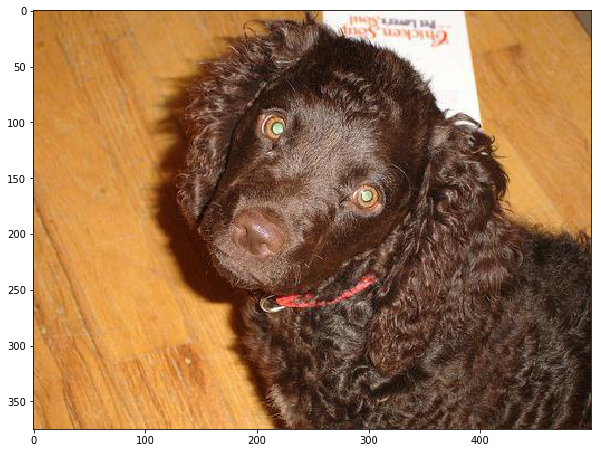

In [50]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
for infile in sorted(glob("images/*")):
     my_predictor(infile)
